# 01_PL_04_Combine_networks

The notebook __merges two different street networks into one.__ 
* Boeing is considered network 01, the base network. From the base network only what's necessary to modify is modified. 
* Tessellations is considered the network 02, the complementary network.
* Parts of the complementary network that are NOT in a zone already covered by the base network are added to the output network.

__IMPORTANT: Defining network 01 (Base) and network 02 (Complementary) has an effect on various steps of the process, from deciding what to join to how the final cleaning is performed.__

## Import libraries

In [1]:
first_folder_path = "../"

In [2]:
import os
import sys

import pandas as pd
import geopandas as gpd
import osmnx as ox
import numpy as np
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns

# To create Point from coordinates
from shapely import Point
# For calculate distance between points
import math
# To know if it is a LineString or a MultiLineString, and create them
from shapely.geometry import LineString, MultiLineString
# To split a line using a point in that line
from shapely.ops import split
# To reverse a line's geometry (Check for duplicated edges)
import shapely
# Time processes
import time

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join(first_folder_path))
if module_path not in sys.path:
    sys.path.append(module_path)
    import src

/home/observatorio/.cache/pypoetry/virtualenvs/vref-walkability-index-z1BTlbCQ-py3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Notebook config [Modify input and output dirs as required]

In [3]:
# ----- ----- ----- Input (Accepts .zip files, must unzip in following cell) ----- ----- -----
# Boeing input network - Specify nodes and edges files.
boeing_nodes_dir = first_folder_path + "data/output/shape/network_boeing/guadalajara/guadalajara_nodes.shp"
boeing_edges_dir = first_folder_path + "data/output/shape/network_boeing/guadalajara/guadalajara_edges.shp"
# Tessellations input network - Specify nodes and edges files.
tess_nodes_dir = first_folder_path+ "data/output/shape/network_tessellations/guadalajara/guadalajara_tessellations_nodes.shp"
tess_edges_dir = first_folder_path+ "data/output/shape/network_tessellations/guadalajara/guadalajara_tessellations_edges.zip"

# ----- ----- ----- Projection to be used when needed ----- ----- -----
projected_crs = "EPSG:32613" #[ "EPSG:32618" Medellín, "EPSG:32613" Guadalajara]

# ----- ----- ----- Output ----- ----- ----- 
# Output dir - Specify where outputs will be saved
output_dir = first_folder_path + "data/output/shape/network_hybrid/guadalajara/"

# Outputs to be saved - Specify which steps will be saved (Final result is localsave_02_05)
# MAKE SURE EACH SPECIFIED FOLDER EXISTS INSIDE OUTPUT_DIR
# PART 01 STEP 01 - Saves pre-formated Boeing nodes and edges [Base network], and tessellation nodes and edges [Complementary network]
# Make sure FOLDER 'part01_step01_preprocess' exists inside output_dir
localsave_01_01 = False
# PART 01 STEP 02 - Saves the uncovered parts of the complementary network (nodes and edges) and the contact nodes that will be used to connect both networks.
# Make sure FOLDER 'part01_step02_identifyuncovered' exists inside output_dir
localsave_01_02 = True
# PART 02 STEP 01 - Saves both networks (Base, complementary) nodes and edges after being intersected by themselves. Saves the intersection nodes.
# Make sure FOLDER 'part02_step01_ntwsintersection' exists inside output_dir
localsave_02_01 = False
# PART 02 STEP 03 - Saves both networks joined (concatenated_nodes, concatenated_edges)
# Make sure FOLDER 'part02_step03_ntwsconcat' exists inside output_dir
localsave_02_03 = False
# PART 02 STEP 04 - Saves both networks after being joined (joined_nodes_fix, joined_edges_fix)
# Make sure FOLDER 'part02_step04_ntwsconnect' exists inside output_dir
localsave_02_04 = False
# PART 02 STEP 05 - Saves both networks after being cleaned (joined_nodes_clean, joined_edges_clean)
# Make sure FOLDER 'part02_step05_ntwsclean' exists inside output_dir
localsave_02_05 = False

# Show dirs
print(boeing_nodes_dir)
print(boeing_edges_dir)
print(tess_nodes_dir)
print(tess_edges_dir)

../data/output/shape/network_boeing/guadalajara/guadalajara_nodes.shp
../data/output/shape/network_boeing/guadalajara/guadalajara_edges.shp
../data/output/shape/network_tessellations/guadalajara/guadalajara_tessellations_nodes.shp
../data/output/shape/network_tessellations/guadalajara/guadalajara_tessellations_edges.zip


#### __Unzip files if necessary.__ (Was necessary for Guadalajara's tessellation edges due to size.)

In [4]:
a="""
# Input dir to be extracted
input_dir = tess_edges_dir
# Output location of extracted data (unzipped files)
save_path = "../data/output/shape/network_tessellations/guadalajara/"
# Extract .zip
with zipfile.ZipFile(input_dir, "r") as zip_ref:
    zip_ref.extractall(save_path)
#"""

In [5]:
# Name of file to be looked for (input dir replacement)
tess_edges_dir = "../data/output/shape/network_tessellations/guadalajara/guadalajara_tessellations_edges.shp"

## __Functions__

### __Functions -__ Common functions

In [6]:
def produce_osmid(nodes_network_1, nodes_network_2, previously_produced):
    
    stop = False
    produced_osmid = previously_produced
    
    while stop == False:

        # Evaluate if fabricated_osmid exists in any network
        if (produced_osmid in list(nodes_network_1.osmid.unique())) or (produced_osmid in list(nodes_network_2.osmid.unique())):
            # Try the next one
            produced_osmid +=1
            
        else:
            # Reached an unique fabricated_osmid
            stop = True
            return produced_osmid

In [7]:
def create_unique_edge_id(edges_gdf,order='uvkey'):
    # Turn ID data to string
    edges_gdf['u'] = edges_gdf['u'].astype('str')
    edges_gdf['v'] = edges_gdf['v'].astype('str')
    edges_gdf['key'] = edges_gdf['key'].astype('str')
    # Concatenate ID data to create unique edge_id
    if order == 'uvkey':
        edges_gdf['edge_id'] = edges_gdf['u']+edges_gdf['v']+edges_gdf['key']
    elif order == 'vukey':
        edges_gdf['edge_id'] = edges_gdf['v']+edges_gdf['u']+edges_gdf['key']
    # Turn ID data back to int
    edges_gdf['u'] = edges_gdf['u'].astype('int')
    edges_gdf['v'] = edges_gdf['v'].astype('int')
    edges_gdf['key'] = edges_gdf['key'].astype('int')

    return edges_gdf

In [8]:
# Distance between two points
def distance_between_points(point1, point2):
    return round(math.sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2), 2)

### __Functions -__ Identify_uncovered [Used in Part01_Step02] [old version]

In [9]:
def identify_uncovered(base_nodes, base_edges, complementary_nodes, complementary_edges, contact_analysis_dist, projected_crs="EPSG:6372"):
    """ This function identifies zones within a complementary network (nodes and edges) where currently there's no coverture in a base network.
	Args:
		base_nodes (geopandas.GeoDataFrame): GeoDataFrame containing nodes of the base network. 
        base_edges (geopandas.GeoDataFrame): GeoDataFrame containing edges of the base network. 
		complementary_nodes  (geopandas.GeoDataFrame): GeoDataFrame containing nodes of the complementary network.
		complementary_edges  (geopandas.GeoDataFrame): GeoDataFrame containing edges of the complementary network.
		contact_analysis_dist (float): Distance (meters) used when deciding which nodes from the complementary network should be added to the base network.
                                A buffer of {contact_analysis_dist} is created around all center points of each complementary_edge.
                                If the buffer touches any base_edges, the complementary_edge is considered as already covered by the base network. 
                                If the buffer does not touches any base_edge, the complementary_edge is considered uncovered.
		projected_crs (str, optional): string containing projected crs to be used depending on area of interest. Defaults to "EPSG:6372".

	Returns:
        complementary_uncovered_nodes (geopandas.GeoDataFrame): GeoDataFrame with nodes from the complementary network that are located 
                                                                in a zone not covered by the base network.
        complementary_uncovered_nodes (geopandas.GeoDataFrame): GeoDataFrame with edges from the complementary network that are located
                                                                in a zone not covered by the base network.
		contact_nodes (geopandas.GeoDataFrame): GeoDataFrame with nodes from the complementary network that could be used to 
                                                connect an uncovered zone to a covered zone.
	"""

    # Turn on or off function logs (General Logs)
    function_logs = True
    # Turn on or off debbugging logs (Lots of logs used for debugging)
    debugging_logs = False
    
    # 1.0 --------------- Extract mid_point of each complementary edge
    if function_logs:
        print("1.0 - Extracting mid_point point of each complementary edge.")
    # ------------------- INPUT USED - READ COMPLEMENTARY EDGES
    complementary_edges = complementary_edges.copy()
    complementary_edges = complementary_edges.to_crs(projected_crs)
    # ------------------- INPUT USED - READ COMPLEMENTARY EDGES

    # Create unique ID for each edge using u+v+key
    complementary_edges = create_unique_edge_id(complementary_edges)
    # Find mid_point of each edge
    complementary_edges['mid_point'] = complementary_edges.interpolate(complementary_edges.length / 2)
    # Assign mid_point to its own gdf and drop column 'mid_point' from complementary_edges
    mid_points = complementary_edges[['edge_id','mid_point']].copy()
    mid_points.rename(columns={'mid_point':'geometry'},inplace=True)
    complementary_edges.drop(columns=['mid_point'],inplace=True)
    
    # 2.0 --------------- Create contact-analysis buffer around mid_points using contact_analysis_dist 
    # ------------------- (keep edge-of-origin data)
    if function_logs:
        print("2.0 - Creating contact-analysis buffer around each mid_point.")
    
    # Reset mid_points's index (Keeps data ordered starting from 0)
    mid_points.reset_index(inplace=True,drop=True) #--> Resets index without saving col 'index'
    # Save each mid_point's reseted index in a column named 'index'
    points_to_buffer = mid_points.copy()
    points_to_buffer.reset_index(inplace=True) #--> Also creates a col 'index', same order since it is reseted
    # Create a gdf containing the contact-analysis buffer around mid_points
    mid_points_buffer = points_to_buffer.buffer(contact_analysis_dist)
    mid_points_buffer = gpd.GeoDataFrame(geometry=mid_points_buffer)
    mid_points_buffer.reset_index(inplace=True) #--> Also creates a col 'index', same order since it is reseted
    # Transfer data from mid_points to it's buffer using the previously reseted index as merge col
    points_to_buffer.drop(columns=['geometry'],inplace=True)
    mid_points_buffer = pd.merge(mid_points_buffer,points_to_buffer,on='index') #--> Merges using common reseted col 'index'
    mid_points_buffer.drop(columns=['index'],inplace=True)

    # Save disk space
    del points_to_buffer
    
    # 3.0 --------------- Find mid_points whose buffer does not intersect with any part of the base network (Considering base_edges).
    # ------------------- [This step creates function output COMPLEMENTARY_UNCOVERED_EDGES]
    if function_logs:
        print("3.0 - Extracting complementary_uncovered_edges.")
    
    # ------------------- INPUT USED - READ BASE EDGES
    base_edges = base_edges.copy()
    base_edges = base_edges.to_crs(projected_crs)
    # ------------------- INPUT USED - READ BASE EDGES
    
    # Buffers that touch any base edge
    buffer_touch = mid_points_buffer.sjoin(base_edges)
    # All unique complementary edge_ids whose mid_point's buffer touched any base_edge
    edge_id_touch_lst = list(buffer_touch.edge_id.unique())
    # Complementary edges that are NOT(~) near any base edge
    complementary_uncovered_edges = complementary_edges.loc[~complementary_edges.edge_id.isin(edge_id_touch_lst)].copy()
    complementary_uncovered_edges.reset_index(inplace=True,drop=True) #--> Resets index without saving col 'index'

    # 4.0 --------------- Select the complementary_nodes that connect to the complementary_uncovered_edges
    # ------------------- [This step creates function output COMPLEMENTARY_UNCOVERED_NODES]
    if function_logs:
        print("4.0 - Extracting complementary_uncovered_nodes.")
    
    # ------------------- INPUT USED - READ COMPLEMENTARY NODES
    complementary_nodes = complementary_nodes.copy()
    complementary_nodes = complementary_nodes.to_crs(projected_crs)
    # ------------------- INPUT USED - READ COMPLEMENTARY NODES 
    
    # List of unique 'u's and 'v's that are connected to the complementary_uncovered_edges 
    complementary_uncovered_osmid_lst = set(list(complementary_uncovered_edges.u.unique()) + list(complementary_uncovered_edges.v.unique()))
    # Select any node where its 'osmid' IS in complementary_uncovered_osmid_lst
    complementary_uncovered_nodes = complementary_nodes.loc[complementary_nodes.osmid.isin(complementary_uncovered_osmid_lst)].copy()
    # [Note: This nodes won't necessarily be in the uncovered zone since they could belong to 
    # an edge whose mid_point is far from the base network, but whose path extends into the base network.]

    # 5.0 --------------- Find the nodes that would be used to connect the uncovered part of the complementary network to the base network.
    # ------------------- [This step creates function output CONTACT_NODES]
    if function_logs:
        print("5.0 - Extracting contact_nodes.")

    # 5.1 --- Create a buffer around all complementary_uncovered_nodes 
    # Reset complementary_uncovered_nodes's index
    complementary_uncovered_nodes.reset_index(inplace=True,drop=True) #--> Resets index without saving col 'index'
    # Save each complementary_uncovered_nodes's reseted index in a column named 'index'
    nodes_to_buffer = complementary_uncovered_nodes.copy()
    nodes_to_buffer.reset_index(inplace=True) #--> Also creates a col 'index', same order since it is reseted
    # Create a gdf containing the buffer around complementary_uncovered_nodes
    complementary_uncovered_nodes_buffer = nodes_to_buffer.buffer(contact_analysis_dist)
    complementary_uncovered_nodes_buffer = gpd.GeoDataFrame(geometry=complementary_uncovered_nodes_buffer)
    complementary_uncovered_nodes_buffer.reset_index(inplace=True) #--> Also creates a col 'index', same order since it is reseted
    # Transfer data from complementary_uncovered_nodes to it's buffer using the index as merge col
    nodes_to_buffer.drop(columns=['geometry'],inplace=True)
    complementary_uncovered_nodes_buffer = pd.merge(complementary_uncovered_nodes_buffer,nodes_to_buffer,on='index') #--> Merges using common reseted col 'index'
    complementary_uncovered_nodes_buffer.drop(columns=['index'],inplace=True)

    # Save disk space
    del nodes_to_buffer
    
    # 5.2 --- Find complementary_uncovered_nodes whose buffer DOES intersect with any part of the base network (Considering base_edges).
    # Buffers that touch any base edge
    buffer_touch = complementary_uncovered_nodes_buffer.sjoin(base_edges)
    # All unique osmids that touched any base_edge
    contact_osmids = list(buffer_touch.osmid.unique())
    # Complementary nodes that ARE near any base_edge
    contact_nodes = complementary_uncovered_nodes.loc[complementary_uncovered_nodes.osmid.isin(contact_osmids)].copy()
    contact_nodes.reset_index(inplace=True,drop=True) #--> Resets index without saving col 'index'

    # 6.0 --------------- Identify and shorten edges that extend into the base network and would be usefull to create connections.
    # ------------------- (Up to this step, edges whose mid_points_buffer is in contact with the base network are not included in the
    # ------------------- function's output since they are considered to be in an already-covered zone. However, some edges (if shortened)
    # ------------------- could be usefull to connect the uncovered zone to the covered zone. This step takes the edge and shortens (Clips)
    # ------------------- the edge until it's mid_point_buffer is no longer in contact with the base network)
    # ------------------- [This step updates the uncovered network (nodes and edges) and the contact nodes]
    if function_logs:
        print("6.0 - Creating missing connections through complementary_edges that travel from the uncovered zone to the base network.")

    # PREPARATION FOR ANALYSIS:

    # Keep track of the amount of edges that underwent a shortening process
    fabricated_count = 0

    # LOG CODE - Progress logs
    # Will create progress logs when progress reaches these percentages:
    progress_logs = [0,10,20,30,40,50,60,70,80,90,100] # for log statistics
    osmid_count = 0
    # LOG CODE - Progress logs

    # Create empty GeoDataFrame to store all original_diverging_nodes and original_diverging_edges (Used for GIS visualization purposes)
    original_diverging_nodes = gpd.GeoDataFrame()
    original_diverging_edges = gpd.GeoDataFrame()
    
    # Find all complementary_uncovered_osmids (from previously created complementary_uncovered_osmid_lst)
    # that are NOT a contact osmid (contact osmids are those that already serve as a connection to the base network)
    non_contact_osmids = [osmid for osmid in complementary_uncovered_osmid_lst if osmid not in contact_osmids]
    
    # Previously produced osmid. Since will be creating non-existing nodes, function produce_osmid() will use a starting number for
    # trying to produce unique osmids. That function will check if that osmid already exists in either the base or complementary network.
    # Start with number 0.
    previously_produced = 0

    # Read base_nodes once (will be used to assess if the osmid being produced is unique to both input networks)
    # ------------------- INPUT USED - READ BASE EDGES
    base_nodes = base_nodes.copy()
    base_nodes = base_nodes.to_crs(projected_crs)
    # ------------------- INPUT USED - READ BASE EDGES

    # Keep track of which parts of the network where fabricated with the following code.
    # All edges that keep its original geometry will be assigned 'clipping_i' = 0.
    # All edges whose geometry was clipped will be assigned the amount of shortening (clipping) iterations used in them.
    complementary_uncovered_nodes['clipping_i'] = 0
    complementary_uncovered_edges['clipping_i'] = 0
    complementary_uncovered_edges['original_edge_id'] = np.nan
    contact_nodes['clipping_i'] = 0

    # Shortening dict
    # Sometimes an edge could get shortened from both sides. 
    # (Clipped with starting point 'u' and then, on another case, clipped with starting point 'u')
    # If an edge will be shortened from both sides exactly once (Shortened from 'u' to midpoint and from 'v' to midpoint),
    # there would be two different new nodes in the same place. The dict helps make sure that only one contact_node is created.
    # If not considered, this particular situation can create two different edges that coincide in two different contact_nodes exactly in the midpoint.
    # (This is the main reason why it is necessary to keep track of which edges where shortened and up to which point)
    shortening_dict = {}
    
    # Review each node in the uncovered zone of the complementary network that is not already a contact_node
    # (Previously created non_contact_osmids)
    for osmid in non_contact_osmids:

        # Development check
        #if osmid != 436813694931:
        #    continue
        #else:
        #    print(osmid)
        
        # LOG CODE - Progress logs
        # Measures current progress, prints if passed a checkpoint of progress_logs list.
        current_progress = (osmid_count / len(non_contact_osmids))*100
        for checkpoint in progress_logs:
            if (current_progress >= checkpoint) and function_logs:
                print(f"6.0 - Exploring osmids. {checkpoint}% done.")
                progress_logs.remove(checkpoint)
                break
        # LOG CODE - Progress logs

        # Retrieve it's edges (Will be refered as diverging_edges). 
        # Must consider all edges (complementary_edges) and not only complementary_uncovered_edges since
        # since it's looking to identify if an edge that comes out of that osmid goes towards base_network.
        diverging_edges = complementary_edges.loc[(complementary_edges.u==osmid) | (complementary_edges.v==osmid)].copy()
        diverging_edges_ids = list(diverging_edges.edge_id.unique())
        
        # For each edge diverging from current node:
        for diverging_edge_id in diverging_edges_ids:
            # If the edge DOES touch the base network:
            if diverging_edge_id in edge_id_touch_lst: # (Previously created edge_id_touch_lst)
                # If an edge reaches this part of the code, it means that it is a complementary_edge that:
                # a) Comes out from an node that's located in the uncovered zone (complementary_uncovered_node).
                # b) The node it came out from is NOT a contact_node, it is far from the base network (According to contact_analysis_dist)
                # c) The edge's current mid_point is located in proximity to the base network (According to contact_analysis_dist)
                # --> Between the base_network and this edge itself, a connection point should be identified.
                # --> Objective: Identify that connection (new contact_node) between the complementary and base network.

                # 6.1 --- Retrieve current diverging_osmid and diverging_node
                # Save the osmid from the node which the current edge uses to come out from the uncovered zone into the base network.
                diverging_osmid = osmid
                if debugging_logs:
                    print(f"Diverging osmid: {diverging_osmid}.")
                # Extract its node
                diverging_node = complementary_uncovered_nodes.loc[complementary_uncovered_nodes.osmid == diverging_osmid].copy()
                # Reset index (so that accessing its geometry is always .loc[0,'geometry'])
                diverging_node.reset_index(inplace=True, drop=True)
                if debugging_logs:
                    print(f"Diverging node's geometry: {diverging_node.loc[0,'geometry']}.")
                # Add current diverging_node to original_diverging_nodes gdf (For GIS visualization purposes)
                original_diverging_nodes = pd.concat([original_diverging_nodes, diverging_node])

                # 6.2 --- Retrieve current diverging_edge as the connection_edge
                # Select the edge that diverts from the diverging_node towards the base_network
                connection_edge = complementary_edges.loc[complementary_edges.edge_id == diverging_edge_id].copy()
                # Reset index (so that accessing its data is always .loc[0,'data'])
                connection_edge.reset_index(inplace=True,drop=True)
                # The connection_edge geometry will suffer modifications, save original
                original_connection_edge = connection_edge.copy() 
                # Add current connection_edge to original_diverging_edges gdf (For GIS visualization purposes)
                original_diverging_edges = pd.concat([original_diverging_edges, connection_edge])

                # 6.3 --- Clip connection_edge until it's mid_point is no longer in proximity to the base network.
                # ------- When this point is reached, assign its ending_point (previous mid_point) as a new contact_node.
            
                # Kickstart while loop for current connection_edge
                stop = False
                shorten_i = 0
                
                while (stop == False):

                    # Limit of attempts
                    limit_of_attempts = 20
                    if shorten_i >= limit_of_attempts:
                        print(f"Tried shortening {limit_of_attempts} times edge u {original_connection_edge.u.unique()[0]} and v {original_connection_edge.v.unique()[0]}. Stopped.")
                        break
                        
                    # 6.3.1 --- Calculate the edge's mid_point.
                    # --------- [Will become the clipping_point in function edge_clipping()].
                
                    # Calculate the connection_edge's mid_point
                    connection_edge['mid_point'] = connection_edge.interpolate(connection_edge.length / 2)
                    # Assign mid_point to its own gdf and drop column 'mid_point' from connection_edge gdf
                    edge_mid_point = connection_edge[['edge_id','mid_point']].copy()
                    edge_mid_point.rename(columns={'mid_point':'geometry'},inplace=True)
                    connection_edge.drop(columns=['mid_point'],inplace=True)
                
                    # 6.3.2 --- Evaluate if the current mid_point is still in proximity to the base network
                    # 6.3.2.a - Create contact-analysis buffer around the edge_mid_point
                    # Reset edge_mid_point's index
                    edge_mid_point.reset_index(inplace=True,drop=True) #--> Resets index without saving col 'index'
                    # Save edge_mid_point's reseted index in a column named 'index'
                    point_to_buffer = edge_mid_point.copy()
                    point_to_buffer.reset_index(inplace=True) #--> Also creates a col 'index', same order since it is reseted
                    # Create a gdf containing the contact-analysis buffer around the edge_mid_point
                    mid_point_buffer = point_to_buffer.buffer(contact_analysis_dist)
                    mid_point_buffer = gpd.GeoDataFrame(geometry=mid_point_buffer)
                    mid_point_buffer.reset_index(inplace=True) #--> Also creates a col 'index', same order since it is reseted
                    # Transfer data from edge_mid_point to it's buffer using the previously reseted index as merge col
                    point_to_buffer.drop(columns=['geometry'],inplace=True)
                    mid_point_buffer = pd.merge(mid_point_buffer,point_to_buffer,on='index') #--> Merges using common reseted col 'index'
                    mid_point_buffer.drop(columns=['index'],inplace=True)
                    
                    # 6.3.2.b - Find if current mid_point it's still in proximity to base network
                    # Buffers that touch any base edge
                    buffer_touch = mid_point_buffer.sjoin(base_edges)
                    
                    if len(buffer_touch) > 0:
                        
                        # 6.3.3 --- If it still touches, reduce in size.
                        # If the mid_point_buffer still touches the base edges, the line is most likely still overlaping with the base network.
                        # Apply edge_clipping function to shorten the edge up until the current mid_point
                        connection_edge = edge_clipping(starting_point_gdf = diverging_node,
                                                        edge_gdf = connection_edge,
                                                        clipping_point_gdf = edge_mid_point,
                                                        projected_crs = projected_crs)
                        # Keep connection_edge format
                        connection_edge['edge_id'] = diverging_edge_id
                        # Count shortening iteration
                        shorten_i+=1
                    
                    else:
                        # 6.3.3 --- If the buffer no longer touches any part of the base network, shortening was a success.
                        # --------- However, before registering the shortened edge it it necessary to run a test:
                        
                        # Double-once-shortening test STARTS ### ### ### ### ### ### ### ### ### ### ### ### 
                        # EXPLANATION:
                        # A complementary_edge could be shortened twice, once from each starting_point. This is a "double shortening".
                        # It occurs when an edge was shortened from node 1 (e.g. from 'u') and now is being shortened from node 2 (e.g. from 'v').
                        # This process produces no problems, **unless both shortening processess undergo just 1 iteration**.
                        # In that specific case, both lines start in their nodes ('u' or 'v') and end at the original line's midpoint.
                        # This produces TWO different contact_nodes in a very similar location, that could result in TWO similar but different treatments and strange geometries.
                        # In order to avoid this, this double_shortening check is conduced in order to make sure that 
                        # at the end of both processes, just ONE contact node is produced and used by both edges ending on it.

                        # If this is NOT the first fabrication case and edge AND the current edge was shortened ONLY once:
                        if (fabricated_count > 0) and (shorten_i==1):
    
                            # Load all original edge_ids that have been shortened ONLY once
                            already_shortened_once = complementary_uncovered_edges.loc[complementary_uncovered_edges.clipping_i==1].copy()
                            already_shortened_once_lst = list(already_shortened_once.original_edge_id.unique())

                            # Check if current diverging_edge_id has already been shortened ONLY once
                            if diverging_edge_id in already_shortened_once_lst:
                                # If an edge reaches this part of the code, the edge was already shortened ONCE from one end, and was being shortened again ONCE from the other end.
                                # Next step --> Do NOT produce a new contact osmid and new point for current edge. Use the existing one. 
                                # ------------> Register the edge under the existing contact_node instead of creating a new one.

                                if debugging_logs:
                                    print(f"Edge {diverging_edge_id} was already shortened [once]. Shortening [once] again from osmid {diverging_osmid}.")

                                # 6.3.3.a1 - Identify the previously produced middle osmid.
                                # Retrieve the ORIGINAL (current original_connection_edge's) 'u' and 'v'
                                original_u = original_connection_edge.u.unique()[0]
                                original_v = original_connection_edge.v.unique()[0]
                                original_osmids = [original_u, original_v]
                                if debugging_logs:
                                    print(f"Edge's original osmids (u,v) were {original_osmids}.")
                                
                                # Retrieve the PREVIOUSLY PRODUCED (previously shortened edge) 'u' and 'v'
                                prev_produced_edge = complementary_uncovered_edges.loc[complementary_uncovered_edges.original_edge_id == diverging_edge_id].copy()
                                new_u = prev_produced_edge.u.unique()[0]
                                new_v = prev_produced_edge.v.unique()[0]
                                new_osmids = [new_u, new_v]
                                if debugging_logs:
                                    print(f"The first shortening is using osmids (u,v) {new_osmids}.")
                                
                                # Identify which osmid is in the new_osmids list but not in the original_osmids list.
                                # (Which osmid was produced here, in step 6.3.3)
                                for osmid_check in new_osmids:
                                    if osmid_check not in original_osmids:
                                        produced_osmid = osmid_check

                                # 6.3.3.a2 - Add the connection_edge as a new edge to complementary_uncovered_edges gdf (But not the node, the node is already there).
                                # Retrieve the diverging_osmid's position in the ORIGINAL connection_edge. (Whether 'u' or 'v')
                                # In order to keep that original diverging_node in its position and add the produced_osmid in the other position.
                                if diverging_osmid == original_u:
                                    connection_edge_u = diverging_osmid
                                    connection_edge_v = produced_osmid
                                    if debugging_logs:
                                        print(f"The new shortening will use osmids (u,v) = {[connection_edge_u,connection_edge_v]}.")
                                elif diverging_osmid == original_v:
                                    connection_edge_u = produced_osmid
                                    connection_edge_v = diverging_osmid
                                    if debugging_logs:
                                        print(f"The new shortening will use osmids (u,v) = {[connection_edge_u,connection_edge_v]}.")
                                else:
                                    print(f"ERROR while trying to set 'u' and 'v' for shortened connection edge {diverging_edge_id}.")
                                    print(f"The new shortening was trying to use osmids (u,v) = {[connection_edge_u,connection_edge_v]}.")
                                    intended_crash
                                # Use the same key that was used in the original_connection_edge
                                connection_edge_key = original_connection_edge.key.unique()[0]
                                # Retrieve the modified edge's (connection_edge's) geometry
                                connection_edge_geom = connection_edge['geometry'].unique()[0]
                                # Find current last position
                                iloc_edge = len(complementary_uncovered_edges)
                                # Register new edge
                                complementary_uncovered_edges.loc[iloc_edge+1,'u'] = connection_edge_u
                                complementary_uncovered_edges.loc[iloc_edge+1,'v'] = connection_edge_v
                                complementary_uncovered_edges.loc[iloc_edge+1,'key'] = connection_edge_key
                                complementary_uncovered_edges.loc[iloc_edge+1,'geometry'] = connection_edge_geom
                                complementary_uncovered_edges.loc[iloc_edge+1,'edge_id'] = str(connection_edge_u)+str(connection_edge_v)+str(connection_edge_key)
                                complementary_uncovered_edges.loc[iloc_edge+1,'original_edge_id'] = diverging_edge_id
                                complementary_uncovered_edges.loc[iloc_edge+1,'clipping_i'] = shorten_i

                                # 6.3.3.a3 - Finished registering. Stop while loop. Continue with the next diverging_edge_id of current osmid.
                                if function_logs:
                                    print(f"6.0 - Reused contact node {produced_osmid} for original edge {diverging_edge_id}.")
                                
                                fabricated_count += 1
                                stop = True
                                continue

                            # Else, this is the first time that the edge is shortened once. 
                            # Not relevant, continue as usual.
                            else:
                                pass
                                
                        # Else, either this is the first edge to be shortened or shorten_i is not equall to 1. 
                        # Not relevant, continue as usual.
                        else:
                            pass
                        # Double-once-shortening test ENDS ### ### ### ### ### ### ### ### ### ### ### ### 

                        # CONTINUATION OF NORMAL PROCESS:
                        # The current mid_point is not in proximity to the base network.
                        # But the previous mid_point (The current connection_edge's endpoint) WAS KNOWN TO BE in proximity to the base network.
                        # Next step --> Transform the last mid_point (The currend endpoint) into a contact_node and update the edge.

                        # 6.3.3.b1 - Produce a unique osmid (That doesn't exist in either network) in order to add the edge and point
                        # Produce a unique osmid
                        produced_osmid = produce_osmid(base_nodes, complementary_nodes, previously_produced+1)
                        # Save produced osmid to avoid trying numbers unnecessarily
                        previously_produced = produced_osmid
                        if debugging_logs:
                            print(f"Produced new osmid: {produced_osmid} for current diverging edge {diverging_edge_id}.")
                
                        # 6.3.3.b2 - Find the ending_point's coordinates.
                        # --------- It is unsure whether the diverging_node is located at the coordinate 0 or at the last coordinate of the connection_edge.
                        # --------- So it is necessary to identify which one is which.
                        # Extract the edge's coordinates list
                        connection_edge_coords = list(connection_edge['geometry'][0].coords)
                        # Extract the starting_point's coordinates (Known to be the diverging_node)
                        starting_point_coords = diverging_node.loc[0,'geometry'].coords[0]
                        # Obtain the ending_point's coordinates (It is the previous iteration edge's mid_point)
                        # (It is either the first or last coordinate of the connection_edge)
                        if starting_point_coords == connection_edge_coords[0]:
                            ending_point_coords = connection_edge_coords[-1]
                        elif starting_point_coords == connection_edge_coords[-1]:
                            ending_point_coords = connection_edge_coords[0]
                        else:
                            print(f"ERROR while trying to find the starting and ending point of shortened connection edge {diverging_edge_id}.")
                            print(f"Diverging node osmid: {diverging_osmid}.")
                            print(f"Diverging node (starting point) coords: {starting_point_coords}.")
                            print(f"Connection edge's coords [0]: {connection_edge_coords[0]}.")
                            print(f"Connection edge's coords [-1]: {connection_edge_coords[-1]}.")
                            intended_crash
                
                        # 6.3.3.b3 - Add the ending_point as a node
                        # Register to complementary_uncovered_nodes gdf
                        iloc_node = len(complementary_uncovered_nodes)+1
                        complementary_uncovered_nodes.loc[iloc_node,'osmid'] = produced_osmid
                        complementary_uncovered_nodes.loc[iloc_node,'geometry'] = Point(ending_point_coords)
                        complementary_uncovered_nodes.loc[iloc_node,'clipping_i'] = shorten_i
                        # Register to contact_nodes gdf
                        iloc_node = len(contact_nodes)+1
                        contact_nodes.loc[iloc_node,'osmid'] = produced_osmid
                        contact_nodes.loc[iloc_node,'geometry'] = Point(ending_point_coords)
                        contact_nodes.loc[iloc_node,'clipping_i'] = shorten_i
                
                        # 6.3.3.b4 - Add the connection_edge as a new edge to complementary_uncovered_edges gdf
                        # Retrieve the diverging_osmid its position in the ORIGINAL connection_edge. (Whether 'u' or 'v')
                        # In order to keep that original diverging_node in its position and add the produced_osmid in the other position.
                        original_u = original_connection_edge.u.unique()[0]
                        original_v = original_connection_edge.v.unique()[0]
                        if diverging_osmid == original_u:
                            connection_edge_u = diverging_osmid
                            connection_edge_v = produced_osmid
                        elif diverging_osmid == original_v:
                            connection_edge_u = produced_osmid
                            connection_edge_v = diverging_osmid
                        else:
                            print(f"ERROR while trying to set 'u' and 'v' for shortened connection edge {diverging_edge_id}.")
                            intended_crash
                        # Use the same key that was used in the original connection_edge
                        connection_edge_key = original_connection_edge.key.unique()[0]
                        # Retrieve the modified edge's (connection_edge's) geometry
                        connection_edge_geom = connection_edge['geometry'].unique()[0]
                        # Find last position
                        iloc_edge = len(complementary_uncovered_edges)+1
                        # Register new edge
                        complementary_uncovered_edges.loc[iloc_edge,'u'] = connection_edge_u
                        complementary_uncovered_edges.loc[iloc_edge,'v'] = connection_edge_v
                        complementary_uncovered_edges.loc[iloc_edge,'key'] = connection_edge_key
                        complementary_uncovered_edges.loc[iloc_edge,'geometry'] = connection_edge_geom
                        complementary_uncovered_edges.loc[iloc_edge,'edge_id'] = str(connection_edge_u)+str(connection_edge_v)+str(connection_edge_key)
                        complementary_uncovered_edges.loc[iloc_edge,'original_edge_id'] = diverging_edge_id
                        complementary_uncovered_edges.loc[iloc_edge,'clipping_i'] = shorten_i
                        
                        # 6.3.3.b5 - Finished registering. Stop while loop. Continue with the next diverging_edge_id of current osmid.
                        fabricated_count += 1
                        stop = True
        
        # LOG CODE - Progress logs
        # Finished reviewing current osmid. Continue with next osmid in non_contact_osmids.
        osmid_count+=1
        # LOG CODE - Progress logs

    if function_logs:
        print(f"Finished. Fabricated {fabricated_count}.")
                
    return complementary_uncovered_nodes, complementary_uncovered_edges, contact_nodes

### __Functions -__ Identify_uncovered_v2 [Used in Part01_Step02] [Work in progress, new version]

In [46]:
def identify_uncovered_v2(base_nodes, base_edges, complementary_nodes, complementary_edges, contact_analysis_dist, projected_crs="EPSG:6372"):
    """ This function identifies zones within a complementary network (nodes and edges) where currently there's no coverture in a base network.
	Args:
		base_nodes (geopandas.GeoDataFrame): GeoDataFrame containing nodes of the base network. 
        base_edges (geopandas.GeoDataFrame): GeoDataFrame containing edges of the base network. 
		complementary_nodes  (geopandas.GeoDataFrame): GeoDataFrame containing nodes of the complementary network.
		complementary_edges  (geopandas.GeoDataFrame): GeoDataFrame containing edges of the complementary network.
		contact_analysis_dist (float): Distance (meters) used when deciding which nodes from the complementary network should be added to the base network.
                                A buffer of {contact_analysis_dist} is created around all center points of each complementary_edge.
                                If the buffer touches any base_edges, the complementary_edge is considered as already covered by the base network. 
                                If the buffer does not touches any base_edge, the complementary_edge is considered uncovered.
		projected_crs (str, optional): string containing projected crs to be used depending on area of interest. Defaults to "EPSG:6372".

	Returns:
        complementary_uncovered_nodes (geopandas.GeoDataFrame): GeoDataFrame with nodes from the complementary network that are located 
                                                                in a zone not covered by the base network.
        complementary_uncovered_nodes (geopandas.GeoDataFrame): GeoDataFrame with edges from the complementary network that are located
                                                                in a zone not covered by the base network.
		contact_nodes (geopandas.GeoDataFrame): GeoDataFrame with nodes from the complementary network that could be used to 
                                                connect an uncovered zone to a covered zone.
	"""

    # Turn on or off function logs (General Logs)
    function_logs = True
    # Turn on or off debbugging logs (Lots of logs used for debugging)
    debugging_logs = False
    
    # 1.0 --------------- Extract mid_point of each complementary edge
    if function_logs:
        print("1.0 - Extracting mid_point point of each complementary edge.")
    # ------------------- INPUT USED - READ COMPLEMENTARY EDGES
    complementary_edges = complementary_edges.copy()
    complementary_edges = complementary_edges.to_crs(projected_crs)
    # ------------------- INPUT USED - READ COMPLEMENTARY EDGES

    # Create unique ID for each edge using u+v+key
    complementary_edges = create_unique_edge_id(complementary_edges)
    # Find mid_point of each edge
    complementary_edges['mid_point'] = complementary_edges.interpolate(complementary_edges.length / 2)
    # Assign mid_point to its own gdf and drop column 'mid_point' from complementary_edges
    mid_points = complementary_edges[['edge_id','mid_point']].copy()
    mid_points.rename(columns={'mid_point':'geometry'},inplace=True)
    complementary_edges.drop(columns=['mid_point'],inplace=True)
    
    # 2.0 --------------- Create contact-analysis buffer around mid_points using contact_analysis_dist 
    # ------------------- (keep edge-of-origin data)
    if function_logs:
        print("2.0 - Creating contact-analysis buffer around each mid_point.")
    
    # Reset mid_points's index (Keeps data ordered starting from 0)
    mid_points.reset_index(inplace=True,drop=True) #--> Resets index without saving col 'index'
    # Save each mid_point's reseted index in a column named 'index'
    points_to_buffer = mid_points.copy()
    points_to_buffer.reset_index(inplace=True) #--> Also creates a col 'index', same order since it is reseted
    # Create a gdf containing the contact-analysis buffer around mid_points
    mid_points_buffer = points_to_buffer.buffer(contact_analysis_dist)
    mid_points_buffer = gpd.GeoDataFrame(geometry=mid_points_buffer)
    mid_points_buffer.reset_index(inplace=True) #--> Also creates a col 'index', same order since it is reseted
    # Transfer data from mid_points to it's buffer using the previously reseted index as merge col
    points_to_buffer.drop(columns=['geometry'],inplace=True)
    mid_points_buffer = pd.merge(mid_points_buffer,points_to_buffer,on='index') #--> Merges using common reseted col 'index'
    mid_points_buffer.drop(columns=['index'],inplace=True)

    # Save disk space
    del points_to_buffer
    
    # 3.0 --------------- Find mid_points whose buffer does not intersect with any part of the base network (Considering base_edges).
    # ------------------- [This step creates function output COMPLEMENTARY_UNCOVERED_EDGES]
    if function_logs:
        print("3.0 - Extracting complementary_uncovered_edges.")
    
    # ------------------- INPUT USED - READ BASE EDGES
    base_edges = base_edges.copy()
    base_edges = base_edges.to_crs(projected_crs)
    # ------------------- INPUT USED - READ BASE EDGES
    
    # Buffers that touch any base edge
    buffer_touch = mid_points_buffer.sjoin(base_edges)
    # All unique complementary edge_ids whose mid_point's buffer touched any base_edge
    edge_id_touch_lst = list(buffer_touch.edge_id.unique())
    # Complementary edges that are NOT(~) near any base edge
    complementary_uncovered_edges = complementary_edges.loc[~complementary_edges.edge_id.isin(edge_id_touch_lst)].copy()
    complementary_uncovered_edges.reset_index(inplace=True,drop=True) #--> Resets index without saving col 'index'

    # 4.0 --------------- Select the complementary_nodes that connect to the complementary_uncovered_edges
    # ------------------- [This step creates function output COMPLEMENTARY_UNCOVERED_NODES]
    if function_logs:
        print("4.0 - Extracting complementary_uncovered_nodes.")
    
    # ------------------- INPUT USED - READ COMPLEMENTARY NODES
    complementary_nodes = complementary_nodes.copy()
    complementary_nodes = complementary_nodes.to_crs(projected_crs)
    # ------------------- INPUT USED - READ COMPLEMENTARY NODES 
    
    # List of unique 'u's and 'v's that are connected to the complementary_uncovered_edges 
    complementary_uncovered_osmid_lst = set(list(complementary_uncovered_edges.u.unique()) + list(complementary_uncovered_edges.v.unique()))
    # Select any node where its 'osmid' IS in complementary_uncovered_osmid_lst
    complementary_uncovered_nodes = complementary_nodes.loc[complementary_nodes.osmid.isin(complementary_uncovered_osmid_lst)].copy()
    # [Note: This nodes won't necessarily be in the uncovered zone since they could belong to 
    # an edge whose mid_point is far from the base network, but whose path extends into the base network.]

    # 5.0 --------------- Find the nodes that would be used to connect the uncovered part of the complementary network to the base network.
    # ------------------- [This step creates function output CONTACT_NODES]
    if function_logs:
        print("5.0 - Extracting contact_nodes.")

    # 5.1 --- Create a buffer around all complementary_uncovered_nodes 
    # Reset complementary_uncovered_nodes's index
    complementary_uncovered_nodes.reset_index(inplace=True,drop=True) #--> Resets index without saving col 'index'
    # Save each complementary_uncovered_nodes's reseted index in a column named 'index'
    nodes_to_buffer = complementary_uncovered_nodes.copy()
    nodes_to_buffer.reset_index(inplace=True) #--> Also creates a col 'index', same order since it is reseted
    # Create a gdf containing the buffer around complementary_uncovered_nodes
    complementary_uncovered_nodes_buffer = nodes_to_buffer.buffer(contact_analysis_dist)
    complementary_uncovered_nodes_buffer = gpd.GeoDataFrame(geometry=complementary_uncovered_nodes_buffer)
    complementary_uncovered_nodes_buffer.reset_index(inplace=True) #--> Also creates a col 'index', same order since it is reseted
    # Transfer data from complementary_uncovered_nodes to it's buffer using the index as merge col
    nodes_to_buffer.drop(columns=['geometry'],inplace=True)
    complementary_uncovered_nodes_buffer = pd.merge(complementary_uncovered_nodes_buffer,nodes_to_buffer,on='index') #--> Merges using common reseted col 'index'
    complementary_uncovered_nodes_buffer.drop(columns=['index'],inplace=True)

    # Save disk space
    del nodes_to_buffer
    
    # 5.2 --- Find complementary_uncovered_nodes whose buffer DOES intersect with any part of the base network (Considering base_edges).
    # Buffers that touch any base edge
    buffer_touch = complementary_uncovered_nodes_buffer.sjoin(base_edges)
    # All unique osmids that touched any base_edge
    contact_osmids = list(buffer_touch.osmid.unique())
    # Complementary nodes that ARE near any base_edge
    contact_nodes = complementary_uncovered_nodes.loc[complementary_uncovered_nodes.osmid.isin(contact_osmids)].copy()
    contact_nodes.reset_index(inplace=True,drop=True) #--> Resets index without saving col 'index'

    # 6.0 --------------- Identify and shorten edges that extend into the base network and would be usefull to create connections.
    # ------------------- (Up to this step, edges whose mid_points_buffer is in contact with the base network are not included in the
    # ------------------- function's output since they are considered to be in an already-covered zone. However, some edges (if shortened)
    # ------------------- could be usefull to connect the uncovered zone to the covered zone. This step takes the edge and shortens (Clips)
    # ------------------- the edge until it's mid_point_buffer is no longer in contact with the base network)
    # ------------------- [This step updates the uncovered network (nodes and edges) and the contact nodes]
    if function_logs:
        print("6.0 - Creating missing connections through complementary_edges that travel from the uncovered zone to the base network.")

    # PREPARATION FOR ANALYSIS:

    # Keep track of the amount of edges that underwent a shortening process
    fabricated_count = 0

    # LOG CODE - Progress logs
    # Will create progress logs when progress reaches these percentages:
    progress_logs = [0,10,20,30,40,50,60,70,80,90,100] # for log statistics
    osmid_count = 0
    # LOG CODE - Progress logs

    # Create empty GeoDataFrame to data used in the process (Used for GIS visualization purposes)
    original_diverging_nodes = gpd.GeoDataFrame()
    original_diverging_edges = gpd.GeoDataFrame()
    dropped_overlapping_edges = gpd.GeoDataFrame()
    
    # Find all complementary_uncovered_osmids (from previously created complementary_uncovered_osmid_lst)
    # that are NOT a contact osmid (contact osmids are those that already serve as a connection to the base network)
    non_contact_osmids = [osmid for osmid in complementary_uncovered_osmid_lst if osmid not in contact_osmids]
    
    # Previously produced osmid. Since will be creating non-existing nodes, function produce_osmid() will use a starting number for
    # trying to produce unique osmids. That function will check if that osmid already exists in either the base or complementary network.
    # Start with number 0.
    previously_produced = 0

    # Read base_nodes once (will be used to assess if the osmid being produced is unique to both input networks)
    # ------------------- INPUT USED - READ BASE EDGES
    base_nodes = base_nodes.copy()
    base_nodes = base_nodes.to_crs(projected_crs)
    # ------------------- INPUT USED - READ BASE EDGES

    # Keep track of which parts of the network where fabricated with the following code.
    # All edges that keep its original geometry will be assigned 'clipping_i' = 0.
    # All edges whose geometry was clipped will be assigned the amount of shortening (clipping) iterations used in them.
    complementary_uncovered_nodes['clipping_i'] = 0
    complementary_uncovered_edges['clipping_i'] = 0
    complementary_uncovered_edges['original_edge_id'] = np.nan
    contact_nodes['clipping_i'] = 0

    a="""
    # Shortening dict
    # Sometimes an edge could get shortened from both sides. 
    # (Clipped with starting point 'u' and then, on another case, clipped with starting point 'u')
    # If an edge will be shortened from both sides exactly once (Shortened from 'u' to midpoint and from 'v' to midpoint),
    # there would be two different new nodes in the same place. The dict helps make sure that only one contact_node is created.
    # If not considered, this particular situation can create two different edges that coincide in two different contact_nodes exactly in the midpoint.
    # (This is the main reason why it is necessary to keep track of which edges where shortened and up to which point)
    shortening_dict = {}

    # diverging_osmid dict
    # Stores each shortened edge (original_edge_id) deriving from each nodes (osmid)
    # {osmid:[shortened_original_edge_id_1, shortened_original_edge_id_2, ...]}
    diverging_osmid_dict = {}"""
    
    # Review each node in the uncovered zone of the complementary network that is not already a contact_node
    # (Previously created non_contact_osmids)
    for osmid in non_contact_osmids:

        # Development check
        #if osmid != 667187522893347:
        #    continue
        #else:
        #    print(osmid)
        
        # LOG CODE - Progress logs
        # Measures current progress, prints if passed a checkpoint of progress_logs list.
        current_progress = (osmid_count / len(non_contact_osmids))*100
        for checkpoint in progress_logs:
            if (current_progress >= checkpoint) and function_logs:
                print(f"6.0 - Exploring osmids. {checkpoint}% done.")
                progress_logs.remove(checkpoint)
                break
        # LOG CODE - Progress logs

        # Retrieve it's edges (Will be refered as diverging_edges). 
        # Must consider all edges (complementary_edges) and not only complementary_uncovered_edges since
        # since it's looking to identify if an edge that comes out of that osmid goes towards base_network.
        diverging_edges = complementary_edges.loc[(complementary_edges.u==osmid) | (complementary_edges.v==osmid)].copy()
        diverging_edges_ids = list(diverging_edges.edge_id.unique())
        
        # For each edge diverging from current node:
        for diverging_edge_id in diverging_edges_ids:
            
            if debugging_logs:
                    print(f"Diverging_edge_id: {diverging_edge_id}.")
                
            # If the edge DOES touch the base network:
            if diverging_edge_id in edge_id_touch_lst: # (Previously created edge_id_touch_lst)
                # If an edge reaches this part of the code, it means that it is a complementary_edge that:
                # a) Comes out from an node that's located in the uncovered zone (complementary_uncovered_node).
                # b) The node it came out from is NOT a contact_node, it is far from the base network (According to contact_analysis_dist)
                # c) The edge's current mid_point is located in proximity to the base network (According to contact_analysis_dist)
                # --> Between the base_network and this edge itself, a connection point should be identified.
                # --> Objective: Identify that connection (new contact_node) between the complementary and base network.

                # 6.1 --- Retrieve current diverging_osmid and diverging_node
                # Save the osmid from the node which the current edge uses to come out from the uncovered zone into the base network.
                diverging_osmid = osmid
                if debugging_logs:
                    print(f"Diverging_osmid: {diverging_osmid}.")
                # Extract its node
                diverging_node = complementary_uncovered_nodes.loc[complementary_uncovered_nodes.osmid == diverging_osmid].copy()
                # Reset index (so that accessing its geometry is always .loc[0,'geometry'])
                diverging_node.reset_index(inplace=True, drop=True)
                if debugging_logs:
                    print(f"Diverging node's geometry: {diverging_node.loc[0,'geometry']}.")
                # Add current diverging_node to original_diverging_nodes gdf (For GIS visualization purposes)
                original_diverging_nodes = pd.concat([original_diverging_nodes, diverging_node])

                # 6.2 --- Retrieve current diverging_edge as the connection_edge
                # Select the edge that diverts from the diverging_node towards the base_network
                connection_edge = complementary_edges.loc[complementary_edges.edge_id == diverging_edge_id].copy()
                # Reset index (so that accessing its data is always .loc[0,'data'])
                connection_edge.reset_index(inplace=True,drop=True)
                # The connection_edge geometry will suffer modifications, save original
                original_connection_edge = connection_edge.copy() 
                # Add current connection_edge to original_diverging_edges gdf (For GIS visualization purposes)
                original_diverging_edges = pd.concat([original_diverging_edges, connection_edge])

                # 6.3 --- Clip connection_edge until it's mid_point is no longer in proximity to the base network.
                # ------- When this point is reached, assign its ending_point (previous mid_point) as a new contact_node.


                # 6.3.0 - Find the clipping orientation
                # --------- It is unsure whether the diverging_node is located at the coordinate 0 or at the last coordinate of the connection_edge.
                # --------- So it is necessary to identify which one is which.
                # Extract the edge's coordinates list
                connection_edge_coords = list(connection_edge['geometry'][0].coords)
                # Extract the starting_point's coordinates (Known to be the diverging_node)
                starting_point_coords = diverging_node.loc[0,'geometry'].coords[0]
                # Obtain the ending_point's coordinates (It is the previous iteration edge's mid_point)
                # (It is either the first or last coordinate of the connection_edge)
                if starting_point_coords == connection_edge_coords[0]:
                    node_edge_relation = 'starting'
                elif starting_point_coords == connection_edge_coords[-1]:
                    node_edge_relation = 'ending'
                else:
                    node_edge_relation = 'missing'
            
                # Kickstart while loop for current connection_edge
                stop = False
                shorten_i = 0
                
                while (stop == False):

                    # Limit of attempts
                    limit_of_attempts =50
                    if shorten_i >= limit_of_attempts:
                        print(f"Tried shortening {limit_of_attempts} times (To 0.5% its original size) edge. Stopped.")
                        print(f"Edge data: u {original_connection_edge.u.unique()[0]}, v {original_connection_edge.v.unique()[0]}.")
                        break
                        
                    # 6.3.1 --- Calculate the edge's mid_point.
                    # --------- [Will become the clipping_point in function edge_clipping()].

                    # Set clipping factor
                    if node_edge_relation == 'starting':
                        # This means that length will be measured starting from the diverging node.
                        # We're looking to reduce to 90% that length each loop.
                        interpolation_length = connection_edge.length * 0.90
                    elif node_edge_relation == 'ending':
                        # This means that length will be measured starting from the opposite node to the diverging node.
                        # We're looking to cut the first 10% of that length each loop.
                        interpolation_length = connection_edge.length * 0.10
                    elif node_edge_relation == 'back_to_original':
                        # Check "No-shortening test" for more information
                        interpolation_length = connection_edge.length * 0.50
                    else:
                        interpolation_length = 'missing'
                    
                    # Calculate the connection_edge's mid_point
                    connection_edge['mid_point'] = connection_edge.interpolate(interpolation_length)
                    # Assign mid_point to its own gdf and drop column 'mid_point' from connection_edge gdf
                    edge_mid_point = connection_edge[['edge_id','mid_point']].copy()
                    edge_mid_point.rename(columns={'mid_point':'geometry'},inplace=True)
                    connection_edge.drop(columns=['mid_point'],inplace=True)
                
                    # 6.3.2 --- Evaluate if the current mid_point is still in proximity to the base network
                    # 6.3.2.a - Create contact-analysis buffer around the edge_mid_point
                    # Reset edge_mid_point's index
                    edge_mid_point.reset_index(inplace=True,drop=True) #--> Resets index without saving col 'index'
                    # Save edge_mid_point's reseted index in a column named 'index'
                    point_to_buffer = edge_mid_point.copy()
                    point_to_buffer.reset_index(inplace=True) #--> Also creates a col 'index', same order since it is reseted
                    # Create a gdf containing the contact-analysis buffer around the edge_mid_point
                    mid_point_buffer = point_to_buffer.buffer(contact_analysis_dist)
                    mid_point_buffer = gpd.GeoDataFrame(geometry=mid_point_buffer)
                    mid_point_buffer.reset_index(inplace=True) #--> Also creates a col 'index', same order since it is reseted
                    # Transfer data from edge_mid_point to it's buffer using the previously reseted index as merge col
                    point_to_buffer.drop(columns=['geometry'],inplace=True)
                    mid_point_buffer = pd.merge(mid_point_buffer,point_to_buffer,on='index') #--> Merges using common reseted col 'index'
                    mid_point_buffer.drop(columns=['index'],inplace=True)
                    
                    # 6.3.2.b - Find if current mid_point it's still in proximity to base network
                    # Buffers that touch any base edge
                    buffer_touch = mid_point_buffer.sjoin(base_edges)
                    
                    if len(buffer_touch) > 0:
                        
                        # 6.3.3 --- If it still touches, reduce in size.
                        # If the mid_point_buffer still touches the base edges, the line is most likely still overlaping with the base network.
                        # Apply edge_clipping function to shorten the edge up until the current mid_point
                        connection_edge = edge_clipping(starting_point_gdf = diverging_node,
                                                        edge_gdf = connection_edge,
                                                        clipping_point_gdf = edge_mid_point,
                                                        projected_crs = projected_crs)
                        # Keep connection_edge format
                        connection_edge['edge_id'] = diverging_edge_id
                        # Count shortening iteration
                        shorten_i+=1
                    
                    else:

                        # 6.3.3 --- If the buffer no longer touches any part of the base network, shortening was a success.
                        # --------- However, before registering the shortened edge it it necessary to run various TESTS:

                        # ------------------------------ NO-SHORTENING TEST START ------------------------------
                        # ORIGIN OF PROBLEM:
                        # Originally, the whole test was performed using the mid_point (hence the various relations to the name "mid_point").
                        # However this meant that some edges were cut way too much and ended up far from the base_network, creating unnecesary long connections.
                        # Now the clipping is performed by keeping 90% of the original edge each iteration.
                        # CURRENT SITUATION:
                        # The part of the code where edge_id_touch_lst is created still runs using mid_points, meaning that each diverging_edge_id examined here has its midpoint in proximity to the base network.
                        # However, since the clipping and checking inside the loop is performed using not the midpoint, but the 90% length, there are cases where an edge is NOT shortened not even once.
                        # The edge came here using the mid_point check, then when the 90%length's proximity to the base network was used it indicated that the point was no longer in contact with the base network.
                        # However, the edge suffered no changes, its proximity to the base network was examined from different points.
                        # SOLUTION:
                        # If an edge ends here with shorten_i == 0, it has not been shortened.
                        # Set node_edge_relation to "original", which triggers a mid_point (50%length) clipping each loop.
                        if shorten_i == 0:
                            node_edge_relation = "back_to_original"
                            continue
                        # ------------------------------ NO-SHORTENING TEST END ------------------------------
                        
                        # Double-once-shortening test STARTS ### ### ### ### ### ### ### ### ### ### ### ### 
                        # EXPLANATION:
                        # A complementary_edge could be shortened twice, once from each starting_point. This is a "double shortening".
                        # It occurs when an edge was shortened from node 1 (e.g. from 'u') and now is being shortened from node 2 (e.g. from 'v').
                        # This process produces no problems, **unless both shortening processess undergo just 1 iteration**.
                        # In that specific case, both lines start in their nodes ('u' or 'v') and end at the original line's midpoint.
                        # This produces TWO different contact_nodes in a very similar location, that could result in TWO similar but different treatments and strange geometries.
                        # In order to avoid this, this double_shortening check is conduced in order to make sure that 
                        # at the end of both processes, just ONE contact node is produced and used by both edges ending on it.

                        # If this is NOT the first fabrication case and edge AND the current edge was shortened ONLY once:
                        if (fabricated_count > 0) and (shorten_i==1):
    
                            # Load all original edge_ids that have been shortened ONLY once
                            already_shortened_once = complementary_uncovered_edges.loc[complementary_uncovered_edges.clipping_i==1].copy()
                            already_shortened_once_lst = list(already_shortened_once.original_edge_id.unique())

                            # Check if current diverging_edge_id has already been shortened ONLY once
                            if diverging_edge_id in already_shortened_once_lst:
                                # If an edge reaches this part of the code, the edge was already shortened ONCE from one end, and was being shortened again ONCE from the other end.
                                # Next step --> Do NOT produce a new contact osmid and new point for current edge. Use the existing one. 
                                # ------------> Register the edge under the existing contact_node instead of creating a new one.

                                if debugging_logs:
                                    print(f"Edge {diverging_edge_id} was already shortened [once]. Shortening [once] again from osmid {diverging_osmid}.")

                                # 6.3.3.a1 - Identify the previously produced middle osmid.
                                # Retrieve the ORIGINAL (current original_connection_edge's) 'u' and 'v'
                                original_u = original_connection_edge.u.unique()[0]
                                original_v = original_connection_edge.v.unique()[0]
                                original_osmids = [original_u, original_v]
                                if debugging_logs:
                                    print(f"Edge's original osmids (u,v) were {original_osmids}.")
                                
                                # Retrieve the PREVIOUSLY PRODUCED (previously shortened edge) 'u' and 'v'
                                prev_produced_edge = complementary_uncovered_edges.loc[complementary_uncovered_edges.original_edge_id == diverging_edge_id].copy()
                                new_u = prev_produced_edge.u.unique()[0]
                                new_v = prev_produced_edge.v.unique()[0]
                                new_osmids = [new_u, new_v]
                                if debugging_logs:
                                    print(f"The first shortening is using osmids (u,v) {new_osmids}.")
                                
                                # Identify which osmid is in the new_osmids list but not in the original_osmids list.
                                # (Which osmid was produced here, in step 6.3.3)
                                for osmid_check in new_osmids:
                                    if osmid_check not in original_osmids:
                                        produced_osmid = osmid_check

                                # 6.3.3.a2 - Add the connection_edge as a new edge to complementary_uncovered_edges gdf (But not the node, the node is already there).
                                # Retrieve the diverging_osmid's position in the ORIGINAL connection_edge. (Whether 'u' or 'v')
                                # In order to keep that original diverging_node in its position and add the produced_osmid in the other position.
                                if diverging_osmid == original_u:
                                    connection_edge_u = diverging_osmid
                                    connection_edge_v = produced_osmid
                                    if debugging_logs:
                                        print(f"The new shortening will use osmids (u,v) = {[connection_edge_u,connection_edge_v]}.")
                                elif diverging_osmid == original_v:
                                    connection_edge_u = produced_osmid
                                    connection_edge_v = diverging_osmid
                                    if debugging_logs:
                                        print(f"The new shortening will use osmids (u,v) = {[connection_edge_u,connection_edge_v]}.")
                                else:
                                    print(f"ERROR while trying to set 'u' and 'v' for shortened connection edge {diverging_edge_id}.")
                                    print(f"The new shortening was trying to use osmids (u,v) = {[connection_edge_u,connection_edge_v]}.")
                                    intended_crash
                                # Use the same key that was used in the original_connection_edge
                                connection_edge_key = original_connection_edge.key.unique()[0]
                                # Retrieve the modified edge's (connection_edge's) geometry
                                connection_edge_geom = connection_edge['geometry'].unique()[0]
                                # Find current last position
                                iloc_edge = len(complementary_uncovered_edges)
                                # Register new edge
                                complementary_uncovered_edges.loc[iloc_edge+1,'u'] = connection_edge_u
                                complementary_uncovered_edges.loc[iloc_edge+1,'v'] = connection_edge_v
                                complementary_uncovered_edges.loc[iloc_edge+1,'key'] = connection_edge_key
                                complementary_uncovered_edges.loc[iloc_edge+1,'geometry'] = connection_edge_geom
                                complementary_uncovered_edges.loc[iloc_edge+1,'edge_id'] = str(connection_edge_u)+str(connection_edge_v)+str(connection_edge_key)
                                complementary_uncovered_edges.loc[iloc_edge+1,'original_edge_id'] = diverging_edge_id
                                complementary_uncovered_edges.loc[iloc_edge+1,'clipping_i'] = shorten_i

                                # 6.3.3.a3 - Finished registering. Stop while loop. Continue with the next diverging_edge_id of current osmid.
                                if function_logs:
                                    print(f"6.0 - Reused contact node {produced_osmid} for original edge {diverging_edge_id}.")
                                
                                fabricated_count += 1
                                stop = True
                                continue

                            # Else, this is the first time that the edge is shortened once. 
                            # Not relevant, continue as usual.
                            else:
                                pass
                                
                        # Else, either this is the first edge to be shortened or shorten_i is not equall to 1. 
                        # Not relevant, continue as usual.
                        else:
                            pass
                        # Double-once-shortening test ENDS ### ### ### ### ### ### ### ### ### ### ### ### 

                        # Overlapping edges test STARTS ### ### ### ### ### ### ### ### ### ### ### ###
                        try:
                            # Overlapping checker
                            overlapping_exists = False
                            
                            # Retrieve the modified edge's (connection_edge's) geometry, create a VERY SMALL buffer and get its length
                            connection_edge_geom = connection_edge['geometry'].unique()[0]
                            connection_edge_buff = connection_edge_geom.buffer(0.10)
                            connection_edge_length = connection_edge_geom.length
                            
                            # Find all edges that come out of the current diverging_osmid
                            idx = (complementary_uncovered_edges["u"]==diverging_osmid)|(complementary_uncovered_edges["v"]==diverging_osmid)
                            potential_overlapping = complementary_uncovered_edges.loc[idx].copy()
                            # Remove itself (original_edge_id)
                            drop_idx = potential_overlapping.edge_id==diverging_edge_id
                            potential_overlapping = potential_overlapping.loc[~drop_idx].copy()
                            
                            if debugging_logs:
                                print(f"Reviewing overlapping with already edges {potential_overlapping.edge_id.unique()}.")
                            
                            # Get a list of all geometries where overlapping is going to be analysed
                            potential_geoms = list(potential_overlapping.geometry.unique())
                            # Analyse each edge's overlapping percentage
                            for potential_geom in potential_geoms:                                    
                                # Create a VERY SMALL buffer around already shortened edge and get its length
                                potential_geom_buff = potential_geom.buffer(0.10)
                                potential_geom_length = potential_geom.length
                                # Calculate percentage of overlapping in shortest line
                                if connection_edge_length < potential_geom_length:
                                    overlapping_area_pct = (connection_edge_buff.intersection(potential_geom_buff).area) / (connection_edge_buff.area)
                                else:
                                    overlapping_area_pct = (potential_geom_buff.intersection(connection_edge_buff).area) / (potential_geom_buff.area)
                                # If overlapping is above 75%, we are practically duplicating a connection. Drop.
                                if overlapping_area_pct > 0.75:
                                    if debugging_logs:
                                        print(f"Overlapping. Broke from internal loop. ({overlapping_area_pct*100}%).")
                                    overlapping_exists=True
                                    break
                            # If the analysis found overlapping, do not proceed.    
                            if overlapping_exists:
                                if debugging_logs:
                                    print("Not adding shortened edge, exceeded overlap with existing path.")
                                # Find last position
                                iloc_edge = len(dropped_overlapping_edges)+1
                                # Add dropped connection to dropped_overlapping_edges gdf (For GIS visualization purposes)
                                dropped_overlapping_edges.loc[iloc_edge,'geometry'] = connection_edge_geom
                                dropped_overlapping_edges.loc[iloc_edge,'original_edge_id'] = diverging_edge_id
                                dropped_overlapping_edges.loc[iloc_edge,'clipping_i'] = shorten_i
                                stop = True
                                continue
                            else:
                                if debugging_logs:
                                    print("No overlapping. Continuing.")
                        except:
                            print(f"Overlapping failed on diverging_edge_id {diverging_edge_id}.")
                            print(f"connection_edge_length: {connection_edge_length}.")
                            print(f"connection_edge_buff area: {connection_edge_buff.area}.")    
                        # Overlapping shortened edges test ENDS ### ### ### ### ### ### ### ### ### ### ### ###
                                
                        # CONTINUATION OF NORMAL PROCESS:
                        # The current mid_point is not in proximity to the base network.
                        # But the previous mid_point (The current connection_edge's endpoint) WAS KNOWN TO BE in proximity to the base network.
                        # Next step --> Transform the last mid_point (The currend endpoint) into a contact_node and update the edge.

                        # 6.3.3.b1 - Produce a unique osmid (That doesn't exist in either network) in order to add the edge and point
                        # Produce a unique osmid
                        produced_osmid = produce_osmid(base_nodes, complementary_nodes, previously_produced+1)
                        # Save produced osmid to avoid trying numbers unnecessarily
                        previously_produced = produced_osmid
                        if debugging_logs:
                            print(f"Produced new osmid: {produced_osmid} for current diverging edge {diverging_edge_id}.")
                
                        # 6.3.3.b2 - Find the ending_point's coordinates.
                        # --------- It is unsure whether the diverging_node is located at the coordinate 0 or at the last coordinate of the connection_edge.
                        # --------- So it is necessary to identify which one is which.
                        # Extract the edge's coordinates list
                        connection_edge_coords = list(connection_edge['geometry'][0].coords)
                        # Extract the starting_point's coordinates (Known to be the diverging_node)
                        starting_point_coords = diverging_node.loc[0,'geometry'].coords[0]
                        # Obtain the ending_point's coordinates (It is the previous iteration edge's mid_point)
                        # (It is either the first or last coordinate of the connection_edge)
                        if starting_point_coords == connection_edge_coords[0]:
                            ending_point_coords = connection_edge_coords[-1]
                        elif starting_point_coords == connection_edge_coords[-1]:
                            ending_point_coords = connection_edge_coords[0]
                        else:
                            print(f"ERROR while trying to find the starting and ending point of shortened connection edge {diverging_edge_id}.")
                            print(f"Diverging node osmid: {diverging_osmid}.")
                            print(f"Diverging node (starting point) coords: {starting_point_coords}.")
                            print(f"Connection edge's coords [0]: {connection_edge_coords[0]}.")
                            print(f"Connection edge's coords [-1]: {connection_edge_coords[-1]}.")
                            intended_crash
                
                        # 6.3.3.b3 - Add the ending_point as a node
                        # Register to complementary_uncovered_nodes gdf
                        iloc_node = len(complementary_uncovered_nodes)+1
                        complementary_uncovered_nodes.loc[iloc_node,'osmid'] = produced_osmid
                        complementary_uncovered_nodes.loc[iloc_node,'geometry'] = Point(ending_point_coords)
                        complementary_uncovered_nodes.loc[iloc_node,'clipping_i'] = shorten_i
                        # Register to contact_nodes gdf
                        iloc_node = len(contact_nodes)+1
                        contact_nodes.loc[iloc_node,'osmid'] = produced_osmid
                        contact_nodes.loc[iloc_node,'geometry'] = Point(ending_point_coords)
                        contact_nodes.loc[iloc_node,'clipping_i'] = shorten_i
                
                        # 6.3.3.b4 - Add the connection_edge as a new edge to complementary_uncovered_edges gdf
                        # Retrieve the diverging_osmid its position in the ORIGINAL connection_edge. (Whether 'u' or 'v')
                        # In order to keep that original diverging_node in its position and add the produced_osmid in the other position.
                        original_u = original_connection_edge.u.unique()[0]
                        original_v = original_connection_edge.v.unique()[0]
                        if diverging_osmid == original_u:
                            connection_edge_u = diverging_osmid
                            connection_edge_v = produced_osmid
                        elif diverging_osmid == original_v:
                            connection_edge_u = produced_osmid
                            connection_edge_v = diverging_osmid
                        else:
                            print(f"ERROR while trying to set 'u' and 'v' for shortened connection edge {diverging_edge_id}.")
                            intended_crash
                        # Use the same key that was used in the original connection_edge
                        connection_edge_key = original_connection_edge.key.unique()[0]
                        # Retrieve the modified edge's (connection_edge's) geometry
                        connection_edge_geom = connection_edge['geometry'].unique()[0]
                        # Find last position
                        iloc_edge = len(complementary_uncovered_edges)+1
                        # Register new edge
                        complementary_uncovered_edges.loc[iloc_edge,'u'] = connection_edge_u
                        complementary_uncovered_edges.loc[iloc_edge,'v'] = connection_edge_v
                        complementary_uncovered_edges.loc[iloc_edge,'key'] = connection_edge_key
                        complementary_uncovered_edges.loc[iloc_edge,'geometry'] = connection_edge_geom
                        complementary_uncovered_edges.loc[iloc_edge,'edge_id'] = str(connection_edge_u)+str(connection_edge_v)+str(connection_edge_key)
                        complementary_uncovered_edges.loc[iloc_edge,'original_edge_id'] = diverging_edge_id
                        complementary_uncovered_edges.loc[iloc_edge,'clipping_i'] = shorten_i

                        a="""
                        # 6.3.3.b5 - Register current process
                        # Registration - shortening_dict
                        if str(shorten_i) in shortening_dict.keys():
                            # If this is not the first time a shortening process with <shorten_i> iterations is registered, append.
                            current_lst = shortening_dict[str(shorten_i)]
                            shortening_dict[str(shorten_i)] = current_lst.append(diverging_edge_id)
                        else:
                            # If this is the first time a shortening process with <shorten_i> iterations is registered, create list
                            shortening_dict[str(shorten_i)] = [diverging_edge_id]
                            
                        # Registration - diverging_osmid_dict
                        if diverging_osmid in diverging_osmid_dict.keys():
                            # If this is not the first time an edge from this osmid is shortened, append
                            current_lst = diverging_osmid_dict[diverging_osmid]
                            current_lst.append(diverging_edge_id)
                            diverging_osmid_dict[diverging_osmid] = current_lst
                        else:
                            # If this is the first time an edge from this osmid is shortened, create list
                            diverging_osmid_dict[diverging_osmid] = [diverging_edge_id]"""

                        # Registration - Process count
                        fabricated_count += 1
                    
                        # 6.3.3.b6 - Finished registering. Stop while loop. Continue with the next diverging_edge_id of current osmid.
                        stop = True
        
        # LOG CODE - Progress logs
        # Finished reviewing current osmid. Continue with next osmid in non_contact_osmids.
        osmid_count+=1
        # LOG CODE - Progress logs

    if function_logs:
        print(f"Finished. Fabricated {fabricated_count}.")

    a="""
    if debugging_logs:
        print(f"Printing diverging_osmid_dict.")
        print(diverging_osmid_dict)
        """
    # Final format
    dropped_overlapping_edges = dropped_overlapping_edges.set_crs(projected_crs)
                
    return complementary_uncovered_nodes, complementary_uncovered_edges, contact_nodes, dropped_overlapping_edges

### __Functions -__ edge_clipping [Used in Part01_Step02, Part02_Step01, Part02_Step03, Part02_Step04]

In [10]:
def edge_clipping(starting_point_gdf, edge_gdf, clipping_point_gdf, projected_crs="EPSG:6372", return_all=False, function_logs=False):
    
    """ This function clips an edge by considering a starting point and a clipping point.
    
	Args:
		starting_point_gdf (geopandas.GeoDataFrame): GeoDataFrame containing the starting point of the LineString, helps identify each split part. 
                                                     Requires column 'geometry' with a Point.
        edge_gdf (geopandas.GeoDataFrame): GeoDataFrame containing the edge to be clipped. 
                                           Requires column 'geometry' with a LineString.
        clipping_point_gdf (geopandas.GeoDataFrame): GeoDataFrame containing the clipping point of the LineString.
                                                     Requires column 'geometry' with a Point.
        projected_crs (str, optional): string containing projected crs to be used depending on area of interest. Defaults to "EPSG:6372".
        return_all (bool,optional): Boolean that defines whether the clipped edge is returned from starting_point to clipping_point only (One line) (False)
                                    or returned from starting_point to clipping_point and then from clipping_point to ending_point (Two lines) (True). 
                                    Defaults to False.
        function_logs (bool,optional): Boolean that (if True) prints logs during the functions execution. Defaults to False.
                                                 
	Returns:
        split_edge_gdf (geopandas.GeoDataFrame): GeoDataFrame with either one (return_all=False) or two (return_all=True) edges.
	"""
    
    # 1.0 --------------- Split the edge using the clipping_point. Creates two separate edges.
    # Extract the edge's geometry (LineString)
    edge_geom = edge_gdf['geometry'].unique()[0]
    # Extract the clipping_point's geometry (Point)
    clipping_point_geom = clipping_point_gdf['geometry'][0]
    # Project the clipping_point onto the edge (In case it's not drawn exactly in the LineString)
    projected_point = edge_geom.interpolate(edge_geom.project(clipping_point_geom))
    
    # ----- ----- Added code since having trouble clipping with a point ----- -----
    # Create a VERY SMALL buffer around the projected_point
    projected_point = projected_point.buffer(1e-9)
    # ----- ----- Added code since having trouble clipping with a point ----- -----
    
    # Split the edge where the projected clipping_point is
    split_lines = split(edge_geom, projected_point)
    # Convert the split lines to a GeoDataFrame
    split_gdf = gpd.GeoDataFrame(geometry=list(split_lines.geoms), crs=projected_crs)
    
    # ----- ----- Added code since having trouble clipping with a point ----- -----
    # Drop the small split line located inside the VERY SMALL buffer in order to keep the two split lines outside it.
    if len(split_gdf) ==3 :
        split_gdf['length'] = split_gdf.length
        split_gdf = split_gdf.loc[split_gdf.length != split_gdf.length.min()]
    split_gdf.reset_index(inplace=True,drop=True)
    # ----- ----- Added code since having trouble clipping with a point ----- -----

    
    # 2.0 --------------- Find which split LineString in split_gdf contains the LineString where the starting_point (input arg) is located.
    # ------------------- This linestring is called "split_edge_geom_start", the other one is "split_edge_geom_end".

    # Extract the starting_point's coordinates (Function input)
    starting_point_coords = starting_point_gdf.loc[0,'geometry'].coords[0]
    if function_logs:
        print(f"edge_clipping(): Extracted starting_point_coords: {starting_point_coords}.")
        
    # Find which line from split_gdf has the starting_point_coords by...
    # ... checking if the starting_point_coords are in line 0
    if starting_point_coords in list(split_gdf.loc[0,'geometry'].coords):
        split_edge_geom_start = split_gdf.loc[0,'geometry'] # Line geometry related to starting_point
        split_edge_geom_end = split_gdf.loc[1,'geometry'] # Second line geometry
        if function_logs:
            print(f"edge_clipping(): Found line containing coords equal to starting_point_coords {starting_point_coords}.")
            print(f"edge_clipping(): Line found: {list(split_gdf.loc[0,'geometry'].coords)}.")
            
    # ... or, checking if the starting_point_coords are in line 1   
    elif starting_point_coords in list(split_gdf.loc[1,'geometry'].coords):
        split_edge_geom_start = split_gdf.loc[1,'geometry'] # Line geometry related to starting_point
        split_edge_geom_end = split_gdf.loc[0,'geometry'] # Second line geometry
        if function_logs:
            print(f"edge_clipping(): Found line containing coords equal to starting_point_coords {starting_point_coords}.")
            print(f"edge_clipping(): Line found: {list(split_gdf.loc[0,'geometry'].coords)}.")
            
    # ... or else, measure distances and assume the starting_point is the closest one.
    else:
        # Line 0 data
        line_0_coords = list(split_gdf.loc[0,'geometry'].coords)
        line_0_firstcoords_dist = distance_between_points(line_0_coords[0], starting_point_coords)
        line_0_lastcoords_dist = distance_between_points(line_0_coords[-1], starting_point_coords)
        # Line 1 data
        line_1_coords = list(split_gdf.loc[1,'geometry'].coords)
        line_1_firstcoords_dist = distance_between_points(line_1_coords[0], starting_point_coords)
        line_1_lastcoords_dist = distance_between_points(line_1_coords[-1], starting_point_coords)
        # Compare distances and find min distance
        distances_lst = [line_0_firstcoords_dist,line_0_lastcoords_dist,line_1_firstcoords_dist,line_1_lastcoords_dist]
        minimum_distance = min(distances_lst)
        minimum_distance_position = distances_lst.index(minimum_distance)
        # Find line related to the starting_point
        # First two distances in list correspond to line 0. If true, Line 0 is related to the starting_point.
        if (minimum_distance_position == 0) | (minimum_distance_position == 1):
            split_edge_geom_start = split_gdf.loc[0,'geometry'] # Line geometry related to starting_point
            split_edge_geom_end = split_gdf.loc[1,'geometry'] # Second line geometry
        # Second two distances in list correspond to line 1. If true, Line 1 is related to the starting_point.
        elif (minimum_distance_position == 2) | (minimum_distance_position == 3):
            split_edge_geom_start = split_gdf.loc[1,'geometry'] # Line geometry related to starting_point
            split_edge_geom_end = split_gdf.loc[0,'geometry'] # Second line geometry
        if function_logs:
            print(f"edge_clipping(): Found line containing coords close to starting_point_coords {starting_point_coords}. Distance: {minimum_distance}.")
            print(f"edge_clipping(): Line found: {list(split_gdf.loc[0,'geometry'].coords)}.")
        
    a=""" [SUBSTITUTED BY CHANGES ABOVE]
    # 2.0 --------------- Find which split LineString in split_gdf contains the LineString where the starting_point is located
    
    # Extract the edge's first and last coordinates
    edge_coords = list(edge_gdf['geometry'][0].coords)
    first_point_coords = edge_coords[0]
    last_point_coords = edge_coords[-1]

    if function_logs:
        print(f"edge_clipping(): Extracted first_point_coords: {first_point_coords}.")
        print(f"edge_clipping(): Extracted last_point_coords: {last_point_coords}.")
    
    # Extract the starting_point's coordinates (Function input)
    starting_point_coords = starting_point_gdf.loc[0,'geometry'].coords[0]
    if function_logs:
        print(f"edge_clipping(): Extracted starting_point_coords: {starting_point_coords}.")
        
    # Try identifying which (first or last) is the starting_point by checking equality in coordinates
    if starting_point_coords == first_point_coords:
        # Starting point is first_point
        starting_point_coords = first_point_coords
    elif starting_point_coords == last_point_coords:
        # Starting point is last_point
        starting_point_coords = last_point_coords
    # Else, measure distance and assume the starting_point is the closest one.
    # (this case applies when starting_point is not drawn exactly in the LineString)
    else:
        # Distance from starting_point to first point
        first_point_distance = distance_between_points(first_point_coords, starting_point_coords)
        # Distance from starting_point to last point
        last_point_distance = distance_between_points(last_point_coords, starting_point_coords)
        # Find which one is the starting_point
        if first_point_distance < last_point_distance:
            # Starting point is first_point
            starting_point_coords = first_point_coords
        else:
            # Starting point is last_point
            starting_point_coords = last_point_coords
    
    # 3.0 --------------- Select split LineString where the starting_point is.
    
    # Find which line from split_gdf has the starting_point_coords
    # Extract both lines (starting and ending line)
    if starting_point_coords in list(split_gdf.loc[0,'geometry'].coords):
        split_edge_geom_start = split_gdf.loc[0,'geometry'] # Extract first line geometry
        split_edge_geom_end = split_gdf.loc[1,'geometry'] # Second line geometry
        
    elif starting_point_coords in list(split_gdf.loc[1,'geometry'].coords):
        split_edge_geom_start = split_gdf.loc[1,'geometry'] # Extract second line geometry
        split_edge_geom_end = split_gdf.loc[0,'geometry'] # Second line geometry

    else:
        print(f"First line's coords:{list(split_gdf.loc[0,'geometry'].coords)}.")
        print(f"Second line: {list(split_gdf.loc[1,'geometry'].coords)}.")
        print(f"Starting point coords: {starting_point_coords}.")
    """
        
    # Convert to a GeoDataFrame
    split_edge_gdf = gpd.GeoDataFrame()
    split_edge_gdf.loc[0,'geometry'] = split_edge_geom_start
    
    # 4.0 --------------- (Optional) Include split other LineString.
    if return_all:
        split_edge_gdf.loc[1,'geometry'] = split_edge_geom_end
        split_edge_gdf.loc[0,'relation'] = 'starting'
        split_edge_gdf.loc[1,'relation'] = 'ending'

    # Final format
    split_edge_gdf = split_edge_gdf.set_crs(projected_crs)

    return split_edge_gdf

### __Functions -__ find_intersection_nodes [Used in Part02_Step01]

In [11]:
def find_intersection_nodes(ntw_01_nodes, ntw_01_edges, ntw_02_nodes, ntw_02_edges, projected_crs):

    """ This function finds the intersection points existing between two different networks, and turns them
        into nodes by assigning them a unique osmid.
    
	Args:
		ntw_01_nodes (geopandas.GeoDataFrame): GeoDataFrame containing the nodes from network 01.
                                                Requires a unique identifier 'osmid'.
        ntw_01_edges (geopandas.GeoDataFrame): GeoDataFrame containing the edges from network 01. 
                                                   Requires the unique identifiers 'u ,'v' and 'key'.
        ntw_02_nodes (geopandas.GeoDataFrame): GeoDataFrame containing the nodes from network 02.
                                                Requires a unique identifier 'osmid'.
        ntw_02_edges (geopandas.GeoDataFrame): GeoDataFrame containing the edges from network 02. 
                                                   Requires the unique identifiers 'u ,'v' and 'key'.
        projected_crs (str, optional): String containing projected crs to be used depending on area of interest. 
                                        Defaults to "EPSG:6372".
                                                 
	Returns:
        intersection_nodes (geopandas.GeoDataFrame): GeoDataFrame containing the new nodes where both networks intersect.
        
	"""
    
    # 1.0 --------------- Intersect both network's edges to create the intersection_points.
    # ------------------- These nodes contain data from the edges that were intersected.

    # ------------------- INPUT USED - READ AND FILTER EDGES
    ntw_01_edges = ntw_01_edges.copy()
    ntw_01_edges = ntw_01_edges.to_crs(projected_crs)
    ntw_01_edges = ntw_01_edges[['u','v','key','geometry']]

    ntw_02_edges = ntw_02_edges.copy()
    ntw_02_edges = ntw_02_edges.to_crs(projected_crs)
    ntw_02_edges = ntw_02_edges[['u','v','key','geometry']]
    # ------------------- INPUT USED - READ AND FILTER EDGES
    
    # Intersect ntw_01_edges and ntw_02_edges to create intersection_points
    # Each intersection_point contains data from the edges being intersected.
    # For ntw_01_edges, columns: u_1, v_1, key_1
    # For ntw_02_edges, columns: u_2, v_2, key_2
    intersection_points = ntw_01_edges.overlay(ntw_02_edges,how='intersection',keep_geom_type=False)
    # Explode multipoints
    # If an edge from network "x" cuts an edge from network "y" twice or more [e.g. a straight edge cutting a curved edge], 
    # the resulting geometry is a MultiPoint (One point in the first intersection, another for the second and so on).
    # In order to avoid assigning the same data to both points, exploding is neccesary.
    intersection_points = intersection_points.explode(index_parts=False)
    intersection_points.reset_index(inplace=True,drop=True)

    print("Intersected networks and created intersection_points.")

    # 2.0 --------------- Assign unique osmid to each new intersection_point to turn it into a intersection_node.

    # ------------------- INPUT USED - READ AND FILTER EDGES
    ntw_01_nodes = ntw_01_nodes.copy()
    ntw_01_nodes = ntw_01_nodes.to_crs(projected_crs)
    ntw_01_nodes = ntw_01_nodes[['osmid','geometry']]

    ntw_02_nodes = ntw_02_nodes.copy()
    ntw_02_nodes = ntw_02_nodes.to_crs(projected_crs)
    ntw_02_nodes = ntw_02_nodes[['osmid','geometry']]
    # ------------------- INPUT USED - READ AND FILTER EDGES

    intersection_nodes = intersection_points.copy()
    del intersection_points
    # Set all osmids to 0
    intersection_nodes['osmid'] = 0
    # Restart previously_produced
    previously_produced = 0
    # For each intersection between networks (new node)
    for index,row in intersection_nodes.iterrows():
        # Produce a unique osmsid (That doesn't exist in either network)
        produced_osmid = produce_osmid(ntw_01_nodes, ntw_02_nodes, previously_produced)
        # Assign osmid to current intersection_node
        intersection_nodes.loc[index,'osmid'] = produced_osmid
        # Since ntw_01_nodes and ntw_02_nodes are not being updated, next time try with next possible osmid
        previously_produced = produced_osmid+1

    print("Set unique osmids to all intersection_points. Turned into intersection_nodes.")

    # Set unique identifiers to int
    intersection_nodes['u_1'] = intersection_nodes['u_1'].astype('int')
    intersection_nodes['v_1'] = intersection_nodes['v_1'].astype('int')
    intersection_nodes['key_1'] = intersection_nodes['key_1'].astype('int')
    intersection_nodes['u_2'] = intersection_nodes['u_2'].astype('int')
    intersection_nodes['v_2'] = intersection_nodes['v_2'].astype('int')
    intersection_nodes['key_2'] = intersection_nodes['key_2'].astype('int')
    intersection_nodes['osmid'] = intersection_nodes['osmid'].astype('int')

    # 3.0 --------------- Unify geometry duplicates under the same osmid (MULTIPLE INTERSECTION ADAPTATION)
    # EXPLANATION
    # Function find_intersection_nodes() was originaly designed to create a dataframe that stablishes intersection points between
    # 1 (one) edge of a network and 1 (one) edge of another network. The dataframe stores the IDs of each intersected edge and the intersecting node.
    # However, cases were found where three or more edges intersect exactly at the same point (particularly due to the use of tessellations-generated networks).
    # The result is having two (or more) intersection_nodes located exactly at the same point.
    # e.g. one intersecting edge_1 from network "x" and edge_1 from network "y", 
    # and the other intersecting edge_2 from network "x" and edge_1 from network "y".

    # Following that example, in order to avoid duplicated nodes with different osmids,
    # this MULTIPLE INTERSECTION ADAPTATION unifies geometry duplicates under the same osmid.
    # (It shouldn't be done by just dropping duplicates since the dataframe has the intersected edges's data.)
    dup_geometries_lst = list(intersection_nodes.loc[intersection_nodes.duplicated(subset=['geometry'])].geometry.unique())
    for dup_geom in dup_geometries_lst:
        # Rows to change
        idx = intersection_nodes.geometry==dup_geom
        # Osmid to use in all intersection cases (Doesn't matter which)
        chosen_osmid = list(intersection_nodes.loc[idx].osmid.unique())[0]
        # Unify those rows's osmid
        intersection_nodes.loc[idx,'osmid'] = chosen_osmid

    return intersection_nodes

### __Functions -__ networks_intersections_update [Used in Part02_Step01, Part02_Step03, Part02_Step04]

In [12]:
def network_intersections_update(current_ntw_nodes, current_ntw_edges, intersection_nodes, projected_crs,
                                 intersection_logs=False, clipping_logs=False):

    """ This function takes points with osmid located over existing edges (intersection_nodes) and updates
        a network. The intersection_nodes become new nodes and each intersected edge get split 
        into two separate edges with new 'u', 'v' and 'key' data.
    
	Args:
		current_ntw_nodes (geopandas.GeoDataFrame): GeoDataFrame containing the nodes from the network to update.
                                                    Requires a unique identifier 'osmid'.
        current_ntw_edges (geopandas.GeoDataFrame): GeoDataFrame containing the edges from the network to update.
                                                    Requires the unique identifiers 'u ,'v' and 'key'.
        intersection_nodes (geopandas.GeoDataFrame): GeoDataFrame containing the points in where each split is performed.
                                                    Requires points with 'osmid', and the edge to split ('u','v' and 'key').
        projected_crs (str, optional): String containing projected crs to be used depending on area of interest. 
                                        Defaults to "EPSG:6372".
        intersection_logs (bool,optional): Boolean that (if True) prints logs during the current function's execution. Defaults to False.
        clipping_logs (bool,optional): Boolean that (if True) prints logs during the edge_clipping() function's execution. Defaults to False.

                                                 
	Returns:
        updated_ntw_nodes (geopandas.GeoDataFrame): GeoDataFrame containing the updated nodes for the network.
        updated_ntw_edges (geopandas.GeoDataFrame): GeoDataFrame containing the updated edges for the network. 
        
	""" 
    
    print(f"Updating network...")
    
    # ------------------- INPUT USED - READ NODES AND EDGES
    current_ntw_nodes = current_ntw_nodes.copy()
    current_ntw_nodes = current_ntw_nodes.to_crs(projected_crs)
    # Set an identifier to make it easier to locate nodes that resulted from an intersection between networks
    current_ntw_nodes['intersecting'] = 0
    # Make sure unique identifiers ('u','v', and 'key') are integers to avoid problems when creating edge_ids.
    current_ntw_nodes['osmid'] = current_ntw_nodes['osmid'].apply(lambda x: int(round(float(x),0)))

    current_ntw_edges = current_ntw_edges.copy()
    current_ntw_edges = current_ntw_edges.to_crs(projected_crs)
    # Set an identifier to make it easier to locate edges that were split
    current_ntw_edges['intersecting'] = 0
    # Make sure unique identifiers ('u','v', and 'key') are integers to avoid problems when creating edge_ids.
    current_ntw_edges['u'] = current_ntw_edges['u'].apply(lambda x: int(round(float(x),0)))
    current_ntw_edges['v'] = current_ntw_edges['v'].apply(lambda x: int(round(float(x),0)))
    current_ntw_edges['key'] = current_ntw_edges['key'].apply(lambda x: int(round(float(x),0)))

    # ------------------- INPUT USED - READ NODES AND EDGES
    
    # MULTIPLE INTERSECTION ADAPTATION: (EXPLANATION behind 'performed_intersections' dictionary)
    # Explanation: Function find_intersection_nodes() was originaly designed to create a dataframe that stablishes intersection points between
    # 1 (one) edge of a network and 1 (one) edge of another network. 
    # The dataframe stores the IDs (u,v,key) of each intersected edge and the ID (osmid) of the intersecting node.
    
    # However, cases were found where three or more edges intersect exactly at the same point (particularly due to the use of tessellations-generated networks).
    # The result is having two (or more) intersection_nodes located exactly at the same point. e.g:
    # One intersecting edge_1 from network "x" crossing with edge_1 from network "y", 
    # and the other intersecting edge_2 from network "x" also crossing with edge_1 from network "y" (at the same point).

    # Following that example, in order to avoid intersecting edge_1 from network "y" twice with the same node,
    # the code labeled as "MULTIPLE INTERSECTION ADAPTATION" saves already performed intersections.
    # This way, already split edges are not attempted to be split again.
    performed_intersections = {}

    # LOG CODE - Progress logs
    # Will create progress logs when progress reaches these percentages:
    progress_logs = [0,10,20,30,40,50,60,70,80,90,100] # for log statistics
    progress_count = 0
    # LOG CODE - Progress logs

    # The whole process iterates over each intersection between both networks (input arg 'intersection_nodes' Dataframe):
    for idx, node in intersection_nodes.iterrows():

        # LOG CODE - Progress logs
        # Measures current progress, prints if passed a checkpoint of progress_logs list.
        current_progress = (progress_count / len(intersection_nodes))*100
        for checkpoint in progress_logs:
            if (current_progress >= checkpoint):
                print(f"network_intersections_update(): Iterating over intersection_nodes. {checkpoint}% done.")
                progress_logs.remove(checkpoint)
                break
        # LOG CODE - Progress logs
        
        # Current intersection_node's data
        intersection_node_osmid = node['osmid'] # Intersection point
        intersected_u = node['u'] # Edge that's being intersected
        intersected_v = node['v'] # Edge that's being intersected
        intersected_key = node['key'] # Edge that's being intersected
        intersected_retain_how = node['retain_how'] # Which parts of the edge will be kept

        # Helps debug:
        #check_lst = [21280 ]
        #if intersection_node_osmid not in check_lst:
        #    continue

        if intersection_logs:
            print("--"*30)
            print(f"network_intersections_update(): Iterating over intersection_node_osmid {intersection_node_osmid}.")

        # 1.1 --------------- MULTIPLE INTERSECTION ADAPTATION CHECK
        # ------------------- This additional step reviews the performed_intersections dictionary to check if 
        # ------------------- the current intersection_node has already split the currently intersected edge.
        # ------------------- If it has, it avoids doing it again. If it hasn't, it registers the intersection to be performed.

        # Dictionary format explanation:
        # Each original_edge_id has a dictionary that stores which intersection_node (key) created a split and the resulting edge_ids (values).
        # {original_edge_id:{intersection_node_osmid:[new_edge_ids]}}

        # Find original unique edge_id of the edge being currently intersected
        original_edge_id = str(intersected_u)+str(intersected_v)+str(intersected_key)
        
        # Check and/or update dictionary
        if original_edge_id in performed_intersections.keys():
            # This original edge_id has already been intersected, 
            # --> extract its dictionary to verify if the intersection was performed in the current intersection_node.
            original_edge_dictionary = performed_intersections[original_edge_id]
            if intersection_node_osmid in original_edge_dictionary.keys():
                # Case A: This original edge_id has already been intersected BY THIS intersection_node.
                # Approach: Do not intersect again (continue)
                if intersection_logs:
                    print(f"network_intersections_update(): Skipping intersection between original edge {original_edge_id} and osmid {intersection_node_osmid}. It already happened.")
                continue
            else:
                # Case B: The current original_edge has already been intersected BY ANOTHER intersection node.
                # Approach: Save the current intersection_node as a new node intersecting this original edge_id.
                original_edge_dictionary[intersection_node_osmid] = [] #Inserting new key for the new intersection with an empty list of resulting edge_ids.
                performed_intersections[original_edge_id] = original_edge_dictionary # Updating original_edge_dictionary inside the general dictionary
                if intersection_logs:
                    print(f"network_intersections_update(): Registering new intersection for original edge {original_edge_id} using osmid {intersection_node_osmid}.")
        else:
            # Case C: The current edge_id has NOT been intersected BY ANY intersection node (First time)            
            # Approach: Add to dictionary and create list
            performed_intersections[original_edge_id] = {intersection_node_osmid:[]} # Inserting the edge key, its dictionary with the node and an empty list.
            if intersection_logs:
                print(f"network_intersections_update(): First time registering intersection between edge {original_edge_id} and osmid {intersection_node_osmid}.")
        
        # 1.2 --------------- Split the current_ntw's intersected edge using the intersection_node as clipping_point. 
        # ------------------- This split (Using function edge_clipping()) creates two separate edges:
        # ------------------- The first edge will be related to the starting_point_gdf (We'll set intersected edge 'u')
        # ------------------- The second edge will be related to the opposite side (Will be intersected edge 'v')
    
            
        # 1.2.1 - Extract current intersection node as a gdf (Becomes clipping_point_gdf in function edge_clipping)
        # ------- MULTIPLE INTERSECTION ADAPTATION:
        # ------- In cases where the intersection_nodes always intersect two edges only, osmid is only needed to identify the current node.
        # ------- Else, more data and dropping duplicates is required. [Filtering through idx should also work, but couldn't convert Series to GDF]
        intersection_node_idx = (intersection_nodes.u==intersected_u)&(intersection_nodes.v==intersected_v)&(intersection_nodes.key==intersected_key)&(intersection_nodes.osmid==intersection_node_osmid)
        intersection_node = intersection_nodes.loc[intersection_node_idx].copy()
        intersection_node.drop_duplicates(inplace=True)
        intersection_node.reset_index(inplace=True,drop=True)
        if intersection_logs:
            print(f"network_intersections_update(): Printing intersection node for osmid with original intersected edge data {intersection_node_osmid}.")
            print(intersection_node)
        
        # 1.2.2 - Extract current_ntw's intersected edge (Becomes edge_gdf in function edge_clipping)
        try:
            # 1.2.2a TRY: Load the edge registered as intersected in the intersection_nodes gdf.
            # This works if this is the first time that the edge is being intersected since it looks for
            # the edge's original u('intersected_u'), v('intersected_v') and key('intersected_key')
            intersected_edge = current_ntw_edges.loc[(current_ntw_edges['u'] == intersected_u) & 
                                                     (current_ntw_edges['v'] == intersected_v) &
                                                     (current_ntw_edges['key'] == intersected_key)].copy()
            intersected_edge.reset_index(inplace=True,drop=True)
            if len(intersected_edge) == 0:
                # If it has len=0, it means that the edge no longer exists (deleted in following steps in this function).
                # This happens because that edge had another intersection along its lenght and that original unsplit edge was split and deleted.
                fail_try
            if intersection_logs:
                print(f"network_intersections_update(): Intersection_node {intersection_node_osmid} found the original ({len(intersected_edge)}) edge.")
                
        except:
            # 1.2.2b EXCEPT: Find the new (already split) edge by buffering the current intersection_node 
            # and (if necessary) looking for new_edges created from this original_edge_id in the performed_intersections dictionary.
            if intersection_logs:
                print(f"network_intersections_update(): Searching for already split edge originating from edge with u {intersected_u}, v {intersected_v} and key {intersected_key}.")
            # Create a VERY SMALL buffer around the intersection_node
            intersection_node_buffer = intersection_node.buffer(1e-9)
            intersection_node_buffer = gpd.GeoDataFrame(geometry=intersection_node_buffer)
            # Find which edges cross that VERY SMALL buffer to identify potential edges to split
            edge_data = intersection_node_buffer.sjoin(current_ntw_edges)

            if len(edge_data) == 0: #Not likely
                # CASE A: Found no edges touching the intersection_node_buffer. (Problem)
                print(f"network_intersections_update(): ERROR: Problem on intersection_node {intersection_node_osmid}. Found {len(edge_data)} edges.")
                intended_crash
            elif len(edge_data) == 1: #Desired case
                # CASE A: Found one edge touching the intersection_node_buffer.
                intersected_u = edge_data.u.unique()[0]
                intersected_v = edge_data.v.unique()[0]
                intersected_key = edge_data.key.unique()[0]
                if intersection_logs:
                    print(f"network_intersections_update(): Found one edge near the intersection_node.")
            else: #Multi intersection
                # CASE C: Found multiple edges touching the intersection_node_buffer.
                # ------- MULTIPLE INTERSECTION ADAPTATION
                # ------- It is possible that the node is intersecting two (or more) edges from the same network.
                # ------- Also, some of them (Appart from the current original_edge_id) may also have already been clipped.
                # ------- It is necessary to identify the edge that should be intersected.
                # ------- Approach: Use the data saved in the performed_intersections dictionary to identify which edge from edge_data
                # ----------------- derives from the original_edge_id.
                if intersection_logs:
                    print(f"network_intersections_update(): Found multiple edges near the intersection_node.")
                
                # Create a unique edge_id for all potential edges
                edge_data['u'] = edge_data['u'].apply(lambda x: int(round(float(x),0)))
                edge_data['v'] = edge_data['v'].apply(lambda x: int(round(float(x),0)))
                edge_data['key'] = edge_data['key'].apply(lambda x: int(round(float(x),0)))
                edge_data = create_unique_edge_id(edge_data)
                if intersection_logs:
                    print(f"network_intersections_update(): Edges found: {list(edge_data.edge_id.unique())}")

                # Retrieve all the new_edge_ids generated from the current original_edge_id.
                potential_edge_ids = []
                original_edge_dictionary = performed_intersections[original_edge_id] #Dictionary with all {node:[new_edge_ids]}
                for node in original_edge_dictionary.keys():
                    generated_lst = original_edge_dictionary[node]
                    for generated_edge_id in generated_lst:
                        potential_edge_ids.append(generated_edge_id)
                if intersection_logs:
                    print(f"network_intersections_update(): Previously created (split) edges from the current original_edge_id: {potential_edge_ids}.")
                
                # Filter the currently found edge_data
                edge_data = edge_data.loc[edge_data.edge_id.isin(potential_edge_ids)].copy()
                # Find the edge to be split
                if len(edge_data) == 1: # Expected result
                    intersected_u = edge_data.u.unique()[0]
                    intersected_v = edge_data.v.unique()[0]
                    intersected_key = edge_data.key.unique()[0]
                else: # Unlikely problem
                    # With the new MULTIPLE INTERSECTION ADAPTATION, if any intersection_node reaches this part of the code, it may be a problem.
                    # It means that there either 0 or +2 edges that derived from the original_edge_id and are located where the intersection_node is.
                    print(f"ERROR: Problem on intersection_node {intersection_node_osmid}.")
                    print(f"ERROR: Could NOT choose from filtered {len(edge_data)} edges while searching for substitute for original edge {original_edge_id}.")
                    print(f"ERROR: Printing filtered edges found near intersection_node (edge_data={len(edge_data)}) and returning current_ntw_nodes and current_ntw_edges.")
                    print(edge_data)
                    return current_ntw_nodes, current_ntw_edges
            
            # Retrieve the found edge
            intersected_edge = current_ntw_edges.loc[(current_ntw_edges['u'] == intersected_u) & 
                                                     (current_ntw_edges['v'] == intersected_v) &
                                                     (current_ntw_edges['key'] == intersected_key)].copy()
            intersected_edge.reset_index(inplace=True,drop=True)
            if intersection_logs:
                print(f"network_intersections_update(): Intersection_node {intersection_node_osmid} found already intersected edge u {intersected_u}, v {intersected_v}, key {intersected_key}.")

        # 1.2.3 - Clip the intersected_edge with the intersection_node
        # Extract current_ntw's intersected edge's u node as a point
        # (Always becomes starting_point_gdf in function edge_clipping when using 'return_all')
        u_node = current_ntw_nodes.loc[(current_ntw_nodes['osmid'] == intersected_u)].copy()
        u_node.reset_index(inplace=True,drop=True)
        # Extract current_ntw's intersected edge's v node as a point
        v_node = current_ntw_nodes.loc[(current_ntw_nodes['osmid'] == intersected_v)].copy()
        v_node.reset_index(inplace=True,drop=True)
        # Apply edge_clipping function and assign the corresponding 'u', 'v' or 'key' data.
        try:
            if intersected_retain_how == 'both':
                # Clip edge
                split_edge_gdf = edge_clipping(starting_point_gdf = u_node,
                                               edge_gdf = intersected_edge,
                                               clipping_point_gdf = intersection_node,
                                               projected_crs = projected_crs,
                                               return_all = True,
                                               function_logs = clipping_logs)
                if intersection_logs:
                    print(f"network_intersections_update(): Intersection_node {intersection_node_osmid} split the edge and created {len(split_edge_gdf)} new edges.")
                # Assign data
                # When return_all=True in function edge_clipping, 
                # assigns 'starting' to the edge related to the starting_point_gdf
                # and 'ending' to edge on the opposite side.
                # Identify split edge 1
                u_idx = split_edge_gdf.relation=='starting'
                split_edge_gdf.loc[u_idx,'u'] = intersected_u # We assigned 'u' as starting_point_gdf
                split_edge_gdf.loc[u_idx,'v'] = intersection_node_osmid # Intersection
                split_edge_gdf.loc[u_idx,'key'] = 0 #Since this 'u' and 'v' relation is new, key=0
                # Identify split edge 2
                v_idx = split_edge_gdf.relation=='ending'
                split_edge_gdf.loc[v_idx,'u'] = intersection_node_osmid # Intersection
                split_edge_gdf.loc[v_idx,'v'] = intersected_v # Opposite side
                split_edge_gdf.loc[v_idx,'key'] = 0 #Since this 'u' and 'v' relation is new, key=0
                # Make sure unique identifiers ('u','v', and 'key') are integers to avoid problems when creating edge_ids.
                split_edge_gdf['u'] = split_edge_gdf['u'].apply(lambda x: int(round(float(x),0)))
                split_edge_gdf['v'] = split_edge_gdf['v'].apply(lambda x: int(round(float(x),0)))
                split_edge_gdf['key'] = split_edge_gdf['key'].apply(lambda x: int(round(float(x),0)))
                if intersection_logs:
                    print(f"network_intersections_update(): Printing created edges.")
                    print(split_edge_gdf)
                # ------- MULTIPLE INTERSECTION ADAPTATION - Update performed_intersections dictionary with new edges.
                # Prepare new_edge_ids to register in dictionary
                new_edge_id_1 = str(intersected_u)+str(intersection_node_osmid)+str(0)
                new_edge_id_2 = str(intersection_node_osmid)+str(intersected_v)+str(0)
                if intersection_logs:
                    print(f"network_intersections_update(): Printing new edge_ids: {new_edge_id_1}, {new_edge_id_2}.")
                # Read from general dictionary the edge_ids previously created by this intersection_node in this original_edge
                already_created_edge_ids = performed_intersections[original_edge_id][intersection_node_osmid]
                # Add to the list the new generated edge_ids
                already_created_edge_ids.append(new_edge_id_1)
                already_created_edge_ids.append(new_edge_id_2)
                # Insert data to general dictionary
                performed_intersections[original_edge_id][intersection_node_osmid] = already_created_edge_ids
            
            elif intersected_retain_how == 'u':
                # Clip edge
                split_edge_gdf = edge_clipping(starting_point_gdf = u_node,
                                               edge_gdf = intersected_edge,
                                               clipping_point_gdf = intersection_node,
                                               projected_crs = projected_crs,
                                               return_all = False,
                                               function_logs = clipping_logs)
                if intersection_logs:
                    print(f"network_intersections_update(): Intersection_node {intersection_node_osmid} split the edge and created {len(split_edge_gdf)} new edges.")
                # Assign data
                split_edge_gdf.loc[0,'u'] = intersected_u
                split_edge_gdf.loc[0,'v'] = intersection_node_osmid # Intersection
                split_edge_gdf.loc[0,'key'] = 0 #Since this 'u' and 'v' relation is new, key=0
                # Make sure unique identifiers ('u','v', and 'key') are integers to avoid problems when creating edge_ids.
                split_edge_gdf['u'] = split_edge_gdf['u'].apply(lambda x: int(round(float(x),0)))
                split_edge_gdf['v'] = split_edge_gdf['v'].apply(lambda x: int(round(float(x),0)))
                split_edge_gdf['key'] = split_edge_gdf['key'].apply(lambda x: int(round(float(x),0)))
                # ------- MULTIPLE INTERSECTION ADAPTATION - Update performed_intersections dictionary with new edges.
                # Prepare new_edge_ids to register in dictionary
                new_edge_id_1 = str(intersected_u)+str(intersection_node_osmid)+str(0)
                # Read from general dictionary the edge_ids previously created by this intersection_node in this original_edge
                already_created_edge_ids = performed_intersections[original_edge_id][intersection_node_osmid]
                # Add to the list the new generated edge_ids
                already_created_edge_ids.append(new_edge_id_1)
                # Insert data to general dictionary
                performed_intersections[original_edge_id][intersection_node_osmid] = already_created_edge_ids
                
            elif intersected_retain_how == 'v':
                # Clip edge
                split_edge_gdf = edge_clipping(starting_point_gdf = v_node,
                                               edge_gdf = intersected_edge,
                                               clipping_point_gdf = intersection_node,
                                               projected_crs = projected_crs,
                                               return_all = False,
                                               function_logs = clipping_logs)
                if intersection_logs:
                    print(f"network_intersections_update(): Intersection_node {intersection_node_osmid} split the edge and created {len(split_edge_gdf)} new edges.")
                # Assign data
                split_edge_gdf.loc[0,'u'] = intersection_node_osmid # Intersection
                split_edge_gdf.loc[0,'v'] = intersected_v
                split_edge_gdf.loc[0,'key'] = 0 #Since this 'u' and 'v' relation is new, key=0
                # Make sure unique identifiers ('u','v', and 'key') are integers to avoid problems when creating edge_ids.
                split_edge_gdf['u'] = split_edge_gdf['u'].apply(lambda x: int(round(float(x),0)))
                split_edge_gdf['v'] = split_edge_gdf['v'].apply(lambda x: int(round(float(x),0)))
                split_edge_gdf['key'] = split_edge_gdf['key'].apply(lambda x: int(round(float(x),0)))
                # ------- MULTIPLE INTERSECTION ADAPTATION - Update performed_intersections dictionary with new edges.
                # Prepare new_edge_ids to register in dictionary
                new_edge_id_1 = str(intersection_node_osmid)+str(intersected_v)+str(0)
                # Read from general dictionary the edge_ids previously created by this intersection_node in this original_edge
                already_created_edge_ids = performed_intersections[original_edge_id][intersection_node_osmid]
                # Add to the list the new generated edge_ids
                already_created_edge_ids.append(new_edge_id_1)
                # Insert data to general dictionary
                performed_intersections[original_edge_id][intersection_node_osmid] = already_created_edge_ids
                
            else:
                print(f"ERROR splitting edge with u {intersected_u}, v {intersected_v} and key {intersected_key}.")
                print("Make sure to include in gdf intersection_nodes column 'retain_how' with either 'u','v' or 'both'.")
                intended_crash
        except:
            print(f"Failed edge_clipping on intersection_node {intersection_node_osmid}.")
            print(f"Failed intersected_u: {intersected_u}.")
            print(f"Failed intersected_v: {intersected_v}.")
            print(f"Failed intersected_key: {intersected_key}.")

            # LOG CODE - Progress logs
            # Finished reviewing current osmid. Continue with next osmid in non_contact_osmids.
            progress_count+=1
            # LOG CODE - Progress logs
            continue
    
        # 1.3 --------------- Update current_ntw
        # ------------------- The intersection_node is concatenated into current_ntw_nodes.
        # ------------------- The split edge(s) is(are) concatenated into current_ntw_edges, the old edge is deleted.

        # 1.3.1 - Register node
        # Set an identifier to make it easier to locate nodes that resulted from an intersection between networks
        intersection_node['intersecting'] = 1
        # Prepare node for concatenation
        intersection_node = intersection_node[['osmid','intersecting','geometry']]
        # Add new node
        current_ntw_nodes = pd.concat([current_ntw_nodes,intersection_node])
        # Reset index
        current_ntw_nodes.reset_index(inplace=True,drop=True)
        if intersection_logs:
                print(f"network_intersections_update(): Concatenated {len(intersection_node)} new nodes to output.")

        # 1.3.1 - Register edge(s)
        # Keep all edges except the edge that was split
        # (Must remove to avoid duplicating edge's geometries)
        current_ntw_edges = current_ntw_edges.loc[~((current_ntw_edges['u'] == int(intersected_u)) &
                                                    (current_ntw_edges['v'] == int(intersected_v)) &
                                                    (current_ntw_edges['key'] == int(intersected_key)))].copy()
        # Prepare edges for concatenation
        split_edge_gdf = split_edge_gdf[['u','v','key','geometry']]
        # Set an identifier to make it easier to locate edges that were split
        split_edge_gdf['intersecting'] = 1
        # Add new edge
        current_ntw_edges = pd.concat([current_ntw_edges,split_edge_gdf])
        # Reset index
        current_ntw_edges.reset_index(inplace=True,drop=True)
        if intersection_logs:
            print(f"network_intersections_update(): Concatenated {len(split_edge_gdf)} new edges to output.")

        # LOG CODE - Progress logs
        # Finished reviewing current osmid. Continue with next osmid in non_contact_osmids.
        progress_count+=1
        # LOG CODE - Progress logs

    # 1.4 --------------- Format final output
    # ------------------- Filters for columns of interest and sets column types
    updated_ntw_nodes = current_ntw_nodes[['osmid','intersecting','geometry']].copy()
    # Set unique identifiers to int
    updated_ntw_nodes['osmid'] = updated_ntw_nodes['osmid'].astype('int')
    del current_ntw_nodes
    updated_ntw_edges = current_ntw_edges[['u','v','key','intersecting','geometry']].copy()
    # Set unique identifiers to int
    updated_ntw_edges['u'] = updated_ntw_edges['u'].astype('int')
    updated_ntw_edges['v'] = updated_ntw_edges['v'].astype('int')
    updated_ntw_edges['key'] = updated_ntw_edges['key'].astype('int')
    del current_ntw_edges

    print(f"Finished updating network.")
    
    # After iterating over both networks, return result
    return updated_ntw_nodes, updated_ntw_edges

### __Functions -__ drop_intersection_network_duplicates [Used after networks_intersections_update in Part02_Step01 and Part02_Step04]

In [13]:
def drop_intersection_network_duplicates(nodes_gdf,edges_gdf):

    """ This function was created as a complement to function network_intersections_update().
        Whenever three or more lines intersect exactly at the same point, function network_intersections_update() creates duplicated nodes and edges.
        Those duplicates cannot be easly dropped since lines can be mirrored. Example:
        Line 1: u=1, v=2, key=0, geom=((1,1),(2,1))
        Line 2: u=2, v=1, key=0, geom=((2,1),(1,1))
        
        This function solves for those duplicated network geometries.
    
	Args:
		nodes_gdf (geopandas.GeoDataFrame): GeoDataFrame containing the nodes from the recently updated network.
                                                    Requires a unique identifier 'osmid'.
        edges_gdf (geopandas.GeoDataFrame): GeoDataFrame containing the edges from the recently updated network.
                                                    Requires the unique identifiers 'u ,'v' and 'key'.

	Returns:
        nodes_gdf (geopandas.GeoDataFrame): GeoDataFrame containing the updated nodes without duplicates.
        edges_gdf (geopandas.GeoDataFrame): GeoDataFrame containing the updated edges without duplicates.
        
	""" 
    ##### Time
    time_1 = time.time()
    ##### Time
    
    # Copy input to avoid rewritting
    nodes_gdf = nodes_gdf.copy()
    edges_gdf = edges_gdf.copy()

    # 1.0 --------------- Dropping duplicates on nodes
    # Dropping duplicates on nodes by using osmid.
    print(f"Dropping duplicated osmids: {list(nodes_gdf.loc[nodes_gdf.duplicated('osmid')].osmid.unique())}.")
    current_len = len(nodes_gdf)
    nodes_gdf.drop_duplicates(subset=['osmid','geometry'],inplace=True)
    updated_len = len(nodes_gdf)
    print(f"Dropped {current_len-updated_len} nodes that had the same osmid and geometry.")

    # 2.0 --------------- Dropping duplicates on edges
    
    # 2.1 --------------- Identify potential duplicates by comparing edge_id in a regular and inverted order
    # Unique edge id with regular order ('u','v','key')
    edges_gdf = create_unique_edge_id(edges_gdf)
    edges_gdf.rename(columns={'edge_id':'edge_id_1'},inplace=True)
    # Dropping duplicates on nodes by using edge_id_1 (normal 'u','v','key' order).
    print(f"Dropping duplicated edge_ids: {list(edges_gdf.loc[edges_gdf.duplicated('edge_id_1')].edge_id_1.unique())}.")
    current_len = len(edges_gdf)
    edges_gdf.drop_duplicates(subset=['edge_id_1'],inplace=True)
    updated_len = len(edges_gdf)
    print(f"Dropped {current_len-updated_len} edges that had the same edge_id.")

    ##### Time
    time_2 = time.time()
    print(f"TIME: {time_2-time_1} seconds on dropping simple nodes and edges.")
    ##### Time
    
    # Unique edge id with inverted order ('v','u','key')
    edges_gdf = create_unique_edge_id(edges_gdf,order='vukey')
    edges_gdf.rename(columns={'edge_id':'edge_id_2'},inplace=True)
    dup_inverted_lst = []
    
    # Identify edges where edge_id is in both regular and inverted order
    edge_id_1_lst = list(edges_gdf.edge_id_1.unique())
    edge_id_2_lst = list(edges_gdf.edge_id_2.unique())
    dup_inverted_lst = [edge_id for edge_id in edge_id_1_lst if edge_id in edge_id_2_lst]

    ##### Time
    time_3 = time.time()
    print(f"TIME: {time_3-time_2} seconds on identifying potential mirrored edges.")
    ##### Time

    # 2.2 --------------- Verify potential duplicates and register one of them to be dropped
    # Verify those edges are duplicated
    confirmed_dup_edge_lst = []
    already_dropped_dict = {}
    print(f"Examination of {len(dup_inverted_lst)} edges that had the same edge_id in both regular and inverted order.")
    for edge_id in dup_inverted_lst:
        # Classify one as regular and the other as inverted
        regular_edge = edges_gdf.loc[edges_gdf.edge_id_1==edge_id]
        inverted_edge = edges_gdf.loc[edges_gdf.edge_id_2==edge_id]

        # Check if the mirror relation was already registered by searching its 'u' and 'v'
        value_1 = regular_edge.u.unique()[0]
        value_2 = regular_edge.v.unique()[0]
        # If value_1 is already registered in the dictionary and it contains value_2, continue.
        if (value_1 in already_dropped_dict.keys()) and (value_2 in already_dropped_dict[value_1]):
            print(f"Relation {value_1}<-->{value_2} already registered.")
            continue
        # If value_2 is already registered in the dictionary and it contains value_1, continue.
        elif (value_2 in already_dropped_dict.keys()) and (value_1 in already_dropped_dict[value_2]):
            print(f"Relation {value_1}<-->{value_2} already registered.")
            continue
        # If it has not been registered, check edge's comparison parameters
        else:
            # Half-loop roads
            # (Two roads may share start and end point if they each form half a circle.
            # When creating edge_id_1 and edge_id_2 the same edge_id may be found in both columns.
            # It is highly unlikely that both have the same length.)
            # --> Discard different roads by length
            regular_edge_length = regular_edge.length.unique()[0]
            inverted_edge_length = inverted_edge.length.unique()[0]
            if regular_edge_length != inverted_edge_length:
                continue
            
            # Full-loop roads 
            # (One road may have the same start-end and end-start if it is a loop. Also, it would have the same length)
            # --> Discard same road by looking for different indexes (If it is the same, it is being compared to itself)
            regular_edge_index = regular_edge.index[0]
            inverted_edge_index = inverted_edge.index[0]
            if regular_edge_index == inverted_edge_index:
                continue
            
            # If any given edge_id reaches this part, it has a duplicate and it has not been registered.
            # Confirm that one of the edges using this edge_id will be dropped
            confirmed_dup_edge_lst.append(edge_id)
            # Save the relation that's being dropped
            if value_1 not in already_dropped_dict.keys():
                already_dropped_dict[value_1] = list([value_2])
                print(f"Saved relationship {value_1}<-->{value_2} to be dropped.")
            else:
                already_dropped_dict[value_1] = already_dropped_dict[value_1].append(value_2)
                print(f"Saved relationship {value_1}<-->{value_2} to be dropped.")

    ##### Time
    time_4 = time.time()
    print(f"TIME: {time_4-time_3} seconds on confirming dups.")
    ##### Time
            
    # 2.3 --------------- Drop confirmed relations
    current_len = len(edges_gdf)
    edges_gdf = edges_gdf.loc[~edges_gdf.edge_id_2.isin(confirmed_dup_edge_lst)]
    updated_len = len(edges_gdf)
    print(f"Dropped {current_len-updated_len} edges that had the same edge_id but one was inverted.")
    print(f"Dropped mirrored edge_ids: {confirmed_dup_edge_lst}.")
    # Drop columns used for dropping duplicates inside drop_intersection_network_duplicates()
    edges_gdf.drop(columns=['edge_id_1','edge_id_2'],inplace=True)

    ##### Time
    time_5 = time.time()
    print(f"{time_5-time_4} seconds on dropping dups.")
    ##### Time

    return nodes_gdf,edges_gdf

## __Part 01 - Step 00__ - Load and preprocess networks

This step __loads input networks__ (Boeing nodes and edges, Tessellations nodes and edges) __and transforms their ID data (nodes 'osmid', edges 'u' and 'v') into coordinates__ using function src.create_network(). Inside that function a modification was made so that a unique key is assigned to each edge, starting from 0 and increasing by one each time an edge with the same 'u' and 'v' is found.

The resulting networks id data (nodes 'osmid', edges 'u' and 'v') are then modified again to __ensure that there are no duplicates in those columns__, even after concatenating both nodes gdfs and both edges gdfs.

### __Input data__ - Boeing network

In [11]:
# Load nodes data
boeing_nodes = gpd.read_file(boeing_nodes_dir)

# Set CRS
if boeing_nodes.crs != projected_crs:
    try:
        boeing_nodes = boeing_nodes.set_crs(projected_crs)
    except:
        boeing_nodes = boeing_nodes.to_crs(projected_crs)

# Filter and rename data
print(list(boeing_nodes.columns))
boeing_nodes.reset_index(inplace=True)
boeing_nodes = boeing_nodes[['ID','geometry']]
boeing_nodes.rename(columns={'ID':'osmid'},inplace=True)

# Show
print(boeing_nodes.crs)
print(boeing_nodes.shape)
boeing_nodes.head(2)

['ID', 'coord_X', 'coord_Y', 'coord_Z', 'Type', 'geometry']
EPSG:32613
(82691, 2)


,osmid,geometry
0,28751344,POINT (676378.709 2291144.858)
1,28753224,POINT (675314.534 2289928.819)


In [12]:
# Load edges data
boeing_edges = gpd.read_file(boeing_edges_dir)

# Set CRS
if boeing_edges.crs != projected_crs:
    try:
        boeing_edges = boeing_edges.set_crs(projected_crs)
    except:
        boeing_edges = boeing_edges.to_crs(projected_crs)

# Filter and rename data
print(list(boeing_edges.columns))
boeing_edges.reset_index(inplace=True)
boeing_edges['key'] = 0
boeing_edges = boeing_edges[['from','to','key','geometry']]
boeing_edges.rename(columns={'from':'u','to':'v'},inplace=True)

# Show
print(boeing_edges.crs)
print(boeing_edges.shape)
boeing_edges.head(2)

['ID', 'from', 'to', 'length', 'grade_abs', 'speed', 'time', 'Type', 'geometry']
EPSG:32613
(122381, 4)


,u,v,key,geometry
0,28751344,1610958191,0,"LINESTRING (676378.709 2291144.858, 676386.243..."
1,28757777,28751344,0,"LINESTRING (676328.534 2290984.966, 676375.494..."


In [13]:
# Transform Boeing nodes and edges ID data to coordinates
boeing_coord_nodes, boeing_coord_edges = src.create_network(boeing_nodes,boeing_edges,projected_crs,expand_coords=True)
#boeing_coord_nodes.reset_index(inplace=True) #Added on 20250204 since function src.create_network was updated.
#boeing_coord_edges.reset_index(inplace=True) #Added on 20250204 since function src.create_network was updated.
# Set projected crs
boeing_coord_nodes = boeing_coord_nodes.to_crs(projected_crs)
boeing_coord_edges = boeing_coord_edges.to_crs(projected_crs)

Re-registered edge with u 663436722829069 and v 663460922829658 with key 0.
Re-registered edge with u 663436722829069 and v 663460922829658 with key 1.
Re-registered edge with u 663374722827384 and v 663393322827901 with key 0.
Re-registered edge with u 663374722827384 and v 663393322827901 with key 1.
Re-registered edge with u 663554222825433 and v 663601622825764 with key 0.
Re-registered edge with u 663554222825433 and v 663601622825764 with key 1.
Re-registered edge with u 666590522925449 and v 666664422924980 with key 0.
Re-registered edge with u 666590522925449 and v 666664422924980 with key 1.
Re-registered edge with u 673476522932796 and v 673376122932604 with key 0.
Re-registered edge with u 673476522932796 and v 673376122932604 with key 1.
Re-registered edge with u 668586422826403 and v 668598122826882 with key 0.
Re-registered edge with u 668586422826403 and v 668598122826882 with key 1.
Re-registered edge with u 668808522825880 and v 668837422826309 with key 0.
Re-registere

In [14]:
duplicated_nodes_ids = len(boeing_coord_nodes.loc[boeing_coord_nodes.duplicated(subset=['osmid'])])

if duplicated_nodes_ids>0:
    print("""Function src.create_network() created two nodes with the same osmid.
    If src.create_network's argument "expand_coords" is set to False, try setting to True.
    The problem is probably due to two nodes being one meter or less apart from each other.
    These nodes are duplicated, and the edges comming out of each node are now assigned to an osmid with two nodes.
    [expand_coords=True should solve the issue]
    """)
    intended_crash

# Show
print(boeing_coord_nodes.shape)
print(boeing_coord_nodes.crs)
print(boeing_coord_nodes.dtypes)
print(f"Duplicated osmids on nodes: {duplicated_nodes_ids}.")
boeing_coord_nodes.head(2)

(82691, 2)
EPSG:32613
osmid          int64
geometry    geometry
dtype: object
Duplicated osmids on nodes: 0.


,osmid,geometry
0,676378722911448,POINT (676378.709 2291144.858)
1,675314522899288,POINT (675314.534 2289928.819)


In [15]:
duplicated_edges_ids = len(boeing_coord_edges.loc[boeing_coord_edges.duplicated(subset=['u','v','key'],keep=False)])

# Show
print(boeing_coord_edges.shape)
print(boeing_coord_edges.crs)
print(boeing_coord_edges.dtypes)
print(f"Duplicated ids on edges: {duplicated_edges_ids}.")
boeing_coord_edges.head(2)

(122381, 5)
EPSG:32613
u              int64
v              int64
key            int64
geometry    geometry
length       float64
dtype: object
Duplicated ids on edges: 0.


,u,v,key,geometry,length
0,676378722911448,676400122911492,0,"LINESTRING (676378.709 2291144.858, 676386.243...",22.844750
1,676328522909849,676378722911448,0,"LINESTRING (676328.534 2290984.966, 676375.494...",167.579445


### __Input data__ - Tessellations network

In [16]:
# Load nodes data
tess_nodes = gpd.read_file(tess_nodes_dir)

# Set CRS
if tess_nodes.crs != projected_crs:
    try:
        tess_nodes = tess_nodes.set_crs(projected_crs)
    except:
        tess_nodes = tess_nodes.to_crs(projected_crs)

# Filter and rename data
print(list(tess_nodes.columns))
tess_nodes.reset_index(inplace=True)
tess_nodes = tess_nodes[['osmid','geometry']]

# Show
print(tess_nodes.crs)
print(tess_nodes.shape)
tess_nodes.head(2)

['osmid', 'streets_co', 'x', 'y', 'street_cou', 'geometry']
EPSG:32613
(87134, 2)


,osmid,geometry
0,64150510229443744,POINT (641505.1 2294437.443)
1,64162811229441347,POINT (641628.114 2294413.478)


In [17]:
# Load edges data
tess_edges = gpd.read_file(tess_edges_dir)

# Set CRS
if tess_edges.crs != projected_crs:
    try:
        tess_edges = tess_edges.set_crs(projected_crs)
    except:
        tess_edges = tess_edges.to_crs(projected_crs)

# Filter and rename data
print(list(tess_edges.columns))
tess_edges.reset_index(inplace=True)
tess_edges = tess_edges[['u','v','key','geometry']]

# Show
print(tess_edges.crs)
print(tess_edges.shape)
tess_edges.head(2)

['u', 'v', 'key', 'length', 'geometry']
EPSG:32613
(146476, 4)


,u,v,key,geometry
0,64150510229443744,64162811229441347,0,"LINESTRING (641505.1 2294437.443, 641505.526 2..."
1,64150510229443744,64163063229463943,0,"LINESTRING (641505.1 2294437.443, 641503.983 2..."


In [18]:
# Transform Tessellations nodes and edges ID data to coordinates
tess_coord_nodes, tess_coord_edges = src.create_network(tess_nodes,tess_edges,projected_crs,expand_coords=True)
#tess_coord_nodes.reset_index(inplace=True) #Added on 20250204 since function src.create_network was updated.
#tess_coord_edges.reset_index(inplace=True) #Added on 20250204 since function src.create_network was updated.
# Set projected crs
tess_coord_nodes = tess_coord_nodes.to_crs(projected_crs)
tess_coord_edges = tess_coord_edges.to_crs(projected_crs)

Re-registered edge with u 642130022925213 and v 642369322924921 with key 0.
Re-registered edge with u 642130022925213 and v 642369322924921 with key 1.
Re-registered edge with u 643445122915628 and v 643607322914220 with key 0.
Re-registered edge with u 643445122915628 and v 643607322914220 with key 1.
Re-registered edge with u 642910422924560 and v 643028122925041 with key 0.
Re-registered edge with u 642910422924560 and v 643028122925041 with key 1.
Re-registered edge with u 643915022987993 and v 644168622988641 with key 0.
Re-registered edge with u 643915022987993 and v 644168622988641 with key 1.
Re-registered edge with u 648543522671042 and v 648657122671739 with key 0.
Re-registered edge with u 648543522671042 and v 648657122671739 with key 1.
Re-registered edge with u 649284522916570 and v 649382122916786 with key 0.
Re-registered edge with u 649284522916570 and v 649382122916786 with key 1.
Re-registered edge with u 650706622646827 and v 650724922646216 with key 0.
Re-registere

In [19]:
duplicated_nodes_ids = len(tess_coord_nodes.loc[tess_coord_nodes.duplicated(subset=['osmid'],keep=False)])

if duplicated_nodes_ids>0:
    print("""Function src.create_network() created two nodes with the same osmid.
    If src.create_network's argument "expand_coords" is set to False, try setting to True.
    The problem is probably due to two nodes being one meter or less apart from each other.
    These nodes are duplicated, and the edges comming out of each node are now assigned to an osmid with two nodes.
    [expand_coords=True should solve the issue]
    """)
    intended_crash

# Show
print(tess_coord_nodes.shape)
print(tess_coord_nodes.crs)
print(tess_coord_nodes.dtypes)
print(f"Duplicated osmids on nodes: {duplicated_nodes_ids}.")
tess_coord_nodes.head(2)

(87134, 2)
EPSG:32613
osmid          int64
geometry    geometry
dtype: object
Duplicated osmids on nodes: 0.


,osmid,geometry
0,641505122944374,POINT (641505.1 2294437.443)
1,641628122944134,POINT (641628.114 2294413.478)


In [20]:
duplicated_edges_ids = len(boeing_coord_edges.loc[boeing_coord_edges.duplicated(subset=['u','v','key'],keep=False)])

# Show
print(boeing_coord_edges.shape)
print(boeing_coord_edges.crs)
print(boeing_coord_edges.dtypes)
print(f"Duplicated ids on edges: {duplicated_edges_ids}.")
boeing_coord_edges.head(2)

(122381, 5)
EPSG:32613
u              int64
v              int64
key            int64
geometry    geometry
length       float64
dtype: object
Duplicated ids on edges: 0.


,u,v,key,geometry,length
0,676378722911448,676400122911492,0,"LINESTRING (676378.709 2291144.858, 676386.243...",22.844750
1,676328522909849,676378722911448,0,"LINESTRING (676328.534 2290984.966, 676375.494...",167.579445


### __Input data__ - Network revision

This important step ensures that there are __no repeated osmids and__ that each edge has __unique 'u', 'v' and 'key' data__ on both networks (Not only on each network).

Repeated IDs occur when a node from network 'a' is located at one meter or less of a node from network 'b'.

#### __Show problem__ (Optional step)

In [20]:
dup_id = 436813694931 #From Moravia's Analysis. Medellin's IDs are also the coordinates, but multiplied by 10.

In [16]:
boeing_coord_nodes.loc[boeing_coord_nodes.osmid==dup_id]

,osmid,geometry


In [17]:
boeing_coord_edges.loc[(boeing_coord_edges.u==dup_id)|(boeing_coord_edges.v==dup_id)]

,u,v,key,geometry,length


In [18]:
tess_coord_nodes.loc[tess_coord_nodes.osmid==dup_id]

,osmid,geometry


In [19]:
tess_coord_edges.loc[(tess_coord_edges.u==dup_id)|(tess_coord_edges.v==dup_id)]

,u,v,key,geometry,length


#### __Input data - Network revision -__ Looks for 'osmid' duplicates on nodes and fixes both nodes and edges if found.

In [21]:
boeing_nodes = boeing_coord_nodes.copy()
boeing_edges = boeing_coord_edges.copy()
tess_nodes = tess_coord_nodes.copy()
tess_edges = tess_coord_edges.copy()

# Make sure all osmids are integers
boeing_nodes['osmid'] = boeing_nodes['osmid'].astype('int')
tess_nodes['osmid'] = tess_nodes['osmid'].astype('int')

# Current existing osmids
boeing_nodes_osmids = list(boeing_nodes.osmid.unique())
tess_nodes_osmids = list(tess_nodes.osmid.unique())

# Find duplicate cases
dup_osmids = []
for osmid in tess_nodes_osmids:
    if osmid in boeing_nodes_osmids:
        dup_osmids.append(osmid)

if len(dup_osmids) > 0:

    # Used in function produce_osmid():
    previously_produced = 0 # Must be located before starting iterating over osmids

    # For each duplicated node found, modify the tess_nodes and tess_edges:
    # (Could modify either network)
    for current_osmid in dup_osmids:

        # 1.0 --------------- Change the node's osmid
        # Produce a unique osmid (That doesn't exist in either network)
        produced_osmid = produce_osmid(tess_nodes, boeing_nodes, previously_produced)
        # Replace osmid in current tess_node
        osmid_idx = tess_nodes.osmid == current_osmid
        tess_nodes.loc[osmid_idx,'osmid'] = produced_osmid
        print(f"Changed current existing osmid {current_osmid} for osmid {produced_osmid}.")
        # Save already produced osmid to avoid trying the same numbers again and again unnecessarily
        previously_produced = produced_osmid

        # 2.0 --------------- Change the 'u' or 'v' data of the edges that connect to that node
        # Load the edges where that node is used
        u_change_idx = (tess_edges.u==current_osmid)
        tess_edges.loc[u_change_idx,'u'] = produced_osmid
        print(f"Updated 'u' on edges with osmid {produced_osmid}.")

        v_change_idx = (tess_edges.v==current_osmid)
        tess_edges.loc[v_change_idx,'v'] = produced_osmid
        print(f"Updated 'v' on edges with osmid {produced_osmid}.")

else:
    print("Found no duplicate osmid in both nodes gdfs.")

Changed current existing osmid 667216922944229 for osmid 0.
Updated 'u' on edges with osmid 0.
Updated 'v' on edges with osmid 0.
Changed current existing osmid 674739922936901 for osmid 1.
Updated 'u' on edges with osmid 1.
Updated 'v' on edges with osmid 1.
Changed current existing osmid 675564822882313 for osmid 2.
Updated 'u' on edges with osmid 2.
Updated 'v' on edges with osmid 2.
Changed current existing osmid 676887222740895 for osmid 3.
Updated 'u' on edges with osmid 3.
Updated 'v' on edges with osmid 3.


#### __Show problem solved__ (Optional step)

In [25]:
boeing_nodes.loc[boeing_nodes.osmid==dup_id] #From Moravia's Analysis. Medellin's IDs are also the coordinates, but multiplied by 10.

,osmid,geometry


In [26]:
boeing_edges.loc[(boeing_edges.u==dup_id)|(boeing_edges.v==dup_id)]

,u,v,key,geometry,length


In [27]:
tess_nodes.loc[tess_nodes.osmid==dup_id]

,osmid,geometry


In [28]:
tess_edges.loc[(tess_edges.u==dup_id)|(tess_edges.v==dup_id)]

,u,v,key,geometry,length


#### __Input data - Final network revision -__ Joining-as-they-are revision (Must indicate '0')

In [22]:
joined_nodes = pd.concat([boeing_nodes,tess_nodes])
duplicated_nodes_ids = len(tess_coord_nodes.loc[tess_coord_nodes.duplicated(subset=['osmid'],keep=False)])
print(duplicated_nodes_ids)

0


In [23]:
joined_edges = pd.concat([boeing_edges,tess_edges])
duplicated_edges_ids = len(boeing_coord_edges.loc[boeing_coord_edges.duplicated(subset=['u','v','key'],keep=False)])
print(duplicated_edges_ids)

0


### __Input data__ - Preprocessed input visualization

<Axes: >

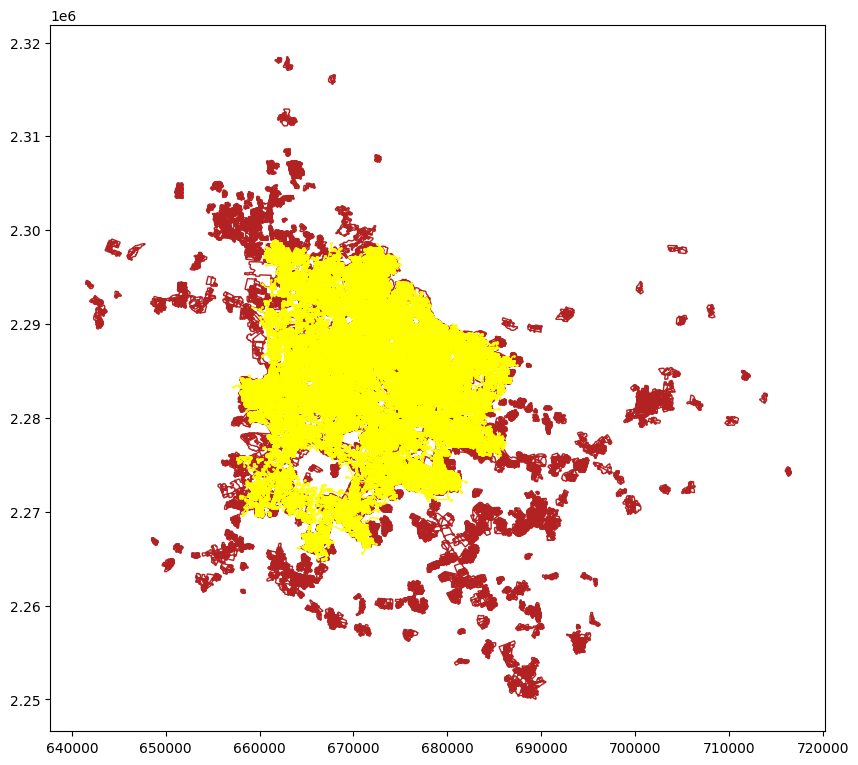

In [24]:
# Plot
fig,ax = plt.subplots(1,1,figsize=(10,20))

boeing_nodes.plot(ax=ax,zorder=3,color='yellow',markersize=1)
boeing_edges.plot(ax=ax,zorder=2,color='yellow',linewidth=1)
tess_nodes.plot(ax=ax,zorder=1,color='firebrick',markersize=1)
tess_edges.plot(ax=ax,zorder=0,color='firebrick',linewidth=1)

In [25]:
if localsave_01_01:
    boeing_nodes.to_file(output_dir + "part01_step01_preprocess/boeing_nodes.gpkg")
    boeing_edges.to_file(output_dir + "part01_step01_preprocess/boeing_edges.gpkg")
    tess_nodes.to_file(output_dir + "part01_step01_preprocess/tess_nodes.gpkg")
    tess_edges.to_file(output_dir + "part01_step01_preprocess/tess_edges.gpkg")

## __Part 01 - Step 01__ - Identify the parts of the Tessellations network that should be added to the Boeing network

This step identifies identifies the parts of the Tessellations network that should be added to the boeing network through the following steps:

base_network: boeing
complementary_network: tessellations

1. Extract the midpoint of each complementary edge
2. Create a contact-analysis buffer around mid_points
3. Find mid_points whose buffer does not intersect with any part of the base network
4. Select the complementary_nodes that connect to the uncovered edges found
5. Find the nodes that would be used to connect the uncovered part of the complementary network to the base network
6. Identify and shorten edges that extend into the base network and would be useful to create further connections

In [26]:
load_previous_step = False
if load_previous_step:
    boeing_nodes = gpd.read_file(output_dir + "part01_step01_preprocess/boeing_nodes.gpkg")
    boeing_edges = gpd.read_file(output_dir + "part01_step01_preprocess/boeing_edges.gpkg")
    tess_nodes = gpd.read_file(output_dir + "part01_step01_preprocess/tess_nodes.gpkg")
    tess_edges = gpd.read_file(output_dir + "part01_step01_preprocess/tess_edges.gpkg")

In [47]:
# Run identify_uncovered function
distance = 10
complementary_uncovered_nodes, complementary_uncovered_edges, contact_nodes, dropped_overlapping_edges = identify_uncovered_v2(base_nodes = boeing_nodes,
                                                                                                                               base_edges = boeing_edges,
                                                                                                                               complementary_nodes = tess_nodes,
                                                                                                                               complementary_edges = tess_edges,
                                                                                                                               contact_analysis_dist = distance,
                                                                                                                               projected_crs = projected_crs)

1.0 - Extracting mid_point point of each complementary edge.
2.0 - Creating contact-analysis buffer around each mid_point.
3.0 - Extracting complementary_uncovered_edges.
4.0 - Extracting complementary_uncovered_nodes.
5.0 - Extracting contact_nodes.
6.0 - Creating missing connections through complementary_edges that travel from the uncovered zone to the base network.
6.0 - Exploring osmids. 0% done.
Tried shortening 50 times edge u 661842822826161 and v 661932022826160. Stopped.
Tried shortening 50 times edge u 672535722718791 and v 672522422718302. Stopped.
Tried shortening 50 times edge u 663568322841640 and v 663649822841603. Stopped.
Tried shortening 50 times edge u 681223222787342 and v 681220622786320. Stopped.
Tried shortening 50 times edge u 679366422831363 and v 679428122831085. Stopped.
Tried shortening 50 times edge u 673213322918165 and v 673213722918554. Stopped.
6.0 - Reused contact node 236.0 for original edge 6634220228539196634848228536330.
Tried shortening 50 times e

In [48]:
if localsave_01_02:
    complementary_uncovered_nodes.to_file(output_dir + "part01_step02_identifyuncovered/complementary_uncovered_nodes.gpkg")
    complementary_uncovered_edges.to_file(output_dir + "part01_step02_identifyuncovered/complementary_uncovered_edges.gpkg")
    contact_nodes.to_file(output_dir + "part01_step02_identifyuncovered/contact_nodes.gpkg")
    dropped_overlapping_edges.to_file(output_dir + "part01_step02_identifyuncovered/dropped_overlapping_edges.gpkg")

## __Part 02 - Step 01 -__ Networks intersection

This step __finds the intersection points existing__ between the base network and the uncovered parts of the complementary network, and then modifies both network in order to __incorporate the intersection points as new nodes__ on both networks.

In [32]:
load_previous_step = False
if load_previous_step:
    boeing_nodes = gpd.read_file(output_dir + "part01_step01_preprocess/boeing_nodes.gpkg")
    boeing_edges = gpd.read_file(output_dir + "part01_step01_preprocess/boeing_edges.gpkg")
    complementary_uncovered_nodes = gpd.read_file(output_dir + "part01_step02_identifyuncovered/complementary_uncovered_nodes.gpkg")
    complementary_uncovered_edges = gpd.read_file(output_dir + "part01_step02_identifyuncovered/complementary_uncovered_edges.gpkg")
    contact_nodes = gpd.read_file(output_dir + "part01_step02_identifyuncovered/contact_nodes.gpkg")

In [33]:
intersection_nodes = find_intersection_nodes(ntw_01_nodes = boeing_nodes,
                                             ntw_01_edges = boeing_edges,
                                             ntw_02_nodes = complementary_uncovered_nodes,
                                             ntw_02_edges = complementary_uncovered_edges,
                                             projected_crs = projected_crs)

# Show
print(intersection_nodes.shape)
intersection_nodes.head(2)

Intersected networks and created intersection_points.
Set unique osmids to all intersection_points. Turned into intersection_nodes.
(9971, 8)


,u_1,v_1,key_1,u_2,v_2,key_2,geometry,osmid
0,673954622869722,673868422866935,0,673899422867916,674035422867542,0,POINT (673899.910 2286791.799),0
1,674002922866530,674093922869429,0,673899422867916,674035422867542,0,POINT (674034.687 2286754.318),1


In [34]:
# MULTIPLE INTERSECTIONs (Intersections where three or more lines cross at the same point)
mult_inters_nodes = intersection_nodes.loc[intersection_nodes.duplicated('osmid',keep=False)].copy()
print(f"Mult. int. osmids: {mult_inters_nodes.osmid.unique()}.")

# Save them (GIS Visualization)
save_mult_intrs_nodes = False
if save_mult_intrs_nodes:
    mult_inters_nodes.to_file(output_dir + "part02_step01_ntwsintersection/multiple_intersection_nodes.gpkg")
    
# Show
mult_inters_nodes

Mult. int. osmids: [ 5487  5690  5801  6286  6639  6834  7065  7459  7571  7579  7673  8008
  8148  8229  8399  8451  8456  8518  8545  8570  8728  8747  8924  8950
  8985  9013  9049  9072  9075  9077  9082  9189  9436  9482  9557  9787
 10094 10100 10430 10794 10890 10978 11245 11318 11373 11390 11896 12072
 12303 12479 12615 12724 13073 13205 13624 13681 13958 13961 14043 14077
 14446 14470 14511 14639 14668 14794 14933 15105 15235 15266].


,u_1,v_1,key_1,u_2,v_2,key_2,geometry,osmid
117,663440822853837,663462422854429,0,663465122854289,663503722853813,0,POINT (663465.331 2285428.930),5487
120,663440822853837,663462422854429,0,663465122854289,663515322854438,0,POINT (663465.331 2285428.930),5487
320,682529422868773,682469122869682,0,682389522871629,682522322868854,0,POINT (682523.214 2286887.053),5690
431,674147622908066,674153122908573,0,674104522908585,674155422908441,0,POINT (674151.886 2290845.803),5801
432,674147622908066,674153122908573,0,674155422908441,674146822908989,0,POINT (674151.886 2290845.803),5801
...,...,...,...,...,...,...,...,...
9865,672493322723151,672561222722301,0,672484422722742,672550922722466,0,POINT (672547.271 2272244.898),15235
9866,672493322723151,672561222722301,0,672550922722466,672532022722069,0,POINT (672547.271 2272244.898),15235
9896,673288922909920,673323622909659,0,673311722909212,673339122909642,0,POINT (673339.147 2290964.063),15266
9898,673288922909920,673323622909659,0,673339122909642,673375422909385,0,POINT (673339.147 2290964.063),15266


In [35]:
# Separate intersection_nodes in order to apply function network_intersections_update() for the base network
intersection_nodes_base = intersection_nodes[['osmid','u_1','v_1','key_1','geometry']].copy()
intersection_nodes_base.rename(columns={'u_1':'u',
                                        'v_1':'v',
                                        'key_1':'key'},inplace=True)
# Specify which edge to keep after spliting each edge with the intersection_nodes_base
# ('both' keeps both sides of split, 'u' or 'v' only keeps the side connected to that node.)
# ('both' activates 'return_all' in function edge_clipping())
intersection_nodes_base['retain_how'] = 'both'

##### Time
time_1 = time.time()
##### Time
# Apply network_intersections_update() function
base_nodes_i, base_edges_i = network_intersections_update(current_ntw_nodes = boeing_nodes,
                                                          current_ntw_edges = boeing_edges,
                                                          intersection_nodes = intersection_nodes_base,
                                                          projected_crs = projected_crs,
                                                          intersection_logs = False,
                                                          clipping_logs=False)
##### Time
time_2 = time.time()
print(f"TIME: {time_2-time_1} seconds on updating the network.")
##### Time

# MULTIPLE INTERSECTION ADAPTATION: drop duplicates
# Duplicated nodes and edges may occur when three or more lines cross at the same point.
# Regular .drop_duplicates() cannot be used since edges could be mirrored.
# Example:
#        Line 1: u=1, v=2, key=0, geom=((1,1),(2,1))
#        Line 2: u=2, v=1, key=0, geom=((2,1),(1,1))
# Drop nodes and edges duplicates
base_nodes_i,base_edges_i = drop_intersection_network_duplicates(base_nodes_i,base_edges_i)

##### Time
time_3 = time.time()
print(f"TIME: {time_3-time_2} seconds on dropping network duplicates.")
##### Time

# Show
print(base_nodes_i.shape)
base_nodes_i.head(2)

Updating network...
edge_clipping(): Found line containing coords close to starting_point_coords (665057.7943277379, 2287248.335533054). Distance: 0.0.
edge_clipping(): Line found: [(665057.794327737, 2287248.3355330545), (665056.5983523236, 2287249.45374172), (665052.4935317723, 2287252.624267477), (665048.4330883084, 2287255.5184497656), (665031.9522158089, 2287265.9746700265), (665017.545262725, 2287272.1112833), (665008.3994200415, 2287275.0997344884), (664998.5125624577, 2287277.1509809582), (664953.1184387004, 2287284.4575394085), (664930.4739174098, 2287288.0670916024), (664908.5119039025, 2287294.3404000527), (664752.2838272281, 2287341.593700869)].
edge_clipping(): Found line containing coords close to starting_point_coords (665719.9524127278, 2286002.0793167753). Distance: 0.0.
edge_clipping(): Line found: [(665719.9524127281, 2286002.0793167744), (665735.4217955542, 2285961.042644975)].
edge_clipping(): Found line containing coords close to starting_point_coords (665047.2563

,osmid,intersecting,geometry
0,676378722911448,0,POINT (676378.709 2291144.858)
1,675314522899288,0,POINT (675314.534 2289928.819)


In [36]:
# Show
print(base_edges_i.shape)
base_edges_i.head(2)

(132282, 5)


,u,v,key,intersecting,geometry
0,676378722911448,676400122911492,0,0,"LINESTRING (676378.709 2291144.858, 676386.243..."
1,676328522909849,676378722911448,0,0,"LINESTRING (676328.534 2290984.966, 676375.494..."


In [39]:
# Separate intersection_nodes in order to apply function network_intersections_update() for the complementary network.
intersection_nodes_comp = intersection_nodes[['osmid','u_2','v_2','key_2','geometry']].copy()
intersection_nodes_comp.rename(columns={'u_2':'u',
                                        'v_2':'v',
                                        'key_2':'key'},inplace=True)

# Specify which edge to keep after spliting each edge with the intersection_nodes_comp
# ('both' keeps both sides of split, 'u' or 'v' only keeps the side connected to that node.)
# ('both' activates 'return_all' in function edge_clipping())
intersection_nodes_comp['retain_how'] = 'both'

##### Time
time_1 = time.time()
##### Time

# Apply network_intersections_update() function
comp_nodes_i, comp_edges_i = network_intersections_update(current_ntw_nodes = complementary_uncovered_nodes,
                                                          current_ntw_edges = complementary_uncovered_edges,
                                                          intersection_nodes = intersection_nodes_comp,
                                                          projected_crs = projected_crs,
                                                          intersection_logs = False,
                                                          clipping_logs=False)

##### Time
time_2 = time.time()
print(f"TIME: {time_2-time_1} seconds on updating the network.")
##### Time

# MULTIPLE INTERSECTION ADAPTATION: drop duplicates
# Duplicated nodes and edges may occur when three or more lines cross at the same point.
# Regular .drop_duplicates() cannot be used since edges could be mirrored.
# Example:
#        Line 1: u=1, v=2, key=0, geom=((1,1),(2,1))
#        Line 2: u=2, v=1, key=0, geom=((2,1),(1,1))
# Drop nodes and edges duplicates
comp_nodes_i,comp_edges_i = drop_intersection_network_duplicates(comp_nodes_i,comp_edges_i)

##### Time
time_3 = time.time()
print(f"TIME: {time_3-time_2} seconds on dropping network duplicates.")
##### Time

# Show
print(comp_nodes_i.shape)
comp_nodes_i.head(2)

Updating network...
network_intersections_update(): Iterating over intersection_nodes. 0% done.
network_intersections_update(): Iterating over intersection_nodes. 10% done.
network_intersections_update(): Iterating over intersection_nodes. 20% done.
network_intersections_update(): Iterating over intersection_nodes. 30% done.
network_intersections_update(): Iterating over intersection_nodes. 40% done.
network_intersections_update(): Iterating over intersection_nodes. 50% done.
network_intersections_update(): Iterating over intersection_nodes. 60% done.
network_intersections_update(): Iterating over intersection_nodes. 70% done.
network_intersections_update(): Iterating over intersection_nodes. 80% done.
network_intersections_update(): Iterating over intersection_nodes. 90% done.
Finished updating network.
TIME: 612.7319407463074 seconds on updating the network.
Dropping duplicated osmids: [5487, 5801, 6286, 6639, 6834, 7571, 7673, 7579, 8008, 8148, 8229, 8451, 8518, 8545, 8570, 8728, 89

,osmid,intersecting,geometry
0,641505122944374,0,POINT (641505.100 2294437.443)
1,641628122944134,0,POINT (641628.114 2294413.478)


In [40]:
comp_edges_i.loc[(comp_edges_i.u==5487)|(comp_edges_i.v==5487)]

,u,v,key,intersecting,geometry
58758,663465122854289,5487,0,1,"LINESTRING (663465.188 2285428.902, 663465.331..."
58759,5487,5486,0,1,"LINESTRING (663465.331 2285428.930, 663467.082..."
58764,5487,663515322854438,0,1,"LINESTRING (663465.331 2285428.930, 663467.082..."


In [41]:
print(comp_edges_i.shape)
comp_edges_i.head(2)

(76120, 5)


,u,v,key,intersecting,geometry
0,641505122944374,641628122944134,0,0,"LINESTRING (641505.100 2294437.443, 641505.526..."
1,641505122944374,641630622946394,0,0,"LINESTRING (641505.100 2294437.443, 641503.983..."


In [42]:
if localsave_02_01:
    intersection_nodes.to_file(output_dir + "part02_step01_ntwsintersection/networks_intersections.gpkg") 
    base_nodes_i.to_file(output_dir + "part02_step01_ntwsintersection/intersected_base_nodes.gpkg")
    base_edges_i.to_file(output_dir + "part02_step01_ntwsintersection/intersected_base_edges.gpkg")
    comp_nodes_i.to_file(output_dir + "part02_step01_ntwsintersection/intersected_comp_nodes.gpkg")
    comp_edges_i.to_file(output_dir + "part02_step01_ntwsintersection/intersected_comp_edges.gpkg")

## __Part 02 - Step 02 -__ Connection identification between networks

Through identifying the __nearest base_nodes_i and nearest base_edges_i to each contact_node__, this section creates a gdf that __stablishes the relationships__ between each contact_node (That all derive complementary network) and the node or edge on the boeing network were the connection will be later created.

If the connection is to be made __from contact_node to base_edge__, it identifies the best intersection point and saves the point with a new osmid in order to split the boeing_edge and __create a new base node__ there in an update network process.

In [43]:
load_previous_step = False
if load_previous_step:
    # From Part01 - Step02
    contact_nodes = gpd.read_file(output_dir + "part01_step02_identifyuncovered/contact_nodes.gpkg")
    # From Part02 - Step01
    base_nodes_i = gpd.read_file(output_dir + "part02_step01_ntwsintersection/intersected_base_nodes.gpkg")
    base_edges_i = gpd.read_file(output_dir + "part02_step01_ntwsintersection/intersected_base_edges.gpkg")
    comp_nodes_i = gpd.read_file(output_dir + "part02_step01_ntwsintersection/intersected_comp_nodes.gpkg")
    comp_edges_i = gpd.read_file(output_dir + "part02_step01_ntwsintersection/intersected_comp_edges.gpkg")

### __Part 02 - Step 02 -__ Find nearest base_nodes_i and nearest base_edges_i to each contact_node.

In [44]:
# Retrieve contact_nodes
print(contact_nodes.shape)
contact_nodes.head(2)

(17456, 3)


,osmid,geometry,clipping_i
0,6.576671e+14,POINT (657667.170 2275162.714),0.0
1,6.575581e+14,POINT (657558.129 2275720.534),0.0


In [45]:
# Find nearest base_node to each contact_node
nearest_nodes = gpd.sjoin_nearest(contact_nodes, base_nodes_i, distance_col='node_distance')
# Merge nearest data
contact_nodes_1 = contact_nodes.merge(nearest_nodes[['osmid_right','node_distance']],left_index=True,right_index=True,how='outer')
# Save disk space
del nearest_nodes

# Show
print(contact_nodes_1.dtypes)
print(contact_nodes_1.shape)
contact_nodes_1.head(2)

osmid             float64
geometry         geometry
clipping_i        float64
osmid_right         int64
node_distance     float64
dtype: object
(17456, 5)


,osmid,geometry,clipping_i,osmid_right,node_distance
0,6.576671e+14,POINT (657667.170 2275162.714),0.0,657668122751614,1.600186
1,6.575581e+14,POINT (657558.129 2275720.534),0.0,657567822757211,9.759067


In [46]:
# Find nearest base_edge to each contact_node
nearest_edges = gpd.sjoin_nearest(contact_nodes, base_edges_i, distance_col='edge_distance')
# It is unlikely that two edges are exacly at the same distance.
# If this happens it most likely means that are at the same distance because they meet at a node
# and the closest distance is exactly that point.
# --> Keep the first occurance
nearest_edges = nearest_edges.drop_duplicates(subset='osmid')

# Merge nearest data
contact_nodes_2 = contact_nodes_1.merge(nearest_edges[['u','v','key','edge_distance']],left_index=True,right_index=True,how='outer')
# Save disk space
del nearest_edges

# Show
print(contact_nodes_2.dtypes)
print(contact_nodes_2.shape)
contact_nodes_2.head(2)

osmid             float64
geometry         geometry
clipping_i        float64
osmid_right         int64
node_distance     float64
u                   int64
v                   int64
key                 int64
edge_distance     float64
dtype: object
(17456, 9)


,osmid,geometry,clipping_i,osmid_right,node_distance,u,v,key,edge_distance
0,6.576671e+14,POINT (657667.170 2275162.714),0.0,657668122751614,1.600186,13320,657668122751614,0,1.583608
1,6.575581e+14,POINT (657558.129 2275720.534),0.0,657567822757211,9.759067,657567822757211,657565922756785,0,9.699738


### __Part 02 - Step 02 -__ Define the best relation between networks for each contact_node.

In [47]:
# Find individual relations between contact_nodes_2 (renamed as connecting_nodes) and network 01 (base network).
# (Produces "connected_nodes" gdf, where these relations are saved, and also
# produces "intersection_nodes_2" gdf, which stores new nodes and edges to be split on network 01)

# Rename gdfs to keep original (Used during Dev)
ntw_01_nodes = base_nodes_i.copy()
ntw_01_edges = base_edges_i.copy()
ntw_02_nodes = comp_nodes_i.copy()
ntw_02_edges = comp_edges_i.copy()
connecting_nodes = contact_nodes_2.copy()

# Reset produced osmids (Used in function produce_osmid())
previously_produced = 0

# List of nodes created by intersecting both networks
# (They are used to discard the creation of new intersections whenever 
#  nerby (20m) there's already an existing intersection between both networks)
intersecting_idx = ntw_01_nodes.intersecting==1
intersecting_osmids = list(ntw_01_nodes.loc[intersecting_idx].osmid.unique())

# GeoDataFrame that will store the final defined connections between networks
connected_nodes = pd.DataFrame()

# Second round of intersections to be created on network_01 (after this process)
intersection_nodes_2 = gpd.GeoDataFrame()
new_node_idx = 0 #idx of the gdf

extended_logs = False # Used during Dev. Prints logs for each node.

i = 0 #Helps identify the row where data will be added on connected_nodes df.

# Iterate over each connecting_node
for idx, node in connecting_nodes.iterrows():

    # Extract current connecting_node's data
    # Current connecting_node data [From ntw_02]
    cn_osmid = node.osmid 
    cn_geometry = node.geometry
    # nearest_node data [From ntw_01]
    cn_nearest_osmid = node.osmid_right
    cn_node_distance = node.node_distance 
    # nearest_edge data [From ntw_01]
    cn_nearest_u = node.u
    cn_nearest_v = node.v
    cn_nearest_key = node.key
    cn_edge_distance = node.edge_distance

    # Development checks -----------------------------------
    #osmid_checks = [1089,1090]
    #if cn_osmid not in osmid_checks:
    #    continue
    #else:
    #    print(cn_osmid)
    # Development checks -----------------------------------
    
    # Register current connecting_node
    connected_nodes.loc[i,'connecting_ntw02_osmid'] = cn_osmid
    
    # 1.0 --------------- CASE 1: Close intersection, discards connecting_node
    # ------------------- This case analyses the edges that connect to the current connecting_node.
    # ------------------- If there's already an intersection to the base network in 20 meters or less,
    # ------------------- assume this intersection could sustitute the connection that was going to be created.
    # ------------------- (Meaning, there's already a connection nearby, creating another would be redundant)
    # ------------------- --> ignore connecting_node (continue).

    # Identify the edges that connect to the current connecting_node
    connecting_node_edges = ntw_02_edges.loc[(ntw_02_edges.u==cn_osmid) | (ntw_02_edges.v==cn_osmid)].copy()
    # Extract the list of nodes ('u' and 'v') that those edges connect to
    connecting_node_osmids = set(list(connecting_node_edges.u.unique()) + list(connecting_node_edges.v.unique()))
    connecting_node_osmids.remove(cn_osmid) #Remove itself
    # From those connecting_node_osmids, extract those that are also intersecting_osmid (That intersect the network 01)    
    opposite_intersecting_osmid = [osmid for osmid in connecting_node_osmids if osmid in intersecting_osmids]
    # If they exist:
    if len(opposite_intersecting_osmid)>0:
        # Set connection to False until distance is verified
        existing_connection = False
        # Analyse the length of the edges connecting to the opposite_intersecting_osmids. 
        # For any edge connecting to an intersecting_node, if the length of that edge is less than 20 meters, 
        # register that there's already an existing connection nerby.
        edges_to_analyse = connecting_node_edges.loc[(connecting_node_edges.u.isin(opposite_intersecting_osmid)) | 
                                                     (connecting_node_edges.v.isin(opposite_intersecting_osmid))].copy()
        edges_to_analyse['length'] = edges_to_analyse.length
        for edge_length in list(edges_to_analyse.length.unique()):
            if edge_length < 20:
                existing_connection = True
                break
        # If the process found an existing connection, skip current connecting_node.
        # Else, goes to CASE 2.
        if existing_connection == True:
            connected_nodes.loc[i,'connection_type'] = 'existing'
            i+=1
            if extended_logs:
                print(f"CASE 1: Connecting node {cn_osmid} already connects to an existing intersection in less than 20 meters.")
            continue # Next connecting_node
    
    # 2.0 --------------- CASE 2: Distance analysis
    # ------------------- If there's no existing intersection nerby, register connection to be created.
    
    # 2.1 --------------- New nodes check (If complies with a set of conditions, updates cn_nearest_osmid and cn_node_distance)
    # ------------------- The for loop iterating over connecting_nodes has a code section where new nodes can be created.
    # ------------------- This happens when a connection between a conecting_node and a ntw_01_edge is stablished.
    # ------------------- New nodes can also serve as a connection with between networks
    # ------------------- Considering them prevents multiple connections being created when an existing can be used.

    # IN CASE OF OTHER APPROACH NEEDED [COMMENT STARTS]
    # If the case appears, where connecting_node could have had a better connection with a
    # new_node, but it was not considered because the new_node was not located in the nearest edge,
    # consider editing this part of the code so that the check for new nodes is made through a buffer.
    # 1. Find if there are any new nodes in a __x__ meter buffer.
    # 2. If there are, measure distance to all of them and choose the min distance
    # 3. Compare min distance to current distance to nearest node
    # 4. If less, assign new_node as new nearest node.
    # IN CASE OF OTHER APPROACH NEEDED [COMMENT ENDS]
    
    # Extract nearest edge's unique_id
    cn_edge_id = str(cn_nearest_u)+str(cn_nearest_v)+str(cn_nearest_key)
    # If there are already new_nodes registered, analyse distance to them. Else, skip.
    if new_node_idx > 0:
        # Check if this edge has already been used to stablish a connection with another connecting_node.
        # If so, a new_node will be created over this edge and that new_node could be used as a connection instead of creating another one.
        # So, if this edge is already registered in intersection_nodes_2, consider the new_node.
        intersected_edges = list(intersection_nodes_2['edge_id'].unique())
        if cn_edge_id in intersected_edges:
            # Obtain current conecting_node's coordinates
            conecting_nodes_coords = cn_geometry.coords[0]
            # Retrieve new_nodes (registered_nodes)
            registered_nodes = intersection_nodes_2.loc[intersection_nodes_2['edge_id'] == cn_edge_id].copy()
            registered_nodes.reset_index(inplace=True,drop=True)
            for node_idx in range(len(registered_nodes)):
                # Obtain registered node's coords
                registered_node = registered_nodes.iloc[node_idx]
                registered_node_coords = registered_node.geometry.coords[0]
                # Calculate distance between both nodes
                new_node_distance = distance_between_points(conecting_nodes_coords, registered_node_coords)
                # If new_node_distance is less than distance to current nearest node, update nearest node data
                if new_node_distance < cn_node_distance:
                    cn_nearest_osmid = registered_node.osmid
                    cn_node_distance = new_node_distance
    
    # 2.2 --------------- CASE 2a: Close node connection
    # If distance to nearest node is less or equal to 5 meters, register that connection (Ignores closest edge, takes closest node)
    if cn_node_distance<=5:
        # Connection registration
        connected_nodes.loc[i,'connection_type'] = 'node'
        connected_nodes.loc[i,'connection_ntw01_osmid'] = cn_nearest_osmid
        i+=1
        if extended_logs:
            print(f"CASE 2a: Connecting node {cn_osmid} connects to a node in less than 5 meters.")
        continue # Next connecting_node

    # If distance to nearest node is greater than 5 meters, analyse distance to edge
    elif cn_node_distance>5:
        
        # 2.3 --------------- CASE 2b: Edge connection
        # If the nearest_edge is closer than the (nearest_node-5 meters)
        # (Meaning, if the nearest_edge is closer even when we give 5 meter preference to the node over the edge) 
        # --> Create and register join with nearest_edge.
        node_distance_pref = cn_node_distance-5
        if cn_edge_distance < node_distance_pref:

            # 2.3.1 ------------- Create new node
            # Extract the nearest edge's geometry (LineString)
            nearest_edge = ntw_01_edges.loc[(ntw_01_edges.u==cn_nearest_u) & 
                                            (ntw_01_edges.v==cn_nearest_v) &
                                            (ntw_01_edges.key==cn_nearest_key)].copy()
            nearest_edge.reset_index(inplace=True,drop=True)
            edge_geom = nearest_edge['geometry'].unique()[0]
            # Project current connecting_node into the edge's geometry
            projected_point = edge_geom.interpolate(edge_geom.project(cn_geometry))
            # Produce unique osmid
            produced_osmid = produce_osmid(ntw_01_nodes, ntw_02_nodes, previously_produced)
            # Since ntw_01_nodes and ntw_02_nodes are not being updated, next time (whenever another node falls in this case)
            # will try function produce_osmid() with next possible osmid.
            previously_produced = produced_osmid+1
            # Create new node on projected point
            new_node = gpd.GeoDataFrame()
            new_node.loc[0,'osmid'] = produced_osmid
            new_node.loc[0,'geometry'] = projected_point
            new_node = new_node.set_crs(projected_crs)
            
            # 2.3.2 ------------- Register new_node and edge to be split by it.
            # ------------------- Will be used in function network_intersections_update()
            # Node that is the intersection (clipping point)
            intersection_nodes_2.loc[new_node_idx,'osmid'] = produced_osmid
            intersection_nodes_2.loc[new_node_idx,'geometry'] = projected_point
            # Edge that is intersected
            intersection_nodes_2.loc[new_node_idx,'u'] = cn_nearest_u
            intersection_nodes_2.loc[new_node_idx,'v'] = cn_nearest_v
            intersection_nodes_2.loc[new_node_idx,'key'] = cn_nearest_key
            # Edge id that is intersected (for 2.1 -- New nodes check)
            intersection_nodes_2.loc[new_node_idx,'edge_id'] = cn_edge_id
            
            # Register crs (first time only)
            if new_node_idx==0:
                intersection_nodes_2 = intersection_nodes_2.set_crs(projected_crs)
            # Next idx
            new_node_idx+=1

            # 2.3.3 ------------- Connection registration
            connected_nodes.loc[i,'connection_type'] = 'node'
            connected_nodes.loc[i,'connection_ntw01_osmid'] = produced_osmid
            i+=1
            if extended_logs:
                print(f"CASE 2b: Connecting node {cn_osmid} produced a new node in an edge of the network 01.")
            continue # Next connecting_node

        # 2.4 --------------- CASE 2c: Node connection
        # If the (nearest_node-5 meters) is closer than the nearest_edge
        # --> Register node connection
        else:
            # Connection registration
            connected_nodes.loc[i,'connection_type'] = 'node'
            connected_nodes.loc[i,'connection_ntw01_osmid'] = cn_nearest_osmid
            i+=1
            if extended_logs:
                print(f"CASE 2c: Connecting node {cn_osmid} connects to a node in less than 5 meters.")
            continue # Next connecting_node

# Final format (Set unique identifiers to int) to connected_nodes's columns
connected_nodes['connecting_ntw02_osmid'] = connected_nodes['connecting_ntw02_osmid'].astype('int')
connected_nodes['connection_ntw01_osmid'].fillna(value=0, inplace=True)# Existing connections do not register osmid, set to 0
connected_nodes['connection_ntw01_osmid'] = connected_nodes['connection_ntw01_osmid'].astype('int')
# Final format (Set unique identifiers to int) to intersection_nodes_2's columns
intersection_nodes_2['osmid'] = intersection_nodes_2['osmid'].astype('int')
intersection_nodes_2['u'] = intersection_nodes_2['u'].astype('int')
intersection_nodes_2['v'] = intersection_nodes_2['v'].astype('int')
intersection_nodes_2['key'] = intersection_nodes_2['key'].astype('int')

# Show
print(connected_nodes.dtypes)
print(connected_nodes.shape)
connected_nodes.head(2)

connecting_ntw02_osmid     int64
connection_type           object
connection_ntw01_osmid     int64
dtype: object
(17456, 3)


,connecting_ntw02_osmid,connection_type,connection_ntw01_osmid
0,657667122751627,node,657668122751614
1,657558122757205,node,657567822757211


In [48]:
# Show gdf that will be used to update network 01 (base_network)
print(intersection_nodes_2.dtypes)
print(intersection_nodes_2.shape)
print("These intersections (A specific osmid crossing at a specific edge_id) should not have duplicates.")
print(f"Intersections duplicates: {len(intersection_nodes_2.loc[intersection_nodes_2.duplicated(subset=['osmid','edge_id'])])}.")
intersection_nodes_2.head(2)

osmid          int64
geometry    geometry
u              int64
v              int64
key            int64
edge_id       object
dtype: object
(5974, 6)
These intersections (A specific osmid crossing at a specific edge_id) should not have duplicates.
Intersections duplicates: 0.


,osmid,geometry,u,v,key,edge_id
0,5490,POINT (657648.680 2275693.195),657567822757211,657694422756260,0,6575678227572116576944227562600
1,5802,POINT (657889.332 2271585.175),11342,657856922715073,0,113426578569227150730


## __Part 2 - Step 03 -__ Network concatenation

This step __updates the base network__ (In order to include the new nodes created in order to join a contact_node and a base_edge) and __joins (concatenates) both network's nodes and edges__ into a single gdf each.

### __Part 02 - Step 03 -__ Re-update the network 01 (Base network)

In [49]:
# Apply network_intersections_update() function

# Specify which edge to keep after spliting each edge with the intersection_nodes_2
# ('both' keeps both sides of split, 'u' or 'v' only keeps the side connected to that node.)
# ('both' activates 'return_all' in function edge_clipping())
intersection_nodes_2['retain_how'] = 'both'

# (Second round of intersections, derived from new nodes created from network_02 to edges on network_01)
base_nodes_i2, base_edges_i2 = network_intersections_update(current_ntw_nodes = base_nodes_i,
                                                            current_ntw_edges = base_edges_i,
                                                            intersection_nodes = intersection_nodes_2,
                                                            projected_crs = projected_crs,
                                                            intersection_logs = False,
                                                            clipping_logs=False)

# Nodes marked as "intersecting" on this round are nodes created specifically in order to connect the
# network_02 to an edge on network_01. Distinguish them (For GIS visualization)
base_nodes_i2.rename(columns={'intersecting':'ntw_join'},inplace=True)

# Show
print(base_nodes_i2.dtypes)
print(base_nodes_i2.shape)
base_nodes_i2.head(2)

Updating network...
network_intersections_update(): Iterating over intersection_nodes. 0% done.
network_intersections_update(): Iterating over intersection_nodes. 10% done.
network_intersections_update(): Iterating over intersection_nodes. 20% done.
network_intersections_update(): Iterating over intersection_nodes. 30% done.
network_intersections_update(): Iterating over intersection_nodes. 40% done.
network_intersections_update(): Iterating over intersection_nodes. 50% done.
network_intersections_update(): Iterating over intersection_nodes. 60% done.
network_intersections_update(): Iterating over intersection_nodes. 70% done.
network_intersections_update(): Iterating over intersection_nodes. 80% done.
network_intersections_update(): Iterating over intersection_nodes. 90% done.
Finished updating network.
osmid          int64
ntw_join       int64
geometry    geometry
dtype: object
(98566, 3)


,osmid,ntw_join,geometry
0,676378722911448,0,POINT (676378.709 2291144.858)
1,675314522899288,0,POINT (675314.534 2289928.819)


In [50]:
# Show base_nodes tail detail
print(f"Nodes duplicates: {len(base_nodes_i2.loc[base_nodes_i2.duplicated(subset=['osmid'])])}.")
base_nodes_i2.tail(2)

Nodes duplicates: 0.


,osmid,ntw_join,geometry
98564,21243,1,POINT (671221.430 2278457.980)
98565,21244,1,POINT (680260.936 2287878.896)


In [51]:
# Show base_edges
print(base_edges_i2.dtypes)
base_edges_i2.head(2)

u                  int64
v                  int64
key                int64
intersecting       int64
geometry        geometry
dtype: object


,u,v,key,intersecting,geometry
0,676378722911448,676400122911492,0,0,"LINESTRING (676378.709 2291144.858, 676386.243..."
1,676328522909849,676378722911448,0,0,"LINESTRING (676328.534 2290984.966, 676375.494..."


In [52]:
# Show base_edges tail detail
test_base_edges_i2 = base_edges_i2.copy()
test_base_edges_i2 = create_unique_edge_id(test_base_edges_i2)
print(f"Edges duplicates: {len(test_base_edges_i2.loc[test_base_edges_i2.duplicated(subset=['edge_id'])])}.")
del test_base_edges_i2
base_edges_i2.tail(2)

Edges duplicates: 0.


,u,v,key,intersecting,geometry
138254,680242922878567,21244,0,1,"LINESTRING (680242.902 2287856.705, 680260.936..."
138255,21244,680277222878990,0,1,"LINESTRING (680260.936 2287878.896, 680277.283..."


In [53]:
# Show complementary_nodes
print(comp_nodes_i.dtypes)
print(comp_nodes_i.shape)
comp_nodes_i.head(2)

osmid              int64
intersecting       int64
geometry        geometry
dtype: object
(61465, 3)


,osmid,intersecting,geometry
0,641505122944374,0,POINT (641505.100 2294437.443)
1,641628122944134,0,POINT (641628.114 2294413.478)


In [54]:
# Show complementary_edges
print(comp_edges_i.dtypes)
print(comp_edges_i.shape)
comp_edges_i.head(2)

u                  int64
v                  int64
key                int64
intersecting       int64
geometry        geometry
dtype: object
(76120, 5)


,u,v,key,intersecting,geometry
0,641505122944374,641628122944134,0,0,"LINESTRING (641505.100 2294437.443, 641505.526..."
1,641505122944374,641630622946394,0,0,"LINESTRING (641505.100 2294437.443, 641503.983..."


In [55]:
# Show final defined relations between ntw02 --connecting--to--> ntw01 (connected_nodes df)
connected_nodes.head(2)

,connecting_ntw02_osmid,connection_type,connection_ntw01_osmid
0,657667122751627,node,657668122751614
1,657558122757205,node,657567822757211


### __Part 02 - Step 03 -__ Concatenate both networks (Not yet physically connected by edges)

In [56]:
# Concatenate nodes

# Prepare data for concatenation
ntw_01_nodes_prep = base_nodes_i2[['osmid','ntw_join','geometry']].copy()
ntw_02_nodes_prep = comp_nodes_i[['osmid','geometry']].copy()

# Add missing 'ntw_join' col to ntw_02_nodes_prep
ntw_02_nodes_prep['ntw_join'] = 0

# Differenciate networks's origin
ntw_01_nodes_prep['ntw_origin'] = 'ntw_01'
ntw_02_nodes_prep['ntw_origin'] = 'ntw_02'

# Concatenate nodes
concatenated_nodes = pd.concat([ntw_01_nodes_prep,ntw_02_nodes_prep])
node_count_1 = len(concatenated_nodes)

# Drop duplicated nodes
concatenated_nodes.drop_duplicates(subset=['osmid','geometry'],inplace=True)
node_count_2 = len(concatenated_nodes)
print(f"Both networks where sharing nodes where there is an intersection between networks. Duplicates were expected but no longer needed.")
print(f"Dropped {node_count_1-node_count_2} nodes duplicated when intersecting networks.")

# Reset index
concatenated_nodes.reset_index(inplace=True,drop=True)

# Show
print(concatenated_nodes.dtypes)
print(concatenated_nodes.shape)
concatenated_nodes.head(2)

Both networks where sharing nodes where there is an intersection between networks. Duplicates were expected but no longer needed.
Dropped 9901 nodes duplicated when intersecting networks.
osmid            int64
ntw_join         int64
geometry      geometry
ntw_origin      object
dtype: object
(150130, 4)


,osmid,ntw_join,geometry,ntw_origin
0,676378722911448,0,POINT (676378.709 2291144.858),ntw_01
1,675314522899288,0,POINT (675314.534 2289928.819),ntw_01


In [57]:
# Concatenate edges

# Prepare data for concatenation
ntw_01_edges_prep = base_edges_i2[['u','v','key','geometry']].copy()
ntw_02_edges_prep = comp_edges_i[['u','v','key','geometry']].copy()

# Add missing 'ntw_join' col to both gdfs
ntw_01_edges_prep['ntw_join'] = 0
ntw_02_edges_prep['ntw_join'] = 0

# Differenciate networks
ntw_01_edges_prep['ntw_origin'] = 'ntw_01'
ntw_02_edges_prep['ntw_origin'] = 'ntw_02'

# Concatenate edges
concatenated_edges = pd.concat([ntw_01_edges_prep,ntw_02_edges_prep])

# Drop duplicated edges ('u','v','key' and 'geometry' (There should be 0))
edge_count_1 = len(concatenated_edges)
concatenated_edges.drop_duplicates(subset=['u','v','key','geometry'],inplace=True)
edge_count_2 = len(concatenated_edges)
print(f"There should be 0 duplicated edges. Dropped {edge_count_1-edge_count_2}.")

# Fix shared edge_ids by re-assigning all 'key's for duplicated edges.
# An edge from network 01 might go from the same u to the same v as an edge from the network 02 if any (or both) of them were split by an intersection.
# If this happens, they would both have the same 'u', 'v' and 'key', but different paths (geometry).
# (This was first found on Part 01 - Step 00 - Load and preprocess networks, BEFORE intersecting (and editing) networks)
# The solution was integrated into function create_network() and is as follows:
extended_logs = False

# Find 'u', 'v' and 'key' duplicates in edges (Should never be the case)
duplicated_edges = concatenated_edges[concatenated_edges.duplicated(subset=['u', 'v', 'key'], keep=False)]
# Prepare registration_dict. Will hold unique 'u','v' and 'key' assigned.
registration_dict = {}
# For each duplicated edge found:
for index,row in duplicated_edges.iterrows():
    # Current 'u' and 'v'
    current_u = row['u']
    current_v = row['v']
    u_v_id = str(row['u'])+str(row['v'])

    # If current 'u' and 'v' are already registered
    if u_v_id in registration_dict:
        # Read key that has been assigned
        registered_key = registration_dict[u_v_id]
        # Create new unregistered unique key
        new_key = registered_key+1
        # Register new unique key and update dictionary
        concatenated_edges.loc[index,'key'] = new_key
        registration_dict[u_v_id] = new_key
        if extended_logs:
            print(f"Re-registered edge with u {current_u} and v {current_v} with key {new_key}.")

    # Else, it is the first time that this 'u' and 'v' is registered
    else:
        # Register new unique key and update dictionary
        concatenated_edges.loc[index,'key'] = 0
        registration_dict[u_v_id] = 0
        if extended_logs:
            print(f"Re-registered edge with u {current_u} and v {current_v} with key 0.")

print(f"Finished re-assigning 'key's. Fixed {len(registration_dict.keys())} cases with the same 'u' and 'v'.")
    
# Reset index
concatenated_edges.reset_index(inplace=True,drop=True)

# Show
print(concatenated_edges.dtypes)
print(concatenated_edges.shape)
concatenated_edges.head(2)

There should be 0 duplicated edges. Dropped 0.
Finished re-assigning 'key's. Fixed 138 cases with the same 'u' and 'v'.
u                int64
v                int64
key              int64
geometry      geometry
ntw_join         int64
ntw_origin      object
dtype: object
(214376, 6)


,u,v,key,geometry,ntw_join,ntw_origin
0,676378722911448,676400122911492,0,"LINESTRING (676378.709 2291144.858, 676386.243...",0,ntw_01
1,676328522909849,676378722911448,0,"LINESTRING (676328.534 2290984.966, 676375.494...",0,ntw_01


In [23]:
if localsave_02_03:
    connected_nodes.to_csv(output_dir + "part02_step03_ntwsconcat/connected_nodes_df.csv",index=False)
    concatenated_nodes.to_file(output_dir + "part02_step03_ntwsconcat/concatenated_nodes.gpkg")
    concatenated_edges.to_file(output_dir + "part02_step03_ntwsconcat/concatenated_edges.gpkg")

## __Part 02 - Step 04 -__ Connect networks

Using the connected_nodes df (Created in Part 02 - Step 02), which stablishes the relations between conection_nodes (from network 02, complementary network) and nodes in network 01 (base network), in this step __new edges that connect both networks are drawn.__

After that __consequential intersections__ (Which occur when the drawn edge crosses another edge in its way to connect network 01 and 02) __are fixed__ according to its nature (CASE A, CASE B or CASE C).

In [15]:
load_previous_step = True
if load_previous_step:
    # From Part02 - Step03
    connected_nodes= pd.read_csv(output_dir + "part02_step03_ntwsconcat/connected_nodes_df.csv")
    concatenated_nodes = gpd.read_file(output_dir + "part02_step03_ntwsconcat/concatenated_nodes.gpkg")
    concatenated_edges = gpd.read_file(output_dir + "part02_step03_ntwsconcat/concatenated_edges.gpkg")

### __Part 02 - Step 04 -__ Draw new edges and identify consequential intersections

In [29]:
casetype_logs = False

In [30]:
# Reset previously_produced osmids (Used in function produce_osmid())
previously_produced = 0

# Store the fixes to be performed (Used to fix consequential intersections)
intersection_nodes_3 = gpd.GeoDataFrame()
fix_idx = 0

# Store the osmids and edge_ids created to join both networks (To identify them after the process)
all_join_osmids = []
all_join_edgeids = []

# Consequential_intersections and its three cases (A, B and C) explanation.
# The concatenated_edges are renamed joined_edges_concat.
# The following code iterates over the connected_nodes df (The dataframe with defined relations between networks) and
# draws the new needed edges (when needed). The new edges sometimes intersect other edges as a consequence of them being straight lines between
# nodes. These new intersections are called consequential_intersections.
# The first connected_node explores consequential_intersections with the existing concatenated_edges (renamed as joined_edges_concat), but
# since the new-drawn-edge gets added to joined_edges_concat, the following connected_node also explores consequential_intersections with any
# recently-drawn edge. This results in cases A, B and C explored at the end of the for loop.

# Create joined_edges_concat with a column for edge_id
joined_edges_concat = create_unique_edge_id(concatenated_edges)

# LOG CODE - Progress logs
# Will create progress logs when progress reaches these percentages:
progress_logs = [0,10,20,30,40,50,60,70,80,90,100] # for log statistics
progress_count = 0
# LOG CODE - Progress logs

# Iterate over each relation stablished
for idx, connected_node in connected_nodes.iterrows():

    # LOG CODE - Progress logs
    # Measures current progress, prints if passed a checkpoint of progress_logs list.
    current_progress = (progress_count / len(connected_nodes))*100
    for checkpoint in progress_logs:
        if (current_progress >= checkpoint):
            print(f"Categorizing node relation types. {checkpoint}% done.")
            progress_logs.remove(checkpoint)
            break
    # LOG CODE - Progress logs
    
    current_osmid = connected_node.connecting_ntw02_osmid
    
    # Development checks -----------------------------------
    #osmid_checks = [1089,1090,1086,999,1027,229]
    #if current_osmid not in osmid_checks:
    #    continue
    #else:
    #    print(current_osmid)
    # Development checks -----------------------------------
    
    # Extract relation's data
    # The following words are used to refer to the origin of data:
    # 'connection' refers to the data from network 01,
    # while 'connecting' referes to data from network 02.
    # The reasoning used is that network 02 (complementary) is ---connecting--> to network 01 (base)
    connection_ntw01_osmid = connected_node.connection_ntw01_osmid
    connection_type = connected_node.connection_type
    connecting_ntw02_osmid = connected_node.connecting_ntw02_osmid

    # If the connection for the current connecting_node was identified to already exist nearby (Part 02 - Step 02)
    # skip (continue)
    if connection_type == 'existing':
        # LOG CODE - Progress logs
        progress_count+=1
        # LOG CODE - Progress logs
        continue # Next nodes_relation

    # Identify the node's coordinates on ntw_01 that's going to get connected to the node on ntw_02
    connection_node_gdf = concatenated_nodes.loc[concatenated_nodes.osmid==connection_ntw01_osmid].copy()
    connection_node_geom = connection_node_gdf.geometry.unique()[0]
    connection_node_coords = connection_node_geom.coords[0]
    
    # Identify the node's coordinates on ntw_02 that's going to get connected to the node on ntw_01
    connecting_node_gdf = concatenated_nodes.loc[concatenated_nodes.osmid==connecting_ntw02_osmid].copy()
    connecting_node_geom = connecting_node_gdf.geometry.unique()[0]
    connecting_node_coords = connecting_node_geom.coords[0]

    # Create LineString between connection_node and connecting_node
    line_geom = LineString([[connection_node_coords[0],connection_node_coords[1]],[connecting_node_coords[0],connecting_node_coords[1]]])
    
    # Store new LineString to concat to joined_edges_concat and to analyse consequential_intersections
    new_edge = gpd.GeoDataFrame()
    new_edge.loc[0,'u'] = connecting_ntw02_osmid
    new_edge.loc[0,'v'] = connection_ntw01_osmid
    new_edge.loc[0,'key'] = 0
    new_edge.loc[0,'geometry'] = line_geom
    new_edge.loc[0,'ntw_join'] = 1
    new_edge.loc[0,'ntw_origin'] = 'ntw_join'
    new_edge = new_edge.set_crs(projected_crs)
    
    # Create unique edge_id for new_edge (requires input ID cols as int)
    new_edge['u'] = new_edge['u'].astype('int')
    new_edge['v'] = new_edge['v'].astype('int')
    new_edge['key'] = new_edge['key'].astype('int')
    new_edge = create_unique_edge_id(new_edge)

    # Store the edge_ids created to join both networks (To identify them after the process)
    join_edge_ids = list(new_edge.edge_id.unique())
    all_join_edgeids = all_join_edgeids + join_edge_ids
    
    # Find all intersections that the new edge creates on the current network edges
    # (Used to search for consequential_intersections)
    produced_intersections = joined_edges_concat.overlay(new_edge,how='intersection',keep_geom_type=False)
    
    # Concatenate new_edge to joined_edges_concat gdf 
    # (It is after .overlay(), else the LineString intersects with itself)
    joined_edges_concat = pd.concat([joined_edges_concat,new_edge])
    joined_edges_concat.reset_index(inplace=True,drop=True)

    # CONSEQUENTIAL INTERSECTIONS ANALYSIS    
    # Explode the produced_intersections (If the new edge intersected the same edge twice or more, it produces MultiPoints)
    produced_intersections = produced_intersections.explode(index_parts=False)
    produced_intersections.reset_index(inplace=True,drop=True)
    # Remove from the produced_intersections the nodes that are currently being joined (Obviously, the line that connects them intersects with them)
    joined_nodes_lst = [connection_node_geom,connecting_node_geom]
    produced_intersections = produced_intersections.loc[~produced_intersections['geometry'].isin(joined_nodes_lst)].copy()
    
    # If there are any intersections remaining, they are consequential_intersections.
    # (Meaning, the drawn line is intersecting with other lines in an undesired way)
    if len(produced_intersections)>0:
        # Rename gdf as "consequential_intersections"
        consequential_intersections = produced_intersections.copy()
        consequential_intersections.reset_index(inplace=True,drop=True)
        del produced_intersections

        # Rename columns to distinguish network origin
        # (Overlay produced _1 for joined_edges_concat data and _2 for new_edge data)
        consequential_intersections.rename(columns={'edge_id_1':'intersected_edge_id',
                                                    'edge_id_2':'drawn_edge_id'},inplace=True)
        
        # Load network 01 edges related to the connection
        # (Network 01 edges that are related to the current connection_node)
        connection_idx = ((joined_edges_concat.u==connection_ntw01_osmid)|(joined_edges_concat.v==connection_ntw01_osmid)) & (joined_edges_concat.ntw_origin=='ntw_01')
        related_ntw01_edges = joined_edges_concat.loc[connection_idx].copy()
        related_ntw01_edges_ids = list(related_ntw01_edges['edge_id'].unique())
        
        # Load network 02 edges related to the connection
        # (Network 02 edges that are related to the current connecting_node)
        connecting_idx = ((joined_edges_concat.u==connecting_ntw02_osmid)|(joined_edges_concat.v==connecting_ntw02_osmid)) & (joined_edges_concat.ntw_origin=='ntw_02')
        related_ntw02_edges = joined_edges_concat.loc[connecting_idx].copy()
        related_ntw02_edges_ids = list(related_ntw02_edges['edge_id'].unique())
        
        # Iterate over consequential_intersections:
        for idx,intersection in consequential_intersections.iterrows():
    
            # Extract intersection's data
            # Edge that was intersected
            intersected_u = int(intersection.u_1)
            intersected_v = int(intersection.v_1)
            intersected_key = intersection.key_1
            intersected_edge_id = intersection.intersected_edge_id
            # Drawn edge that is intersecting
            drawn_edge_u = int(intersection.u_2)
            drawn_edge_v = int(intersection.v_2)
            drawn_edge_key = intersection.key_2
            drawn_edge_id = intersection.drawn_edge_id

            # The intersection (In any studied case) will become a new node.
            # Extract its geometry and produce a unique osmid
            intersectionpoint_geom = intersection.geometry
            produced_osmid = produce_osmid(concatenated_nodes, concatenated_nodes, previously_produced)
            # Since concatenated_nodes are not being updated, next time try with next possible osmid
            previously_produced = produced_osmid+1 
            # Store the osmids created to join both networks (To identify them after the process)
            all_join_osmids.append(produced_osmid)

            # Cases analysis
            if intersected_edge_id in related_ntw01_edges_ids:
                # CASE A: The new edge intersects network 01 at an edge comming out of the node 
                #         TO where the connection was being performed.
                # --> CASE A will draw the connection from the connecting_node on ntw02 to the intersection point ONLY.
                # -->        because thats were there's already a known connection with ntw01.
                # -->        ntw01 edge gets split to add a new node, keeping both sides of the edge.
                # -->        drawn edge gets split at the intersection, keeping one side of the edge.
                case = 'CASE A'
            elif intersected_edge_id in related_ntw02_edges_ids:
                # CASE B: The new edge intersects network 02 at an edge comming out of the node 
                #         FROM where the connection was being performed.
                # --> CASE B will draw the connection from the intersection point to the connection_node on ntw_01 ONLY.
                # -->        because the rest (from intersection point to ntw02) is redundant.
                # -->        ntw02 edge gets split to add a new node, keeping both sides of the edge.
                # -->        drawn edge gets split at the intersection, keeping one side of the edge.
                case = 'CASE B'
            else:
                # CASE C: The new edge intersects with either network 01 or network 02 at an UNRELATED edge.
                #         (Or at a related ntw02 edge, but one that shouldn't be cut)
                # --> CASE C will draw only create a new node on the intersection and split the edges, 
                # -->        keeping both sides on both split edges.
                # -->        ntw01 or ntw02 edge gets split to add a new node, keeping both sides of the edge.
                # -->        drawn edge gets split at the intersection, keeping both sides of the edge.
                case = 'CASE C'
    
            # n.n --------------- CASE A
            if case == 'CASE A':
                if casetype_logs:
                    print(f"CASE A: New edge from connecting node {connecting_ntw02_osmid} intersects network 01 at an edge comming out of the node TO where the connection was being performed.")
    
                # Register how the intersected edge (from network 01) will be clipped
                # (In the intersection, keeping both ends)
                intersection_nodes_3.loc[fix_idx,'osmid'] = produced_osmid
                intersection_nodes_3.loc[fix_idx,'geometry'] = intersectionpoint_geom
                intersection_nodes_3.loc[fix_idx,'u'] = intersected_u
                intersection_nodes_3.loc[fix_idx,'v'] =  intersected_v
                intersection_nodes_3.loc[fix_idx,'key'] = intersected_key
                intersection_nodes_3.loc[fix_idx,'retain_how'] = 'both' #Sets retain_all=True
                intersection_nodes_3.loc[fix_idx,'edge_origin'] = 'ntw_01' #Helps divide network_intersections_update() process
                # Register crs (one time)
                if fix_idx==0:
                    intersection_nodes_3 = intersection_nodes_3.set_crs(projected_crs)
                fix_idx+=1
            
                # Register how the drawn edge will be clipped
                # (From the connecting_ntw02_node to the intersection, keeping just that segment)
                intersection_nodes_3.loc[fix_idx,'osmid'] = produced_osmid
                intersection_nodes_3.loc[fix_idx,'geometry'] = intersectionpoint_geom
                intersection_nodes_3.loc[fix_idx,'u'] = drawn_edge_u # u is from ntw02
                intersection_nodes_3.loc[fix_idx,'v'] = drawn_edge_v # v is from ntw01
                intersection_nodes_3.loc[fix_idx,'key'] = drawn_edge_key
                intersection_nodes_3.loc[fix_idx,'retain_how'] = 'u' #Sets retain_all=False, states which part to keep (u, comming from ntw02)
                intersection_nodes_3.loc[fix_idx,'edge_origin'] = 'ntw_join' #Helps divide network_intersections_update() process
                fix_idx+=1
    
            # CASE B
            elif case == 'CASE B':
                if casetype_logs:
                    print(f"CASE B: New edge from connecting node {connecting_ntw02_osmid} intersects network 02 at an edge comming out of the node FROM where the connection was being performed.")
                
                # Register how the intersected edge (from network 02) will be clipped
                # (In the intersection, keeping both ends)
                intersection_nodes_3.loc[fix_idx,'osmid'] = produced_osmid
                intersection_nodes_3.loc[fix_idx,'geometry'] = intersectionpoint_geom
                intersection_nodes_3.loc[fix_idx,'u'] = intersected_u
                intersection_nodes_3.loc[fix_idx,'v'] =  intersected_v
                intersection_nodes_3.loc[fix_idx,'key'] = intersected_key
                intersection_nodes_3.loc[fix_idx,'edge_origin'] = 'ntw_02' #Helps divide network_intersections_update() process
                intersection_nodes_3.loc[fix_idx,'retain_how'] = 'both' #Sets retain_all=True
                # Register crs (one time)
                if fix_idx==0:
                    intersection_nodes_3 = intersection_nodes_3.set_crs(projected_crs)
                fix_idx+=1
                
                # Register how the drawn edge will be clipped
                # (From the connection_ntw01_node to the intersection, keeping just that segment)
                intersection_nodes_3.loc[fix_idx,'osmid'] = produced_osmid
                intersection_nodes_3.loc[fix_idx,'geometry'] = intersectionpoint_geom
                intersection_nodes_3.loc[fix_idx,'u'] = drawn_edge_u # u is from ntw02
                intersection_nodes_3.loc[fix_idx,'v'] = drawn_edge_v # v is from ntw01
                intersection_nodes_3.loc[fix_idx,'key'] = drawn_edge_key
                intersection_nodes_3.loc[fix_idx,'edge_origin'] = 'ntw_join' #Helps divide network_intersections_update() process
                # Keep starting point from the connection_ntw01_osmid
                if drawn_edge_u == connection_ntw01_osmid:
                    intersection_nodes_3.loc[fix_idx,'retain_how'] = 'u' #Sets retain_all=False, states which part to keep
                elif drawn_edge_v ==connection_ntw01_osmid:
                    intersection_nodes_3.loc[fix_idx,'retain_how'] = 'v' #Sets retain_all=False, states which part to keep
                else:
                    intented_crash    
                fix_idx+=1
                
            # CASE C
            elif case == 'CASE C':
                if casetype_logs:
                    print(f"CASE C: New edge from connecting node {connecting_ntw02_osmid} intersects with either network 01 or network 02 at an UNRELATED edge.")
    
                # Register how the intersected edge (from network 01 or 02) will be clipped
                # (In the intersection, keeping both ends)
                intersection_nodes_3.loc[fix_idx,'osmid'] = produced_osmid
                intersection_nodes_3.loc[fix_idx,'geometry'] = intersectionpoint_geom
                intersection_nodes_3.loc[fix_idx,'u'] = intersected_u
                intersection_nodes_3.loc[fix_idx,'v'] =  intersected_v
                intersection_nodes_3.loc[fix_idx,'key'] = intersected_key
                intersection_nodes_3.loc[fix_idx,'retain_how'] = 'both' #Sets retain_all=True
                intersection_nodes_3.loc[fix_idx,'edge_origin'] = 'ntw_01_or_02' #Helps divide network_intersections_update() process
                # Register crs (one time)
                if fix_idx==0:
                    intersection_nodes_3 = intersection_nodes_3.set_crs(projected_crs)
                fix_idx+=1
            
                # Register how the drawn edge will be clipped
                # (From the connecting_ntw02_node to the intersection, keeping just that segment)
                intersection_nodes_3.loc[fix_idx,'osmid'] = produced_osmid
                intersection_nodes_3.loc[fix_idx,'geometry'] = intersectionpoint_geom
                intersection_nodes_3.loc[fix_idx,'u'] = drawn_edge_u # u is from ntw02
                intersection_nodes_3.loc[fix_idx,'v'] = drawn_edge_v # v is from ntw01
                intersection_nodes_3.loc[fix_idx,'key'] = drawn_edge_key
                intersection_nodes_3.loc[fix_idx,'retain_how'] = 'both' #Sets retain_all=True
                intersection_nodes_3.loc[fix_idx,'edge_origin'] = 'ntw_join' #Helps divide network_intersections_update() process
                fix_idx+=1

    # LOG CODE - Progress logs
    # Finished reviewing current osmid. Continue with next osmid in non_contact_osmids.
    progress_count+=1
    # LOG CODE - Progress logs


# Set unique identifiers to int for both outputs
joined_edges_concat['u'] = joined_edges_concat['u'].astype('int')
joined_edges_concat['v'] = joined_edges_concat['v'].astype('int')
joined_edges_concat['key'] = joined_edges_concat['key'].astype('int')

intersection_nodes_3['osmid'] = intersection_nodes_3['osmid'].astype('int')
intersection_nodes_3['u'] = intersection_nodes_3['u'].astype('int')
intersection_nodes_3['v'] = intersection_nodes_3['v'].astype('int')
intersection_nodes_3['key'] = intersection_nodes_3['key'].astype('int')

# Fix edge_origin 'ntw_01_or_02' assignment in intersection_nodes_3
print("Finding origin for edges assigned 'ntw_01_or_02'.")
# Extract list of edge_ids that are known to be either ntw_01 or ntw_02
ntw01_edges_ids = list(joined_edges_concat.loc[joined_edges_concat.ntw_origin=='ntw_01'].edge_id.unique())
ntw02_edges_ids = list(joined_edges_concat.loc[joined_edges_concat.ntw_origin=='ntw_02'].edge_id.unique())
# Create a edge_id col for the intersected edges registered for each intersection on intersection_nodes_3 gdf
intersection_nodes_3 = create_unique_edge_id(intersection_nodes_3)
# Fix edge_origin 'ntw_01_or_02'
idx_01 = (intersection_nodes_3.edge_origin=='ntw_01_or_02') & (intersection_nodes_3.edge_id.isin(ntw01_edges_ids))
intersection_nodes_3.loc[idx_01,'edge_origin'] = 'ntw_01'
idx_02 = (intersection_nodes_3.edge_origin=='ntw_01_or_02') & (intersection_nodes_3.edge_id.isin(ntw02_edges_ids))
intersection_nodes_3.loc[idx_02,'edge_origin'] = 'ntw_02'

# Show
print(joined_edges_concat.shape)
print(f"Duplicates: {len(joined_edges_concat.loc[joined_edges_concat.duplicated('edge_id')])}.")
joined_edges_concat.tail(2)

network_intersections_update(): Iterating over intersection_nodes. 0% done.
network_intersections_update(): Iterating over intersection_nodes. 10% done.
network_intersections_update(): Iterating over intersection_nodes. 20% done.
network_intersections_update(): Iterating over intersection_nodes. 30% done.
network_intersections_update(): Iterating over intersection_nodes. 40% done.
network_intersections_update(): Iterating over intersection_nodes. 50% done.
network_intersections_update(): Iterating over intersection_nodes. 60% done.
Finding origin for edges assigned 'ntw_01_or_02'.
(224975, 7)
Duplicates: 2.


,u,v,key,ntw_join,ntw_origin,geometry,edge_id
224973,5372,21244,0,1.0,ntw_join,"LINESTRING (680260.936 2287878.896, 680253.728...",5372212440
224974,5373,680242922878567,0,1.0,ntw_join,"LINESTRING (680242.902 2287856.705, 680236.632...",53736802429228785670


In [31]:
# Show
print(intersection_nodes_3.shape)
print(f"Duplicates: {len(intersection_nodes_3.loc[intersection_nodes_3.duplicated(['osmid','edge_id'])])}.")
intersection_nodes_3.head(2)

(366, 8)
Duplicates: 0.


,osmid,geometry,u,v,key,edge_origin,retain_how,edge_id
0,21245,POINT (658312.760 2275633.979),658307322756346,658324422756800,0,ntw_02,both,6583073227563466583244227568000
1,21245,POINT (658312.760 2275633.979),658307322756346,658314922756337,0,ntw_join,v,6583073227563466583149227563370


In [32]:
# Temporary save (Development)
joined_edges_concat.to_file(output_dir + "part02_step04_ntwsconnect/tmp_joined_edges_concat.gpkg")
intersection_nodes_3.to_file(output_dir + "part02_step04_ntwsconnect/tmp_intersection_nodes_3.gpkg")

### __Part 02 - Step 04 -__ Fix consequential_intersections

In [33]:
load_previous_substep = False
if load_previous_substep:
    # From Part02 - Step03
    concatenated_nodes = gpd.read_file(output_dir + "part02_step03_ntwsconcat/concatenated_nodes.gpkg")
    # From previous substep (Draw new edges and identify consequential intersections)
    joined_edges_concat = gpd.read_file(output_dir + "part02_step04_ntwsconnect/tmp_joined_edges_concat.gpkg")
    intersection_nodes_3 = gpd.read_file(output_dir + "part02_step04_ntwsconnect/tmp_intersection_nodes_3.gpkg")

In [41]:
# Guadalajara temporary fix (Must develop solution for these cases and those shown as coordinate errors)
unresolved_error_lst = [21280, 21282, 21347, 21252]
drop_idx = intersection_nodes_3.osmid.isin(unresolved_error_lst)
intersection_nodes_3_tmp = intersection_nodes_3.loc[~drop_idx].copy()

print(intersection_nodes_3.shape)
print(intersection_nodes_3_tmp.shape)

(366, 8)
(358, 8)


In [43]:
joined_nodes_fix = concatenated_nodes.copy()
joined_edges_fix = joined_edges_concat.copy()

##### Time
time_1 = time.time()
##### Time
# Apply network_intersections_update() function
joined_nodes_fix, joined_edges_fix = network_intersections_update(current_ntw_nodes = joined_nodes_fix,
                                                                  current_ntw_edges = joined_edges_fix,
                                                                  intersection_nodes = intersection_nodes_3_tmp,
                                                                  projected_crs = projected_crs,
                                                                  intersection_logs = False,
                                                                  clipping_logs=False)
##### Time
time_2 = time.time()
print(f"TIME: {time_2-time_1} seconds on updating the network.")
##### Time

# MULTIPLE INTERSECTION ADAPTATION: drop duplicates
# Duplicated nodes and edges may occur when three or more lines cross at the same point.
# Regular .drop_duplicates() cannot be used since edges could be mirrored.
# Example:
#        Line 1: u=1, v=2, key=0, geom=((1,1),(2,1))
#        Line 2: u=2, v=1, key=0, geom=((2,1),(1,1))
# Drop nodes and edges duplicates
joined_nodes_fix,joined_edges_fix = drop_intersection_network_duplicates(joined_nodes_fix,joined_edges_fix)

##### Time
time_3 = time.time()
print(f"TIME: {time_3-time_2} seconds on dropping intersection duplicates.")
##### Time

# Create unique edge_id to simplify edge identification
joined_edges_fix = create_unique_edge_id(joined_edges_fix)
# Identify edges created during current intersection
join_idx = joined_edges_fix.intersecting==1
edge_ids_lst = list(joined_edges_fix.loc[join_idx].edge_id.unique())
all_join_edgeids = all_join_edgeids + edge_ids_lst

# Final format (Drop cols 'intersecting' and reset indexes)
joined_nodes_fix.drop(columns=['intersecting'],inplace=True)
joined_edges_fix.drop(columns=['intersecting'],inplace=True)
joined_nodes_fix.reset_index(inplace=True,drop=True)
joined_edges_fix.reset_index(inplace=True,drop=True)

# Show
print(joined_nodes_fix.shape)
joined_nodes_fix.head(2)

Updating network...
network_intersections_update(): Iterating over intersection_nodes. 0% done.
network_intersections_update(): Iterating over intersection_nodes. 10% done.
network_intersections_update(): Iterating over intersection_nodes. 20% done.
network_intersections_update(): Iterating over intersection_nodes. 30% done.
network_intersections_update(): Iterating over intersection_nodes. 40% done.
network_intersections_update(): Iterating over intersection_nodes. 50% done.
network_intersections_update(): Iterating over intersection_nodes. 60% done.
network_intersections_update(): Iterating over intersection_nodes. 70% done.
network_intersections_update(): Iterating over intersection_nodes. 80% done.
network_intersections_update(): Iterating over intersection_nodes. 90% done.
Finished updating network.
TIME: 68.86205315589905 seconds on updating the network.
Dropping duplicated osmids: [21245, 21246, 21247, 21248, 21249, 21250, 21251, 21253, 21254, 21255, 21256, 21257, 21258, 21259, 

,osmid,geometry
0,676378722911448,POINT (676378.709 2291144.858)
1,675314522899288,POINT (675314.534 2289928.819)


In [44]:
# Show
print(joined_edges_fix.shape)
joined_edges_fix.head(2)

(225264, 5)


,u,v,key,geometry,edge_id
0,676378722911448,676400122911492,0,"LINESTRING (676378.709 2291144.858, 676386.243...",6763787229114486764001229114920
1,676328522909849,676378722911448,0,"LINESTRING (676328.534 2290984.966, 676375.494...",6763285229098496763787229114480


### __Part 02 - Step 04 -__ Retrieve origin data

In [45]:
##### Time
time_1 = time.time()
##### Time

# Nodes from ntw_01
ntw01_nodes_osmid = list(concatenated_nodes.loc[concatenated_nodes.ntw_origin=='ntw_01'].osmid.unique())
join_idx = joined_nodes_fix.osmid.isin(ntw01_nodes_osmid)
joined_nodes_fix.loc[join_idx,'ntw_origin'] = 'ntw_01'

# Nodes from ntw_02
ntw02_nodes_osmid = list(concatenated_nodes.loc[concatenated_nodes.ntw_origin=='ntw_02'].osmid.unique())
join_idx = joined_nodes_fix.osmid.isin(ntw02_nodes_osmid)
joined_nodes_fix.loc[join_idx,'ntw_origin'] = 'ntw_02'

# Nodes used to join both networks (all_join_osmids)
join_idx = joined_nodes_fix.osmid.isin(all_join_osmids)
joined_nodes_fix.loc[join_idx,'ntw_origin'] = 'ntw_join'

# Origin assignment test
len_ntw01_nodes = len(joined_nodes_fix.loc[joined_nodes_fix.ntw_origin=='ntw_01'])
len_ntw02_nodes = len(joined_nodes_fix.loc[joined_nodes_fix.ntw_origin=='ntw_02'])
len_ntwjoin_nodes = len(joined_nodes_fix.loc[joined_nodes_fix.ntw_origin=='ntw_join'])
print(f"Identified origin of {len_ntw01_nodes + len_ntw02_nodes + len_ntwjoin_nodes} nodes.")

##### Time
time_2 = time.time()
print(f"TIME: {time_2-time_1} seconds on retrieving original data.")
##### Time

# Show
print(joined_nodes_fix.shape)
joined_nodes_fix.head(2)

Identified origin of 150309 nodes.
TIME: 0.10199975967407227 seconds on retrieving original data.
(150309, 3)


,osmid,geometry,ntw_origin
0,676378722911448,POINT (676378.709 2291144.858),ntw_01
1,675314522899288,POINT (675314.534 2289928.819),ntw_01


In [46]:
# Show detail
print(joined_nodes_fix.crs)
print(joined_nodes_fix.dtypes)
joined_nodes_fix.tail(10)

EPSG:32613
osmid            int64
geometry      geometry
ntw_origin      object
dtype: object


,osmid,geometry,ntw_origin
150299,21418,POINT (670983.425 2287022.571),ntw_join
150300,21419,POINT (670399.518 2271726.005),ntw_join
150301,21420,POINT (676952.533 2284522.765),ntw_join
150302,21421,POINT (662918.915 2275527.963),ntw_join
150303,21422,POINT (663800.610 2288165.830),ntw_join
150304,21423,POINT (668195.626 2270771.416),ntw_join
150305,21424,POINT (661295.646 2273039.934),ntw_join
150306,21425,POINT (682994.423 2286793.130),ntw_join
150307,21426,POINT (678048.082 2291426.281),ntw_join
150308,21427,POINT (672117.423 2292680.138),ntw_join


In [47]:
##### Time
time_1 = time.time()
##### Time

# Edges from ntw_01
ntw01_edges_ids = list(joined_edges_concat.loc[joined_edges_concat.ntw_origin=='ntw_01'].edge_id.unique())
join_idx = joined_edges_fix.edge_id.isin(ntw01_edges_ids)
joined_edges_fix.loc[join_idx,'ntw_origin'] = 'ntw_01'

# Edges from ntw_02
ntw02_edges_ids = list(joined_edges_concat.loc[joined_edges_concat.ntw_origin=='ntw_02'].edge_id.unique())
join_idx = joined_edges_fix.edge_id.isin(ntw02_edges_ids)
joined_edges_fix.loc[join_idx,'ntw_origin'] = 'ntw_02'

# Edges used to join both networks (all_join_edgeids)
join_idx = joined_edges_fix.edge_id.isin(all_join_edgeids)
joined_edges_fix.loc[join_idx,'ntw_origin'] = 'ntw_join'

# Origin assignment test
len_ntw01_edges = len(joined_edges_fix.loc[joined_edges_fix.ntw_origin=='ntw_01'])
len_ntw02_edges = len(joined_edges_fix.loc[joined_edges_fix.ntw_origin=='ntw_02'])
len_ntwjoin_edges = len(joined_edges_fix.loc[joined_edges_fix.ntw_origin=='ntw_join'])
print(f"Identified origin of {len_ntw01_edges + len_ntw02_edges + len_ntwjoin_edges} edges.")

##### Time
time_2 = time.time()
print(f"TIME: {time_2-time_1} seconds on retrieving original data.")
##### Time

# Show
print(joined_edges_fix.shape)
joined_edges_fix.head(2)

Identified origin of 225264 edges.
TIME: 0.22512125968933105 seconds on retrieving original data.
(225264, 6)


,u,v,key,geometry,edge_id,ntw_origin
0,676378722911448,676400122911492,0,"LINESTRING (676378.709 2291144.858, 676386.243...",6763787229114486764001229114920,ntw_01
1,676328522909849,676378722911448,0,"LINESTRING (676328.534 2290984.966, 676375.494...",6763285229098496763787229114480,ntw_01


In [48]:
# Show detail
print(joined_edges_fix.crs)
print(joined_edges_fix.dtypes)
joined_edges_fix.tail(10)

EPSG:32613
u                int64
v                int64
key              int64
geometry      geometry
edge_id         object
ntw_origin      object
dtype: object


,u,v,key,geometry,edge_id,ntw_origin
225254,5264,21425,0,"LINESTRING (682994.423 2286793.130, 682994.423...",5264214250,ntw_join
225255,21425,21196,0,"LINESTRING (682984.819 2286792.223, 682994.423...",21425211960,ntw_join
225256,678052922914231,21426,0,"LINESTRING (678052.966 2291423.174, 678048.082...",678052922914231214260,ntw_join
225257,21426,678043422914719,0,"LINESTRING (678048.082 2291426.281, 678045.165...",214266780434229147190,ntw_join
225258,5276,21426,0,"LINESTRING (678048.082 2291426.281, 678048.082...",5276214260,ntw_join
225259,21426,678040522914290,0,"LINESTRING (678040.578 2291429.018, 678048.082...",214266780405229142900,ntw_join
225260,672118822926797,21427,0,"LINESTRING (672118.884 2292679.760, 672117.423...",672118822926797214270,ntw_join
225261,21427,5317,0,"LINESTRING (672117.423 2292680.138, 672117.326...",2142753170,ntw_join
225262,5316,21427,0,"LINESTRING (672117.423 2292680.138, 672117.423...",5316214270,ntw_join
225263,21427,21222,0,"LINESTRING (672108.108 2292682.185, 672117.423...",21427212220,ntw_join


In [49]:
if localsave_02_04:
    joined_nodes_fix.to_file(output_dir + "part02_step04_ntwsconnect/joined_nodes_fix.gpkg")
    joined_edges_fix.to_file(output_dir + "part02_step04_ntwsconnect/joined_edges_fix.gpkg")

## __Part 02 - Step 05 -__ Network cleaning

This step cleans the joined network (nodes and edges) by analysing the number of edges that use each node (osmid).

1. Osmids that recieve __0 edges__ should be __deleted__. They are unconnected.
2. Osmids that recieve __1 edge__ will be __deleted__ (Along with that edge) __IF__ their ntw origin is __not ntw_01.__ (ntw_01 is the 'reliable' base_network, deleting osmids and edges this way would remove dead end streets).
3. Osmids that recieve __2 edges__ will be __joined__ (Shouldn't be an intersection, but a continous edge).
4. Osmids that recieve __3 or more edges__ are regular intersections. Nothing is done with them.

In [50]:
joined_nodes_cleaning = joined_nodes_fix.copy()
joined_edges_cleaning = joined_edges_fix.copy()

In [51]:
# No duplicates in osmid check
print(joined_nodes_cleaning.shape)
test = joined_nodes_cleaning.copy()
test.drop_duplicates(subset='osmid',inplace=True)
print(test.shape)

(150309, 3)
(150309, 3)


In [52]:
# No duplicates in 'u', 'v', 'key' check
print(joined_edges_cleaning.shape)
test = joined_edges_cleaning.copy()
test.drop_duplicates(subset=['u','v','key'],inplace=True)
print(test.shape)

(225264, 6)
(225264, 6)


### __Part 02 - Step 05 -__ Identify the number of edges that use each node ('streets_count')

In [94]:
u_list = list(joined_edges_cleaning.u)
v_list = list(joined_edges_cleaning.v)

old_way = """
# NOTE: It takes about 546s (9mins) in a city the size of Medellín, Colombia. Could optimize process.
# NOTE: For Guadalajara it took +1400s (23 min)
# Find the number of edges that reach that osmid
for osmid in list(joined_nodes_cleaning.osmid.unique()):
    # Total times = Times where that osmid is an edges 'u' + Times where that osmid is an edges 'v'
    streets_count = u_list.count(osmid) + v_list.count(osmid)
    # Data registration
    idx = joined_nodes_cleaning.osmid == osmid
    joined_nodes_cleaning.loc[idx,'streets_count'] = streets_count
"""
# OPTIMIZED WAY:
# Count osmid occurrences and store as a pd.Series (fillna as 0s if a given osmid is misssing from 'u' or 'v')
u_counts = pd.Series(u_list).value_counts().fillna(0)
v_counts = pd.Series(v_list).value_counts().fillna(0)

# Add counts from both series 
streets_count_series = (u_counts.add(v_counts, fill_value=0)).astype(int)

# Assign values to joined_nodes_cleaning using map
joined_nodes_cleaning['streets_count'] = joined_nodes_cleaning['osmid'].map(streets_count_series).fillna(0).astype(int)

# Show
print(joined_nodes_cleaning.shape)
joined_nodes_cleaning.head(2)

(150309, 4)


,osmid,geometry,ntw_origin,streets_count
0,676378722911448,POINT (676378.709 2291144.858),ntw_01,3
1,675314522899288,POINT (675314.534 2289928.819),ntw_01,3


### __Part 02 - Step 05 -__ Osmids that recieve __0 edges__ should be __deleted__. They are unconnected.

__Show__

In [100]:
find_idx = joined_nodes_cleaning.streets_count==0
zero_edge_osmids = joined_nodes_cleaning.loc[find_idx]
# Show
print(len(zero_edge_osmids))
zero_edge_osmids.head(2)

0


,osmid,geometry,ntw_origin,streets_count


__Remove__

In [101]:
joined_nodes_cleaning_0 = joined_nodes_cleaning.copy()
keep_idx = joined_nodes_cleaning_0.streets_count>0
joined_nodes_cleaning_0 = joined_nodes_cleaning_0.loc[keep_idx].copy()
print(f"Deleted {len(joined_nodes_cleaning)-len(joined_nodes_cleaning_0)} nodes with 0 edges attatched.")

Deleted 0 nodes with 0 edges attatched.


### __Part 02 - Step 05 -__ Osmids that recieve 1 edge will be deleted (Along with that edge) IF their ntw origin is not ntw_01. 

__Show__

In [102]:
find_idx = (joined_nodes_cleaning.streets_count==1)&(joined_nodes_cleaning.ntw_origin!='ntw_01')
one_edge_osmids = joined_nodes_cleaning.loc[find_idx]
# Show
print(len(one_edge_osmids))
one_edge_osmids.head(2)

4261


,osmid,geometry,ntw_origin,streets_count
101596,657692222753191,POINT (657692.214 2275319.114),ntw_02,1
101625,657694222753443,POINT (657694.201 2275344.306),ntw_02,1


__Remove nodes__

In [103]:
joined_nodes_cleaning_1 = joined_nodes_cleaning_0.copy()
drop_idx = (joined_nodes_cleaning.streets_count==1)&(joined_nodes_cleaning.ntw_origin!='ntw_01')
joined_nodes_cleaning_1 = joined_nodes_cleaning_1.loc[~drop_idx].copy()
print(f"Deleted {len(joined_nodes_cleaning_0)-len(joined_nodes_cleaning_1)} nodes with 1 edge attatched.")

Deleted 4261 nodes with 1 edge attatched.


__Remove edges__

In [104]:
# Locate the osmids that were dropped
drop_idx = (joined_nodes_cleaning.streets_count==1)&(joined_nodes_cleaning.ntw_origin!='ntw_01')
dropped_osmids = list(joined_nodes_cleaning_0.loc[drop_idx].osmid.unique())
# Delete the edges that are related to those osmids
joined_edges_cleaning_1 = joined_edges_cleaning.copy()
drop_edge_idx = (joined_edges_cleaning_1.u.isin(dropped_osmids))|(joined_edges_cleaning_1.v.isin(dropped_osmids))
joined_edges_cleaning_1 = joined_edges_cleaning_1.loc[~drop_edge_idx]
print(f"Deleted {len(joined_edges_cleaning)-len(joined_edges_cleaning_1)} edges (not from ntw_01).")

Deleted 4261 edges (not from ntw_01).


### __Part 02 - Step 05 -__ Osmids that recieve 2 edges will be joined (Shouldn't be an intersection, but a continous edge).

__Show__

In [105]:
find_idx = joined_nodes_cleaning.streets_count==2
two_edge_osmids = joined_nodes_cleaning.loc[find_idx].copy()
# Show
print(len(two_edge_osmids))
two_edge_osmids.head(2)

13949


,osmid,geometry,ntw_origin,streets_count
32,670976022870245,POINT (670976.011 2287024.509),ntw_01,2
362,673767122876927,POINT (673767.135 2287692.739),ntw_01,2


__Remove -__ Dissolve edges from two_edge_osmids into one edge (MultiLineString) and try to convert it to LineString.

In [106]:
# Function to check if two lines connect properly, if one needs to be reversed or if both need to be reversed.
def lines_connect(line1, line2):
    """ This function takes as input two lines (From a MultiLineString) and checks if they connect properly,
         if one needs to be reversed or if both need to be reversed.
	Args:
		line1 (geometry): Geometry of line 1 from the MultiLineString.
        line2 (geometry): Geometry of line 2 from the MultiLineString.
	Returns:
        connection (bool):True if both lines connect, False if they don't.
    	joining_line: The first line, as it is or reversed.
        new_line: The second line, as it is or reversed.
    """
    # Case 1: Last coord of first line connects with first coord of second line. No modification needed.
    if line1.coords[-1] == line2.coords[0]:
        return True, line1, line2
    
    # Case 2: First coord of first line connects with first coord of second line. Reverse first line.
    elif line1.coords[0] == line2.coords[0]:
        line1_reversed = LineString(line1.coords[::-1])
        return True, line1_reversed, line2

    # Case 3: Last coord of first line connects with Last coord of second line. Reverse second line.
    elif line1.coords[-1] == line2.coords[-1]:
        line2_reversed = LineString(line2.coords[::-1])
        return True, line1, line2_reversed

    # Case 4: First coord of first line connects with Last coord of second line. Reverse both lines.
    elif line1.coords[0] == line2.coords[-1]:
        line1_reversed = LineString(line1.coords[::-1])
        line2_reversed = LineString(line2.coords[::-1])
        return True, line1_reversed, line2_reversed

    # Case 5: No coords connect
    else:
        return False, line1, line2

def multilinestring_to_linestring(row):
    """ This function converts a MultiLineStrings to properly connected LineStrings.
	Args:
		row (gdf row): row of a gdf containing either a LineString or a MultiLineString in its geometry.
	Returns:
        row (gdf row): row of a gdf with no MultiLineStrings, LineStrings only.
    """
    line = row['geometry']
    
    # If the geometry is already a LineString, return it as is
    if isinstance(line, LineString):
        #print(f"Edge {row['edge_id']} is a LineString.")
        return row
    
    # If it's a MultiLineString, concatenate all LineStrings' coordinates, ensuring they connect
    elif isinstance(line, MultiLineString):
        #print(f"Edge {row['edge_id']} is a MultiLineString.")
        
        # Extract and combine all coordinates from each LineString in MultiLineString
        all_coords = list(line.geoms[0].coords)  # Start with the first LineString's coordinates

        # LineStrings to be concatenated to first LineString
        lines_i = []
        for i in range(1,len(line.geoms)):
            lines_i.append(i)

        # Added attempts limit for cases where an node is shared by two edges
        # that coincide in various points (very very rare, due to Volvo's Tessellations network)
        attempts = 0
        attempts_limit = 100
        
        # Iterate over the remaining LineStrings and ensure they connect
        while len(lines_i)>0: # While there are still lines to be connected

            if attempts < attempts_limit:
                # Iterate over each one of them and try to find a connection to line formed so far
                for i in lines_i: 

                    # Lines to connect
                    joining_line = LineString(all_coords) # The line formed so far
                    new_line = line.geoms[i] # The new line to be connected
                    # Check if lines connect, and reverse lines if needed for connection
                    connection, joining_line, new_line = lines_connect(joining_line, new_line)
                    # Perform connection
                    if connection:
                        # Register current coords (cannot use previous, might be reversed)
                        all_coords = list(joining_line.coords)
                        # Extend the coordinate list with the new line's coordinates
                        all_coords.extend(list(new_line.coords))
                        # Remove added i from lines_i list
                        lines_i.remove(i)
                    # Add attempt
                    attempts+=1
            else:
                # Stop
                print(f"Edge {row['edge_id']} exceeded the attempts limit for MultiLineString to LineString conversion.")
                global multilinestring_fail_lst
                multilinestring_fail_lst.append(row['edge_id'])
                return row
        
        # Update the row's geometry with the resulting LineString
        row['geometry'] = LineString(all_coords)
        return row

In [107]:
joined_nodes_cleaning_2 = joined_nodes_cleaning_1.copy()
joined_edges_cleaning_2 = joined_edges_cleaning_1.copy()

multilinestring_fail_lst = []

for osmid in list(two_edge_osmids.osmid.unique()):

    try:

        #print("--"*10)
        #print(f"OSMID OF INTEREST: {osmid}.")
        
        # Find edges that use that osmid
        found_in_u = joined_edges_cleaning_2.loc[joined_edges_cleaning_2.u == osmid].copy()
        found_in_v = joined_edges_cleaning_2.loc[joined_edges_cleaning_2.v == osmid].copy()
        found_edges = pd.concat([found_in_u,found_in_v])
        #print(found_edges)
        
        # Find the other osmids those edges connect with
        u_v_list = list(found_edges.u.unique()) + list(found_edges.v.unique())
        # Remove itself
        u_v_list = [i for i in u_v_list if i != osmid]
        # If both edges connect to the same osmid (It is a loop road split in two)
        # Double that osmid
        if len(u_v_list) == 1:
            u_v_list.append(u_v_list[0])
        
        # Dissolve lines (Creates MultiLineString, will convert to LineString)
        flattened_edge = found_edges.dissolve()
    
        # Add data to new edge
        flattened_edge['u'] = u_v_list[0]
        flattened_edge['v'] = u_v_list[1]
        flattened_edge['key'] = 0
        flattened_edge['ntw_origin'] = 'ntw_cleaning'
        flattened_edge = create_unique_edge_id(flattened_edge)
    
        # Convert MultiLineStrings to LineStrings
        flattened_edge = flattened_edge.apply(multilinestring_to_linestring,axis=1)
        # If conversion fails, flattened edge_id gets added to global list multilinestring_fail_lst.
        flattened_edge_id = flattened_edge.edge_id.unique()[0]
        if flattened_edge_id not in multilinestring_fail_lst:
            # Delete useless node and previous edges, concat new flattened edge.
            joined_nodes_cleaning_2 = joined_nodes_cleaning_2.loc[joined_nodes_cleaning_2.osmid != osmid].copy()
            joined_edges_cleaning_2 = joined_edges_cleaning_2.loc[(joined_edges_cleaning_2.u != osmid)&(joined_edges_cleaning_2.v != osmid)].copy()
            joined_edges_cleaning_2 = pd.concat([joined_edges_cleaning_2,flattened_edge])
        else:
            print(f"Not dissolving edges reaching node {osmid}.")

    except:
        print(osmid)
        print(u_v_list)

# Final format
joined_edges_cleaning_2.reset_index(inplace=True,drop=True)
joined_nodes_cleaning_2.reset_index(inplace=True,drop=True)

# Show
print(joined_edges_cleaning_2.shape)
joined_edges_cleaning_2.tail(5)

Edge 960996110 exceeded the attempts limit for MultiLineString to LineString conversion.
Not dissolving edges reaching node 658347022814783.
Edge 659398822820488139240 exceeded the attempts limit for MultiLineString to LineString conversion.
Not dissolving edges reaching node 659535422820051.
Edge 13924139230 exceeded the attempts limit for MultiLineString to LineString conversion.
Not dissolving edges reaching node 659575322819861.
Edge 13644136450 exceeded the attempts limit for MultiLineString to LineString conversion.
Not dissolving edges reaching node 660220722698949.
Edge 11291112870 exceeded the attempts limit for MultiLineString to LineString conversion.
Not dissolving edges reaching node 663013122701240.
Edge 14774147760 exceeded the attempts limit for MultiLineString to LineString conversion.
Not dissolving edges reaching node 663052922817644.
Edge 131276644758228087290 exceeded the attempts limit for MultiLineString to LineString conversion.
Not dissolving edges reaching nod

,u,v,key,geometry,edge_id,ntw_origin
207376,671202022784952,21243,0,"LINESTRING (671221.430 2278457.980, 671221.428...",671202022784952212430,ntw_cleaning
207377,680234222878648,680242922878567,0,"LINESTRING (680234.200 2287864.895, 680234.449...",6802342228786486802429228785670,ntw_cleaning
207378,680234222878648,21244,0,"LINESTRING (680260.936 2287878.896, 680253.728...",680234222878648212440,ntw_cleaning
207379,680234222878648,680242922878567,0,"LINESTRING (680242.902 2287856.705, 680236.632...",6802342228786486802429228785670,ntw_cleaning
207380,21352,12010,0,"LINESTRING (681692.567 2281987.074, 681692.567...",21352120100,ntw_cleaning


In [108]:
#failed_conversion_osmids = [437883693932] #Moravia data
#failed_idx = (joined_edges_cleaning_2.u.isin(failed_conversion_osmids))|(joined_edges_cleaning_2.v.isin(failed_conversion_osmids))
#joined_edges_cleaning_2.loc[failed_idx]

### __Part 02 - Step 05 -__ Save result

In [109]:
# Show detail
print(joined_nodes_cleaning_2.crs)
print(joined_nodes_cleaning_2.dtypes)
joined_nodes_cleaning_2.head(2)

EPSG:32613
osmid               int64
geometry         geometry
ntw_origin         object
streets_count       int64
dtype: object


,osmid,geometry,ntw_origin,streets_count
0,676378722911448,POINT (676378.709 2291144.858),ntw_01,3
1,675314522899288,POINT (675314.534 2289928.819),ntw_01,3


In [110]:
# Show detail
print(joined_edges_cleaning_2.crs)
print(joined_edges_cleaning_2.dtypes)
joined_edges_cleaning_2.head(2)

EPSG:32613
u                int64
v                int64
key              int64
geometry      geometry
edge_id         object
ntw_origin      object
dtype: object


,u,v,key,geometry,edge_id,ntw_origin
0,676378722911448,676400122911492,0,"LINESTRING (676378.709 2291144.858, 676386.243...",6763787229114486764001229114920,ntw_01
1,676328522909849,676378722911448,0,"LINESTRING (676328.534 2290984.966, 676375.494...",6763285229098496763787229114480,ntw_01


In [111]:
if localsave_02_05:
    joined_nodes_cleaning_2.to_file(output_dir + "part02_step05_ntwsclean/joined_nodes_clean.gpkg")
    joined_edges_cleaning_2.to_file(output_dir + "part02_step05_ntwsclean/joined_edges_clean.gpkg")